# <center> Хакатон вузов страны 2022 </center>

Дано множество из 760 дискретных вещественнозначных сигналов, состоящих из 5000 отсчетов. Множество сигналов делится на 9 кластеров по некоторым признакам и на каждом сигнале имеется 4 характерные точки, которые определяются по некоторым правилам внутри каждого кластера.

Для 15% сигналов заданы:
Принадлежность к 1 из 9 кластеров.
Определены 4 характерные точки в каждом кластере.

Необходимо составить алгоритм и реализовать его в виде программ, который позволит для оставшихся 85 % сигналов:
Определить для каждого сигнала принадлежность к 1 из 9 кластеров (задача 1).
Определить для каждого сигнала все 4 характерные точки (задача 2).

Для оценки результата участники должны предоставить:
Программное решение.
Файл с результатами использования программного решения на представленных данных.
Список вспомогательных библиотек с инструкцией по их установке (если требуется).

Примечание: в исходных данных дополнительно включены координаты (X, Y), которые позволяют оценить границы полученных кластеров и исключить отсутствие отдельных удаленных сигналов.

## 1. Анализ исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

sns.set_palette("Set2")
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv('../data/signals.csv', header=None )

In [3]:
data.head()

0         1         2      3      4      5      6      7      8      9     \
0   168  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426   
1   307  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645   
2   668  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574   
3   229  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904   
4   316   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392   

   ...   4998   4999   5000   5001   5002  5003  5004  5005  5006  5007  
0  ...  0.606  0.523  0.607  0.629  0.664    -1    -1    -1    -1    -1  
1  ...  0.397  0.579  0.636  0.570  0.530    -1    -1    -1    -1    -1  
2  ...  0.569  0.587  0.541  0.412  0.519    -1    -1    -1    -1    -1  
3  ...  0.943  0.943  0.943  0.943  0.943    -1    -1    -1    -1    -1  
4  ...  0.626  0.606  0.629  0.674  0.727    -1    -1    -1    -1    -1  

[5 rows x 5008 columns]

В исходных данных отсутствует нейминг столбцов, создадим самостоятельно названия столбцов:

In [4]:
column_names = ['N', 'X', 'Y']
for i in range(1,5001):
    column_names.append('v_'+f'{i}')
column_names.extend(['K', 'p_1', 'p_2', 'p_3', 'p_4'])
data.columns = column_names

In [5]:
data.head()

N         X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7  \
0  168  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426   
1  307  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645   
2  668  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574   
3  229  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904   
4  316   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392   

   ...  v_4996  v_4997  v_4998  v_4999  v_5000  K  p_1  p_2  p_3  p_4  
0  ...   0.606   0.523   0.607   0.629   0.664 -1   -1   -1   -1   -1  
1  ...   0.397   0.579   0.636   0.570   0.530 -1   -1   -1   -1   -1  
2  ...   0.569   0.587   0.541   0.412   0.519 -1   -1   -1   -1   -1  
3  ...   0.943   0.943   0.943   0.943   0.943 -1   -1   -1   -1   -1  
4  ...   0.626   0.606   0.629   0.674   0.727 -1   -1   -1   -1   -1  

[5 rows x 5008 columns]

In [6]:
data.shape # кол-во наблюдений

(760, 5008)

In [7]:
sum(data.isna().sum().values) # проверка на кол-во пропусков в данных, пропуски отсутствуют

0

In [8]:
data['K'].value_counts() # распределение кластеров, -1 - номер кластера отсутствует

-1    651
 0     21
 5     20
 7     17
 8     12
 3     12
 6     10
 1      7
 4      5
 2      5
Name: K, dtype: int64

In [9]:
# отсутствуют данные со всеми существующими одновременно характерными точками
data.loc[(data['p_1']!= -1)& 
         (data['p_2']!= -1)&
         (data['p_3']!= -1)&
         (data['p_4']!= -1)]

Empty DataFrame
Columns: [N, X, Y, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, v_10, v_11, v_12, v_13, v_14, v_15, v_16, v_17, v_18, v_19, v_20, v_21, v_22, v_23, v_24, v_25, v_26, v_27, v_28, v_29, v_30, v_31, v_32, v_33, v_34, v_35, v_36, v_37, v_38, v_39, v_40, v_41, v_42, v_43, v_44, v_45, v_46, v_47, v_48, v_49, v_50, v_51, v_52, v_53, v_54, v_55, v_56, v_57, v_58, v_59, v_60, v_61, v_62, v_63, v_64, v_65, v_66, v_67, v_68, v_69, v_70, v_71, v_72, v_73, v_74, v_75, v_76, v_77, v_78, v_79, v_80, v_81, v_82, v_83, v_84, v_85, v_86, v_87, v_88, v_89, v_90, v_91, v_92, v_93, v_94, v_95, v_96, v_97, ...]
Index: []

[0 rows x 5008 columns]

### Анализ размеченных данных 

In [10]:
# выделим уже размеченные данные
data_marked = data.loc[data['K']!= -1]

In [11]:
data_marked.head()

N         X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7  \
8   730  1011.066  1100.473  0.570  0.575  0.575  0.571  0.565  0.575  0.579   
31  673  2520.621 -1655.089  0.662  0.582  0.589  0.637  0.443  0.718  0.524   
33  520  2251.706  3314.560  0.389  0.407  0.413  0.417  0.418  0.418  0.416   
37  609  3748.843   730.305  0.756  0.765  0.781  0.793  0.804  0.811  0.819   
45  419  4385.807  1247.944  0.498  0.566  0.520  0.458  0.555  0.795  0.546   

    ...  v_4996  v_4997  v_4998  v_4999  v_5000  K   p_1   p_2   p_3   p_4  
8   ...   0.855   0.855   0.835   0.812   0.799  6    -1  1750    -1    -1  
31  ...   0.500   0.508   0.535   0.538   0.408  8     0    -1    -1    -1  
33  ...   0.996   0.998   0.999   1.000   0.998  5  2222    -1    -1    -1  
37  ...   0.947   0.948   0.951   0.955   0.954  1  1528    -1  4358    -1  
45  ...   0.529   0.550   0.626   0.550   0.584  7    -1  2414    -1  4999  

[5 rows x 5008 columns]

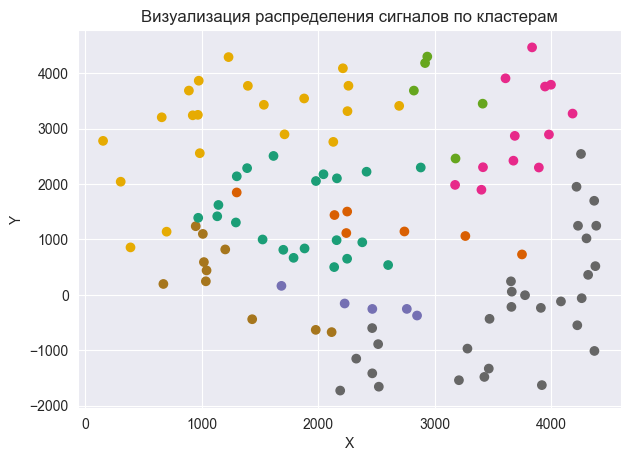

In [12]:
plt.subplots(figsize=(7, 5), dpi=100)
plt.scatter(data_marked['X'], data_marked['Y'], c=data_marked['K'].values, cmap = 'Dark2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Визуализация распределения сигналов по кластерам')
plt.show()

In [13]:
# рассмотрим описательные статистики по данным
# обратим внимание на статистики по характерным точкам, скорее всего - это индексы отсчетов
data_marked[['p_1', 'p_2', 'p_3', 'p_4']] = data_marked[['p_1', 'p_2', 'p_3', 'p_4']].replace({-1:0})
data_marked.describe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


N            X            Y         v_1         v_2  \
count  109.000000   109.000000   109.000000  109.000000  109.000000   
mean   365.201835  2500.127009  1386.060661    0.713945    0.711349   
std    214.595260  1171.929646  1639.592601    0.174575    0.181977   
min      0.000000   154.975000 -1724.860000    0.272000    0.257000   
25%    187.000000  1523.590000   163.545000    0.570000    0.569000   
50%    386.000000  2378.710000  1247.447000    0.720000    0.725000   
75%    533.000000  3607.439000  2556.292000    0.854000    0.857000   
max    753.000000  4385.807000  4464.590000    0.996000    0.995000   

              v_3         v_4         v_5         v_6         v_7  ...  \
count  109.000000  109.000000  109.000000  109.000000  109.000000  ...   
mean     0.712009    0.717459    0.713651    0.720908    0.725789  ...   
std      0.183508    0.180143    0.186567    0.186078    0.181630  ...   
min      0.250000    0.250000    0.256000    0.267000    0.288000  ...   
25%      0.571000    0.562000    0.551000    0.554000    0.584000  ...   
50%      0.730000    0.743000    0.732000    0.736000    0.743000  ...   
75%      0.858000    0.860000    0.865000    0.866000    0.877000  ...   
max      0.995000    0.999000    1.000000    0.999000    0.998000  ...   

           v_4996      v_4997      v_4998      v_4999      v_5000           K  \
count  109.000000  109.000000  109.000000  109.000000  109.000000  109.000000   
mean     0.803505    0.795257    0.793872    0.800468    0.792541    4.110092   
std      0.201917    0.213759    0.213132    0.200456    0.215127    2.780019   
min      0.350000    0.278000    0.318000    0.395000    0.298000    0.000000   
25%      0.608000    0.586000    0.588000    0.595000    0.587000    1.000000   
50%      0.899000    0.899000    0.899000    0.898000    0.897000    5.000000   
75%      0.975000    0.975000    0.975000    0.974000    0.974000    7.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    8.000000   

               p_1          p_2          p_3          p_4  
count   109.000000   109.000000   109.000000   109.000000  
mean    329.000000   880.394495  1230.743119  1603.871560  
std     676.707155  1333.209835  1735.910981  2137.885344  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%     298.000000  2264.000000  3033.000000  4178.000000  
max    3168.000000  4059.000000  4358.000000  4999.000000  

[8 rows x 5008 columns]

In [14]:
# рассмотрим первый кластер
# видимой закономерности между характерными точками и номером кластера нет 
data_marked[data_marked['K']==0][['K', 'p_1', 'p_2', 'p_3', 'p_4']]

K  p_1   p_2   p_3   p_4
93   0    0  3700  3776     0
207  0    0  2586     0  3521
212  0  662     0  3629     0
247  0  684     0     0     0
251  0    0     0     0  4602
273  0  806     0     0  4572
308  0  719     0     0     0
327  0    0     0  3337     0
331  0    0  3120     0  3903
377  0    0  4059     0     0
432  0    0  3452  4201     0
527  0    0  2686     0  3740
548  0    0  3897  4286     0
558  0    0     0     0  4282
582  0  823  3716     0     0
669  0    0     0  4217  4523
672  0  662     0     0     0
676  0  667     0     0     0
682  0    0     0  4158     0
698  0    0     0  3758  4367
718  0  450     0     0     0

In [15]:
data_marked[data_marked['K']==2][['K', 'p_1', 'p_2', 'p_3', 'p_4']]

K   p_1   p_2   p_3   p_4
135  2     0  3731     0     0
457  2  3168     0     0     0
518  2     0     0  3115  3297
605  2     0     0     0  4973
729  2  2103     0  4123     0

In [16]:
res = data_marked.groupby('K', as_index=False).agg('mean')

Среднее значение отсчетов по 0.0 кластеру 0.87
Суммарное значение отсчетов по 0.0 кластеру 4348.38
Среднее значение эксцесса по 0.0 кластеру -0.21
Среднее значение асимметрии  по 0.0 кластеру -0.4


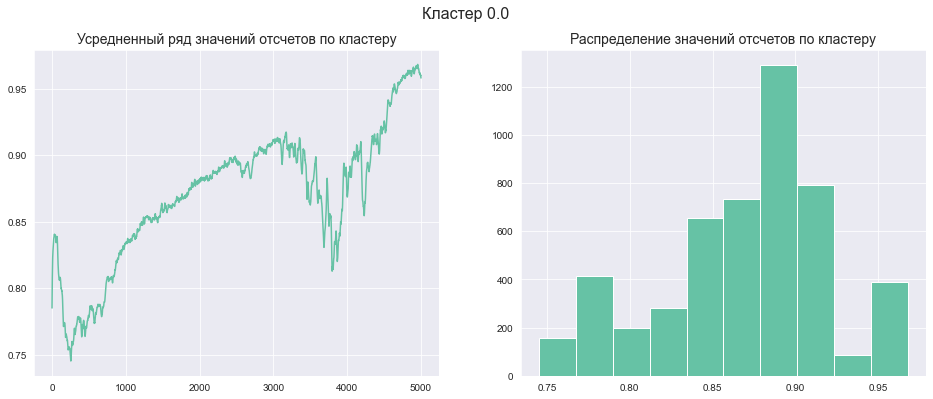

Среднее значение отсчетов по 1.0 кластеру 0.89
Суммарное значение отсчетов по 1.0 кластеру 4473.89
Среднее значение эксцесса по 1.0 кластеру 1.76
Среднее значение асимметрии  по 1.0 кластеру -1.35


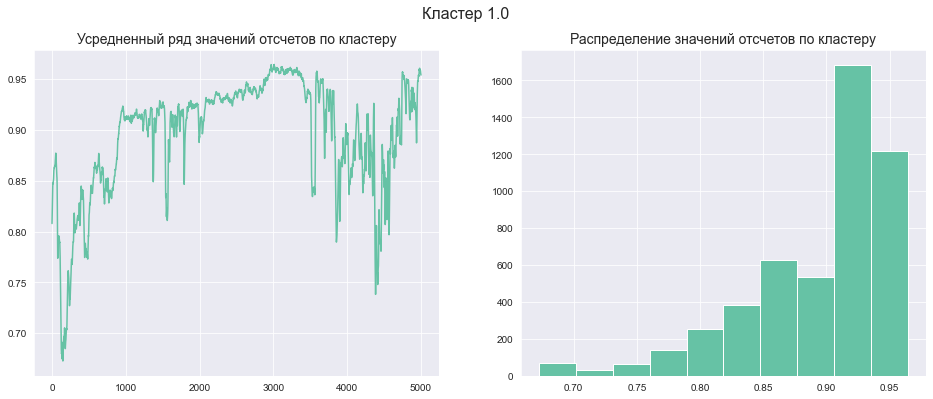

Среднее значение отсчетов по 2.0 кластеру 0.88
Суммарное значение отсчетов по 2.0 кластеру 4421.97
Среднее значение эксцесса по 2.0 кластеру 6.01
Среднее значение асимметрии  по 2.0 кластеру -2.07


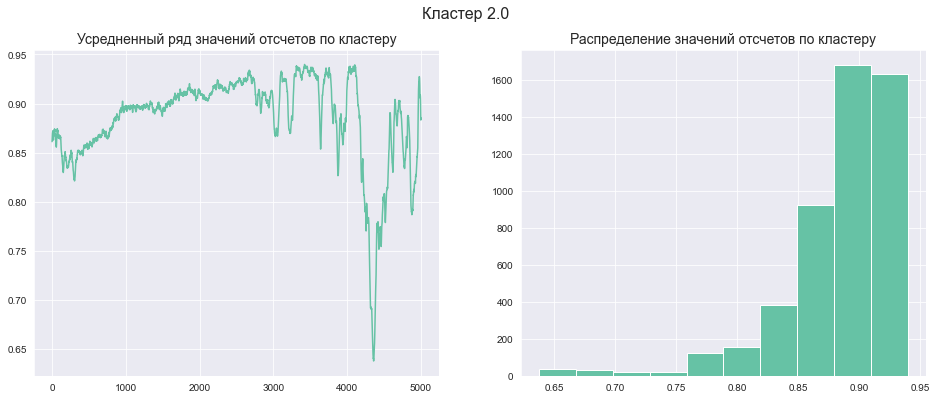

Среднее значение отсчетов по 3.0 кластеру 0.88
Суммарное значение отсчетов по 3.0 кластеру 4404.55
Среднее значение эксцесса по 3.0 кластеру 0.04
Среднее значение асимметрии  по 3.0 кластеру -0.92


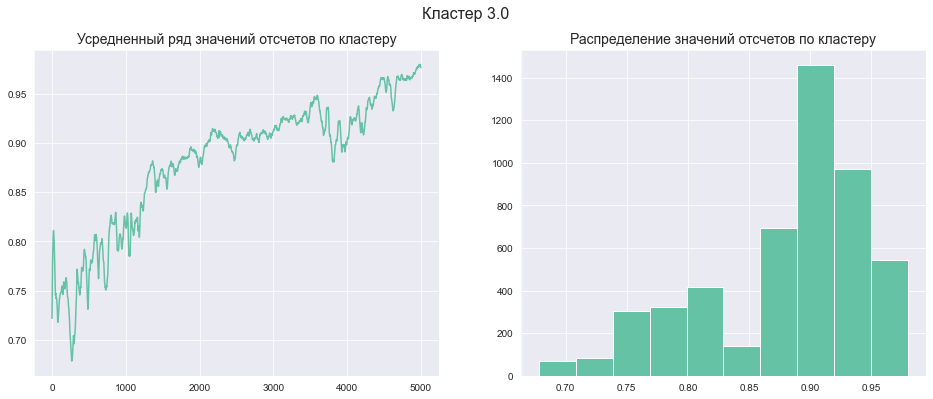

Среднее значение отсчетов по 4.0 кластеру 0.87
Суммарное значение отсчетов по 4.0 кластеру 4355.5
Среднее значение эксцесса по 4.0 кластеру -0.46
Среднее значение асимметрии  по 4.0 кластеру -0.74


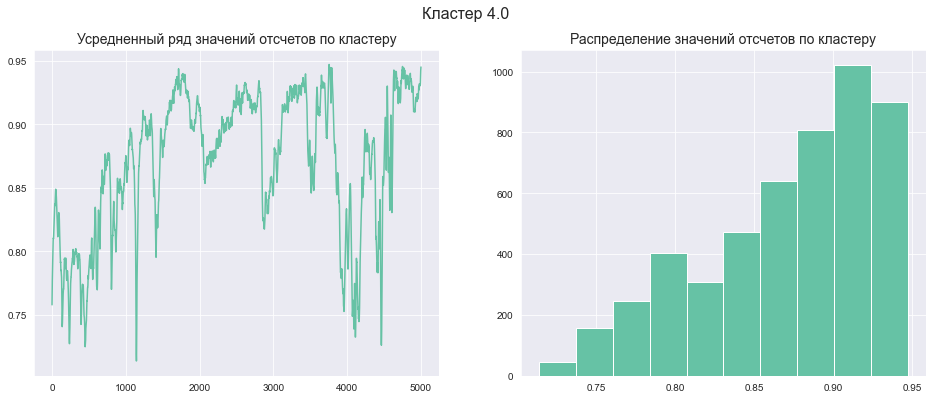

Среднее значение отсчетов по 5.0 кластеру 0.74
Суммарное значение отсчетов по 5.0 кластеру 3707.74
Среднее значение эксцесса по 5.0 кластеру -1.31
Среднее значение асимметрии  по 5.0 кластеру -0.03


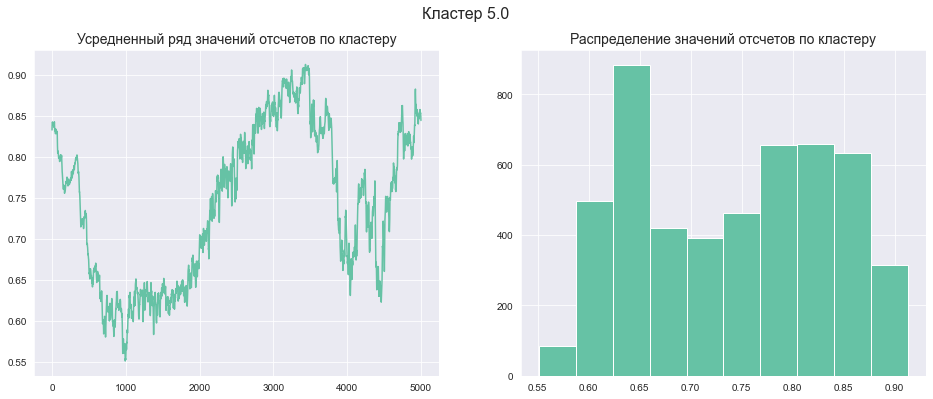

Среднее значение отсчетов по 6.0 кластеру 0.64
Суммарное значение отсчетов по 6.0 кластеру 3189.14
Среднее значение эксцесса по 6.0 кластеру -1.31
Среднее значение асимметрии  по 6.0 кластеру 0.03


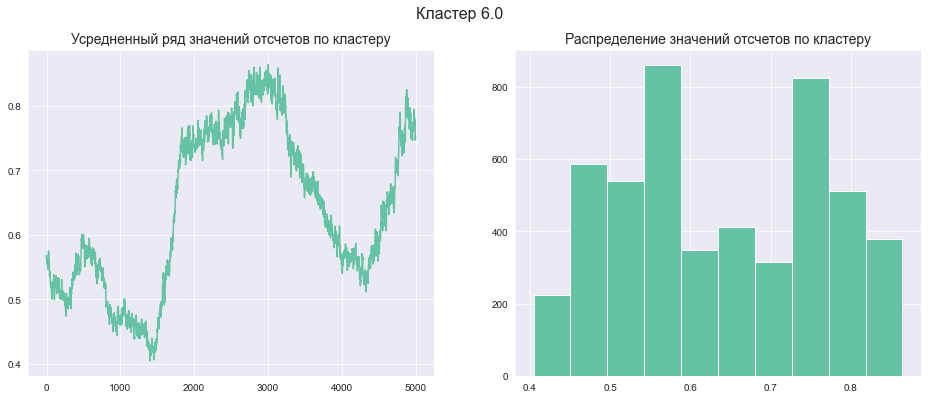

Среднее значение отсчетов по 7.0 кластеру 0.57
Суммарное значение отсчетов по 7.0 кластеру 2851.02
Среднее значение эксцесса по 7.0 кластеру -1.27
Среднее значение асимметрии  по 7.0 кластеру -0.18


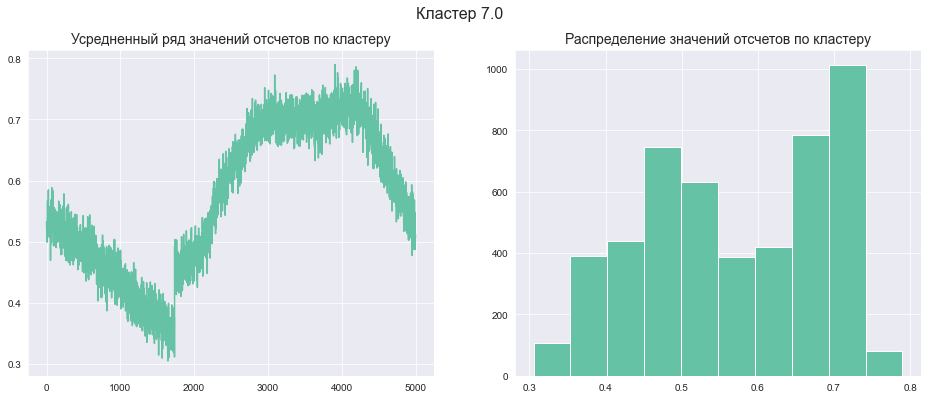

Среднее значение отсчетов по 8.0 кластеру 0.6
Суммарное значение отсчетов по 8.0 кластеру 2984.95
Среднее значение эксцесса по 8.0 кластеру -1.19
Среднее значение асимметрии  по 8.0 кластеру -0.03


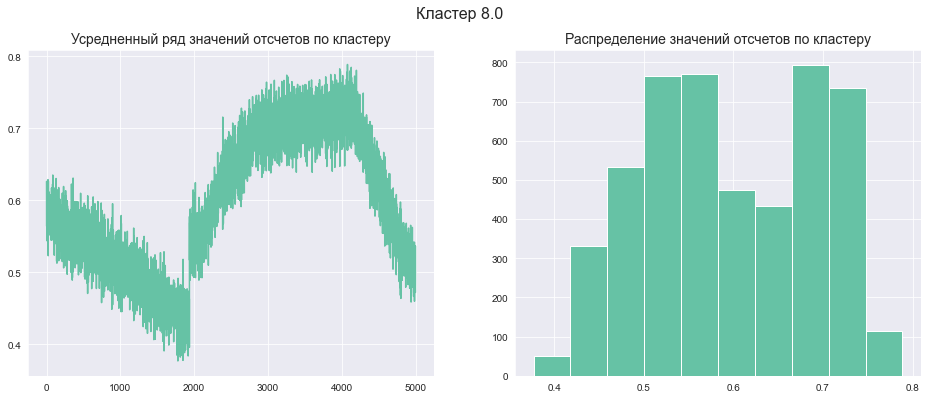

In [17]:
# визуализируем усредненные данные по каждому кластеру 
for i in res.values:
    print(f'Среднее значение отсчетов по {i[0]} кластеру', round(np.mean(i[4:-4]),2))
    print(f'Суммарное значение отсчетов по {i[0]} кластеру', round(np.sum(i[4:-4]),2))
    print(f'Среднее значение эксцесса по {i[0]} кластеру', round(kurtosis(i[4:-4]),2))
    print(f'Среднее значение асимметрии  по {i[0]} кластеру', round(skew(i[4:-4]),2))
    
    plt.subplots(figsize=(16, 6))
    plt.suptitle(f'Кластер {i[0]}', fontsize=16)
    
    ax1 = plt.subplot(121)
    ax1.plot(i[4:-4])
    ax1.set_title('Усредненный ряд значений отсчетов по кластеру', fontsize=14)
    

    ax2 = plt.subplot(122)
    ax2.hist(i[4:-4])
    ax2.set_title('Распределение значений отсчетов по кластеру', fontsize=14)
    
    plt.show()
    

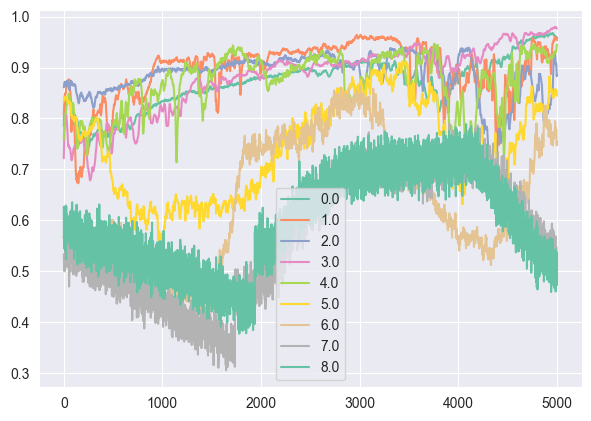

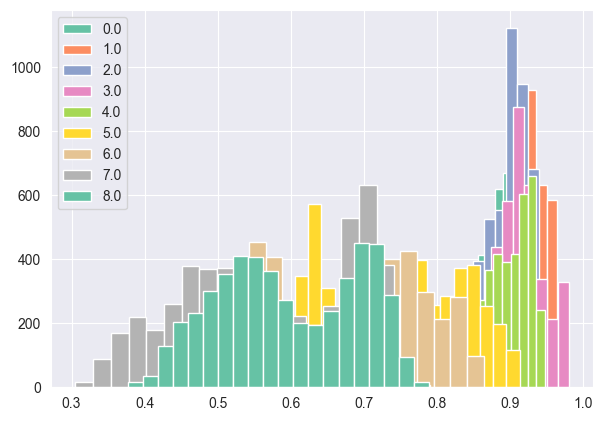

In [18]:
plt.subplots(figsize=(7, 5), dpi=100)
for i in res.values:
    plt.plot(i[4:-4], label=f'{i[0]}')
plt.legend()
plt.show()

plt.subplots(figsize=(7, 5), dpi=100)
for i in res.values:
    plt.hist(i[4:-4], bins=20, label=f'{i[0]}')
plt.legend()
plt.show()

Таким образом, по выделенным характеристикам кластеров (матожиданию, асимметрии, эксцессу) среди размеченных данных и визуализации распределений внутри кластеров видны различия между кластерами, которые впоследствии можно учесть при построении моделий кластеризации на всем объеме данных.

## 2. Построение моделей кластеризации 

### K-means

Начнем построение кластеризации с модели  __K-means__. Преимущество данного метода заключается в том, что в качестве входного параметра можно сразу же задать необходимое количество кластеров. В нашем случае это 9 класеров.

Алгоритм __K-means__ представляет собой итеративный процесс. Пусть в начале произвольным образом выбраны центры классов. Объект относится к тому кластеру, расстояние до центра которого меньше. На каждой итерации сначала пересчитываются положения центра каждого класса как среднее арифметическое отнесенных к нему точек, а после этого объекты перераспределяются на основании новых положений центров.

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [20]:
train_data = data.drop(columns=['N', 'K', 'p_1', 'p_2', 'p_3', 'p_4'])
test_data = data_marked.drop(columns=['N', 'K', 'p_1', 'p_2', 'p_3', 'p_4'])
test_y = data_marked['K']

In [21]:
model = KMeans(n_clusters=9, random_state=5, n_init=15, max_iter=500).fit(train_data)
prediction = model.predict(train_data)
test_pred = model.predict(test_data)

Проверим, насколько хорошо удастся кластеризовать размеченные данные 

In [22]:
accuracy_score(test_y, test_pred)

0.3761467889908257

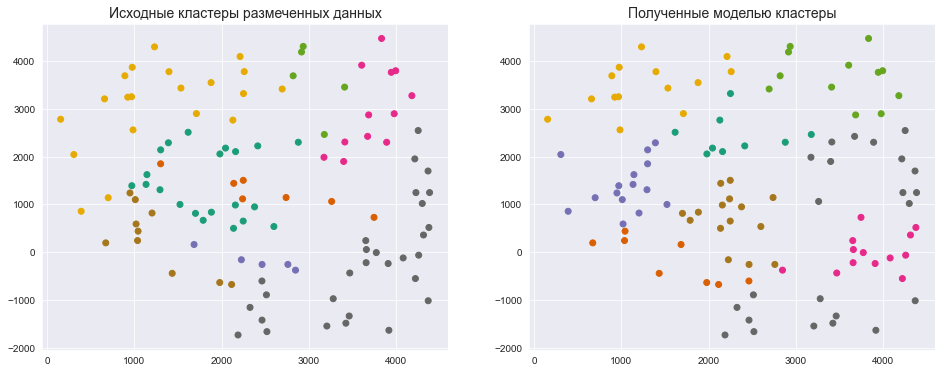

In [23]:
plt.subplots(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.scatter(test_data['X'], test_data['Y'], c = test_y.values, cmap = 'Dark2')
ax1.set_title('Исходные кластеры размеченных данных', fontsize=14)


ax2 = plt.subplot(122)
ax2.scatter(test_data['X'], test_data['Y'], c = test_pred, cmap = 'Dark2')
ax2.set_title('Полученные моделью кластеры', fontsize=14)

plt.show()

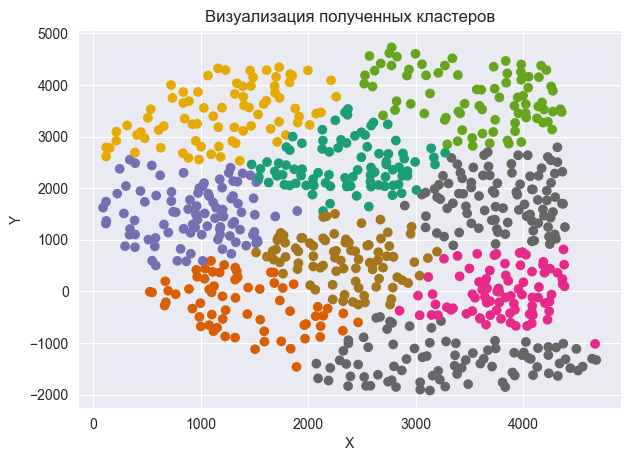

In [24]:
plt.subplots(figsize=(7, 5), dpi=100)
plt.scatter(train_data['X'], train_data['Y'], c=prediction, cmap = 'Dark2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Визуализация полученных кластеров')
plt.show()

Уменьшим размерность данных

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [26]:
for i in [100, 50, 30, 20, 10, 5, 2]:
    pca = PCA()
    pca.n_components = i
    pca_data = pca.fit_transform(train_data)
    pca_test_data = pca.transform(test_data)

    model = KMeans(n_clusters=9, random_state=5).fit(pca_data)
    prediction = model.predict(pca_data)
    test_pred = model.predict(pca_test_data)
    print(accuracy_score(test_y, test_pred))

0.3761467889908257
0.3761467889908257
0.3761467889908257
0.3761467889908257
0.3761467889908257
0.3761467889908257
0.3761467889908257


Уменьшение размерности не сказалось на точности 

### Агломеративная иерархическая кластеризация

__Иерархическая кластеризация__ — кластеризация, в которой кластеры получаются вложенными друг в друга. __Агломеративный подход__: каждый объект помещается в свой собственный кластер, которые постепенно объединяются. В начале работы алгоритма все объекты являются отдельными кластерами. Затем вычисляется расстояние между кластерами
по выбранному методу. Наиболее похожие, близкие объекты объединяются в кластер. На последующих шагах объединение продолжается до тех пор, пока все объекты не будут составлять один кластер.

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward

In [28]:
# функция для визуализации дендрограммы
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

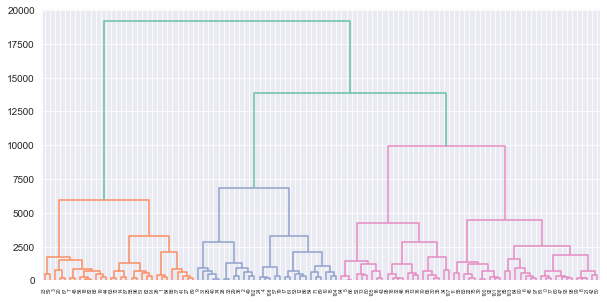

In [29]:
# обучение модели
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward', compute_distances=True)
cluster.fit(train_data)
labels = cluster.fit_predict(train_data)
test_labels = cluster.fit_predict(test_data)
# визуализация слияния кластеров по мере уменьшения межкластерного расстояния, в нашем случае межкластерное расстояние около 2500 и кол-во кластеров 9
plt.subplots(figsize=(10, 5))
plot_dendrogram(cluster)

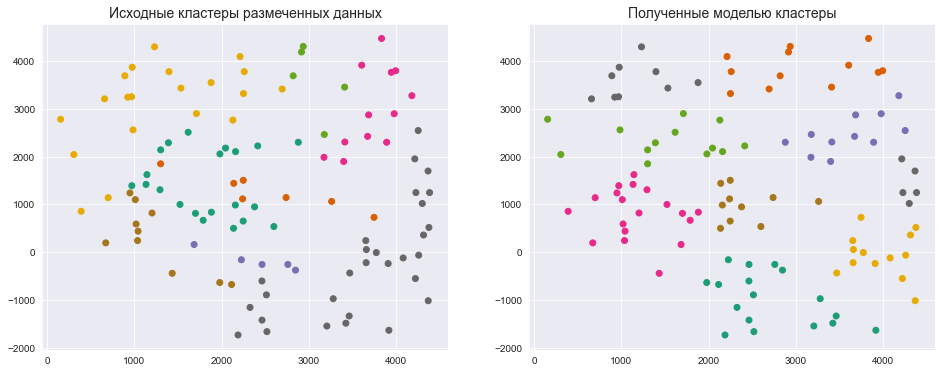

In [30]:
plt.subplots(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.scatter(test_data['X'], test_data['Y'], c = test_y.values, cmap = 'Dark2')
ax1.set_title('Исходные кластеры размеченных данных', fontsize=14)


ax2 = plt.subplot(122)
ax2.scatter(test_data['X'], test_data['Y'], c = test_labels, cmap = 'Dark2')
ax2.set_title('Полученные моделью кластеры', fontsize=14)

plt.show()

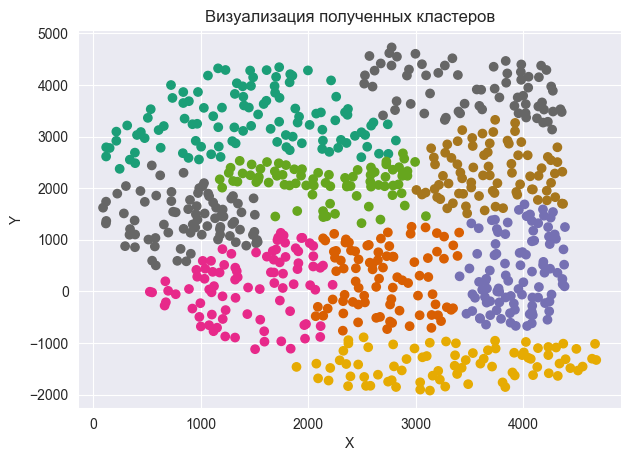

In [31]:
plt.subplots(figsize=(7, 5), dpi=100)
plt.scatter(train_data['X'], train_data['Y'], c=labels, cmap = 'Dark2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Визуализация полученных кластеров')
plt.show()

С помощью решения задачи кластеризации не удается добиться хороших результатаов на размеченных данных. Из визуализации видно, что на размеченных данных кластеры получаются неправильной формы, сбалансированность кластеров на размеченных данных также не соблюдается. Результаты по метрике качества не настолько хороши, насколько этого хотелось бы. Вообще, странно использовать такую метрику качества в задачи кластеризации, в кластеризации вообще не идет речь о размеченных данных даже для теста. 

Исходя из вышеперечисленных факторов было принято решение __обучить классификатор на размеченных данных и построить предсказания принадлежности к каждому кластеру__. 

## 3. Построение моделей классификации

Для построения классификации воспользуемся методом ближайших соседей.

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [33]:
# подберем кол-во соседей
for i in [3, 4, 5, 8, 9]:
    clf = KNeighborsClassifier(n_neighbors=i)  
    print(cross_val_score(clf, test_data, test_y, cv=3, scoring='accuracy').mean())

0.8528528528528528
0.7702702702702703
0.8165665665665666
0.771021021021021
0.7154654654654654


In [34]:
# обучение модели
clf = KNeighborsClassifier(n_neighbors=3)  
clf.fit(test_data, test_y)
test_pred = clf.predict(test_data)
all_pred = clf.predict(train_data)

Проверим, насколько хорошо удастся кластеризовать размеченные данные 

In [35]:
accuracy_score(test_y, test_pred)

0.926605504587156

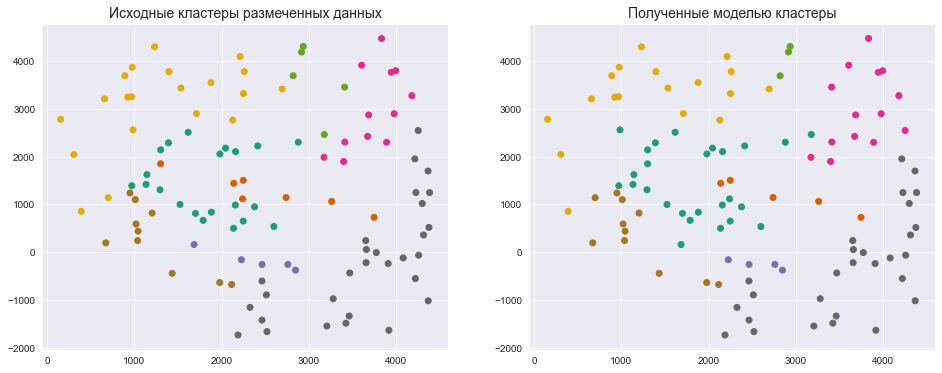

In [36]:
plt.subplots(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.scatter(test_data['X'], test_data['Y'], c = test_y.values, cmap = 'Dark2')
ax1.set_title('Исходные кластеры размеченных данных', fontsize=14)


ax2 = plt.subplot(122)
ax2.scatter(test_data['X'], test_data['Y'], c = test_pred, cmap = 'Dark2')
ax2.set_title('Полученные моделью кластеры', fontsize=14)

plt.show()

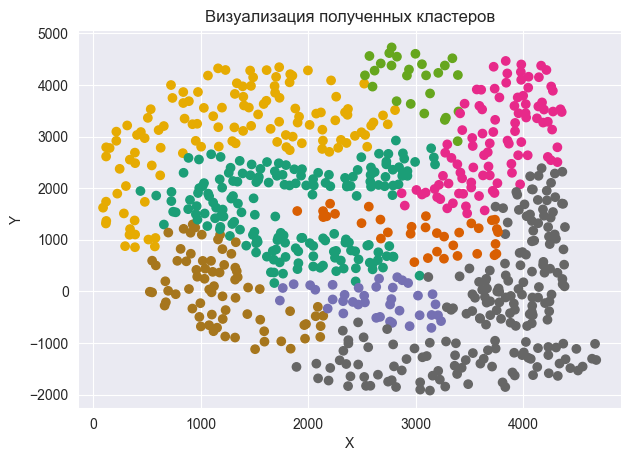

In [37]:
plt.subplots(figsize=(7, 5), dpi=100)
plt.scatter(train_data['X'], train_data['Y'], c=all_pred, cmap = 'Dark2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Визуализация полученных кластеров')
plt.show()

В данном случае мы получили кластеры схожие по форме и составу с размеченными данными, более того, добились достаточно высоких результатов по метрике качества. Остановимся на данной модели и добавим предсказанные метки кластеров в исходный датасет.

In [38]:
train_data.head()

X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7    v_8  \
0  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426  0.448   
1  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645  0.515   
2  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574  0.601   
3  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904  0.904   
4   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392  0.371   

   ...  v_4991  v_4992  v_4993  v_4994  v_4995  v_4996  v_4997  v_4998  \
0  ...   0.595   0.571   0.564   0.535   0.560   0.606   0.523   0.607   
1  ...   0.633   0.496   0.591   0.626   0.508   0.397   0.579   0.636   
2  ...   0.572   0.605   0.476   0.580   0.621   0.569   0.587   0.541   
3  ...   0.943   0.943   0.943   0.943   0.943   0.943   0.943   0.943   
4  ...   0.732   0.706   0.668   0.637   0.624   0.626   0.606   0.629   

   v_4999  v_5000  
0   0.629   0.664  
1   0.570   0.530  
2   0.412   0.519  
3   0.943   0.943  
4   0.674   0.727  

[5 rows x 5002 columns]

In [39]:
train_data['K'] = all_pred
data['K'] = all_pred

In [40]:
df=data.copy()

In [41]:
# распределение предсказанных кластеров
train_data['K'].value_counts()

0    179
5    121
7    110
3     96
8     83
6     73
2     38
1     34
4     26
Name: K, dtype: int64

## 4. Определение характерных точек в каждом кластере

In [42]:
from xgboost import XGBRegressor
from scipy.stats import entropy
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from scipy.fft import fft, fftfreq

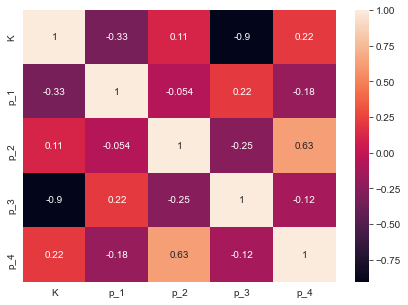

In [43]:
fig = plt.figure(figsize=(7, 5))
sns.heatmap(res[['K', 'p_1', 'p_2', 'p_3', 'p_4']].corr(), annot = True)
plt.show()

In [44]:
data.head()

N         X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7  \
0  168  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426   
1  307  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645   
2  668  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574   
3  229  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904   
4  316   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392   

   ...  v_4996  v_4997  v_4998  v_4999  v_5000  K  p_1  p_2  p_3  p_4  
0  ...   0.606   0.523   0.607   0.629   0.664  7   -1   -1   -1   -1  
1  ...   0.397   0.579   0.636   0.570   0.530  7   -1   -1   -1   -1  
2  ...   0.569   0.587   0.541   0.412   0.519  7   -1   -1   -1   -1  
3  ...   0.943   0.943   0.943   0.943   0.943  2   -1   -1   -1   -1  
4  ...   0.626   0.606   0.629   0.674   0.727  6   -1   -1   -1   -1  

[5 rows x 5008 columns]

In [45]:
data[['p_1', 'p_2', 'p_3', 'p_4']] = data[['p_1', 'p_2', 'p_3', 'p_4']].replace({-1: 0})

In [46]:
data['skew'] = data.iloc[:, 3:-5].skew(axis=1)
data['kurtosis'] = data.iloc[:, 3:-6].kurtosis(axis=1)

In [47]:
mean4_array = []
for i in range(len(data)):
    temp_array = []
    for j in range(0, 4):
        temp = (data.iloc[i,3:-7].values)[1250*j:1250*(j+1)]
        temp_array.append(temp.mean())
    mean4_array.append(temp_array)
mean_parts = pd.DataFrame(mean4_array, columns=['interval 1', 'interval 2', 'interval 3', 'interval 4'])
mean_parts.head()

interval 1  interval 2  interval 3  interval 4
0    0.482549    0.460056    0.670206    0.668041
1    0.495978    0.454757    0.699351    0.664474
2    0.531973    0.480268    0.673167    0.690392
3    0.902814    0.973986    0.894986    0.924340
4    0.419235    0.629532    0.729617    0.604641

In [48]:
data['interval1'] = mean_parts['interval 1'].values
data['interval2'] = mean_parts['interval 2'].values
data['interval3'] = mean_parts['interval 3'].values
data['interval4'] = mean_parts['interval 4'].values
data['entropy'] = entropy(data.iloc[:, 3:-11], axis=1)
data['quant 0.25'] = np.quantile(data.iloc[:, 3:-12], 0.25, axis=1)
data['quant 0.5'] = np.quantile(data.iloc[:, 3:-13], 0.5, axis=1)
data['quant 0.75'] = np.quantile(data.iloc[:, 3:-14], 0.75, axis=1)

In [49]:
fourie = np.fft.fft(data.iloc[:, 3:-15] - data.iloc[:, 3:-15].mean())
fr = np.fft.fftfreq(5000, 0.01)
magnitude = np.fft.fftshift(np.abs(fourie)).max(axis=1)
data['fourier M'] = magnitude

In [50]:
yhat_array = []
for i in range(len(data)):
    yhat = SimpleExpSmoothing(data.iloc[i, 3:-16].values, 
                              initialization_method='estimated').fit(smoothing_level=0.01, optimized=False)
    yhat_array.append(yhat.fittedvalues)
data.iloc[:, 3:-16] = np.array(yhat_array)

In [51]:
data.head()

N         X         Y       v_1       v_2       v_3       v_4       v_5  \
0  168  3642.317  -107.175  0.586467  0.586182  0.586270  0.585597  0.587162   
1  307  4034.298  -668.198  0.582933  0.583604  0.582338  0.582235  0.582852   
2  668  4358.001  1703.199  0.599867  0.600248  0.600456  0.600911  0.599852   
3  229  2786.060    75.125  0.918733  0.918716  0.918699  0.918672  0.918605   
4  316   988.637  -492.056  0.379267  0.379064  0.378913  0.378914  0.379085   

        v_6       v_7  ...   kurtosis  interval1  interval2  interval3  \
0  0.587930  0.586721  ...  -0.516378   0.482549   0.460056   0.670206   
1  0.582834  0.582255  ...  -0.494888   0.495978   0.454757   0.699351   
2  0.598953  0.599074  ...  -0.359490   0.531973   0.480268   0.673167   
3  0.918499  0.918364  ...  14.398252   0.902814   0.973986   0.894986   
4  0.379334  0.379591  ...  -1.042828   0.419235   0.629532   0.729617   

   interval4   entropy  quant 0.25  quant 0.5  quant 0.75   fourier M  
0   0.668041  8.485520     0.46800     0.5705       0.676  719.619412  
1   0.664474  8.483671     0.47000     0.5830       0.690  439.045412  
2   0.690392  8.489993     0.49600     0.5960       0.695  808.044412  
3   0.924340  8.510473     0.92075     0.9560       0.973  612.072412  
4   0.604641  8.471202     0.44700     0.5950       0.743  510.640412  

[5 rows x 5019 columns]

In [52]:
predicted_y_array = []
for i in ['p_1', 'p_2', 'p_3', 'p_4']:
    test = data.loc[data[i] != 0]
    
    X_test1 = test.drop(columns=['p_1', 'p_2', 'p_3', 'p_4', 'N'])
    y_test1 = test[i]
    
    model = XGBRegressor()
    model.fit(X_test1, y_test1)
    
    predicted_y = model.predict(data.drop(columns=['p_1', 'p_2', 'p_3', 'p_4', 'N']))
    predicted_y_array.append(predicted_y)

In [53]:
res_dataframe = data.iloc[:,:-15].copy()
res_dataframe['p_1'] = list(map(int, predicted_y_array[0]))
res_dataframe['p_2'] = list(map(int, predicted_y_array[1]))
res_dataframe['p_3'] = list(map(int, predicted_y_array[2]))
res_dataframe['p_4'] = list(map(int, predicted_y_array[3]))
res_dataframe.iloc[:, 3:-5] = df.iloc[:, 3:-5]

In [54]:
res_dataframe.head()

N         X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7  \
0  168  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426   
1  307  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645   
2  668  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574   
3  229  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904   
4  316   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392   

   ...  v_4996  v_4997  v_4998  v_4999  v_5000  K   p_1   p_2   p_3   p_4  
0  ...   0.606   0.523   0.607   0.629   0.664  7  1327  2489  2616  4985  
1  ...   0.397   0.579   0.636   0.570   0.530  7  1338  2418  2557  4998  
2  ...   0.569   0.587   0.541   0.412   0.519  7  1184  2458  2579  4868  
3  ...   0.943   0.943   0.943   0.943   0.943  2  1242  1441  3690  4006  
4  ...   0.626   0.606   0.629   0.674   0.727  6  1193  1758  2528  4286  

[5 rows x 5008 columns]

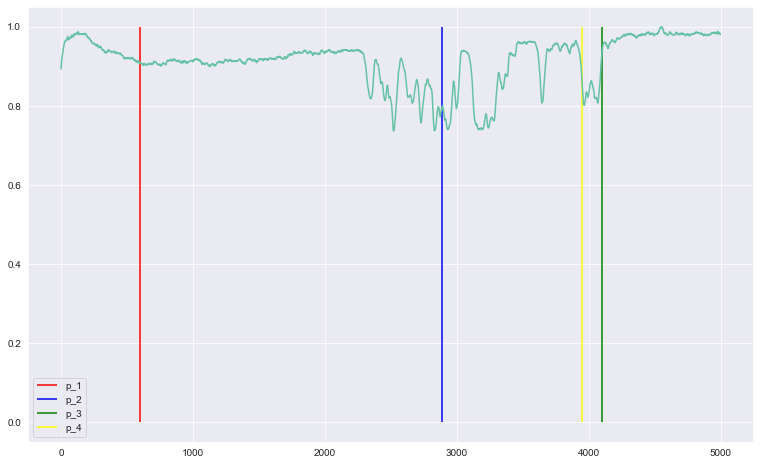

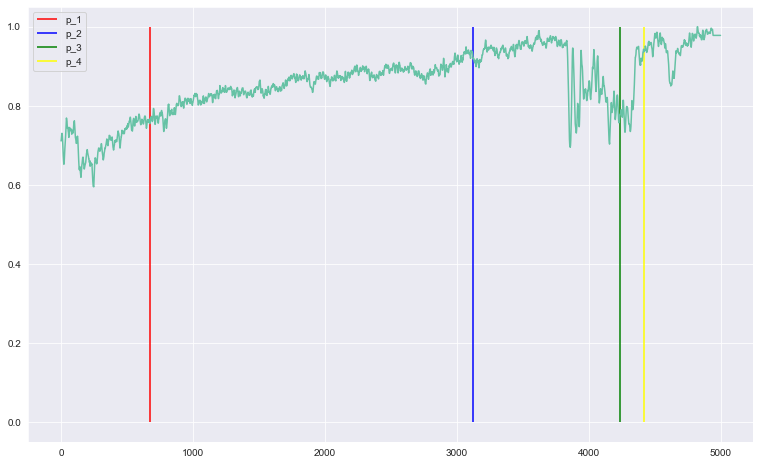

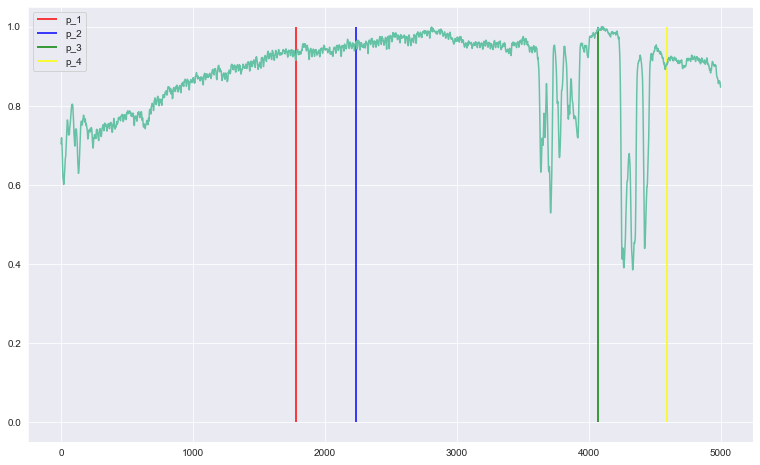

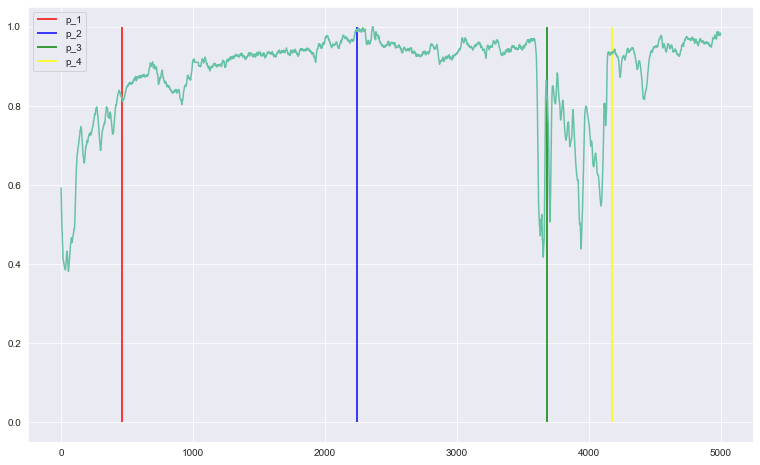

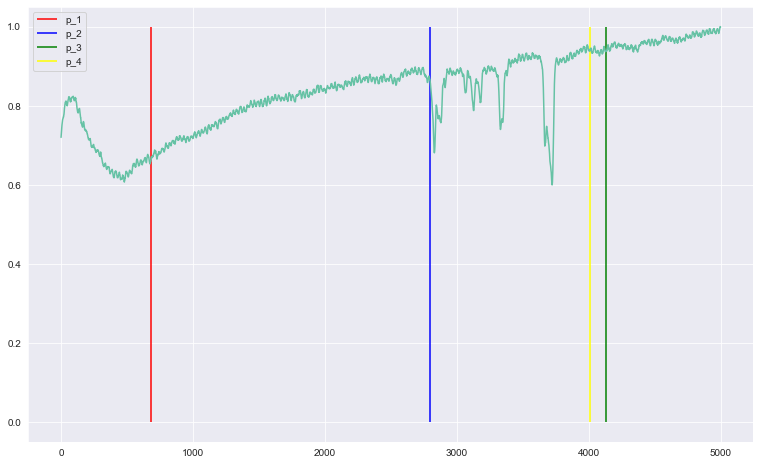

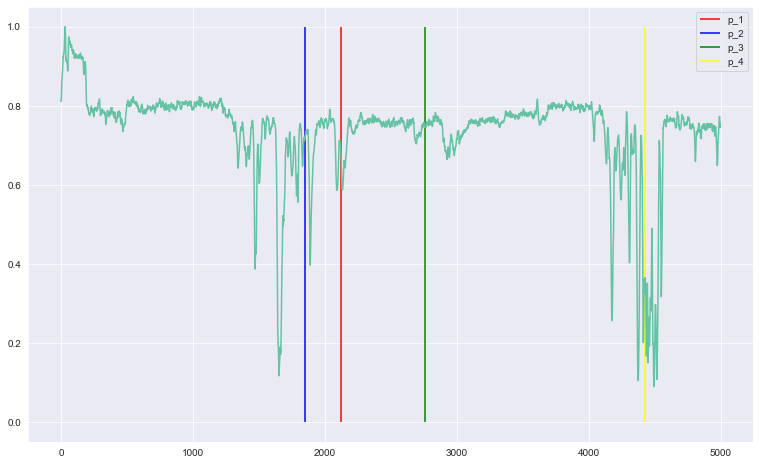

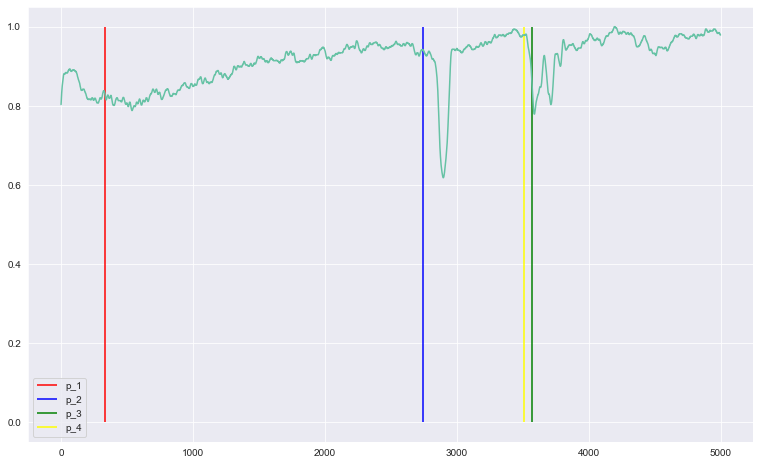

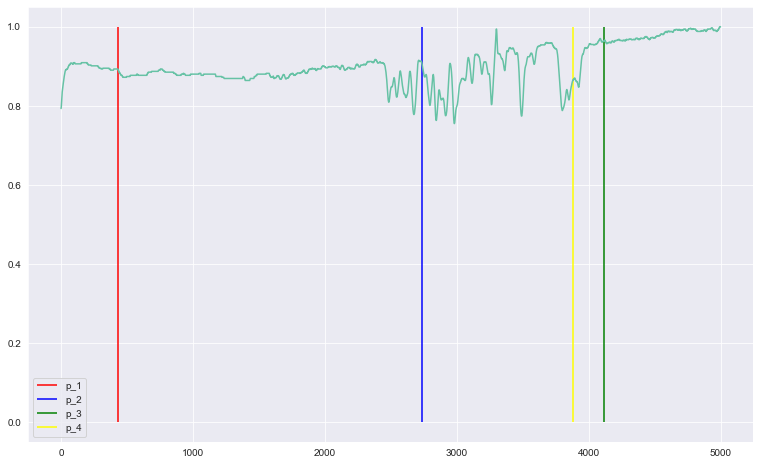

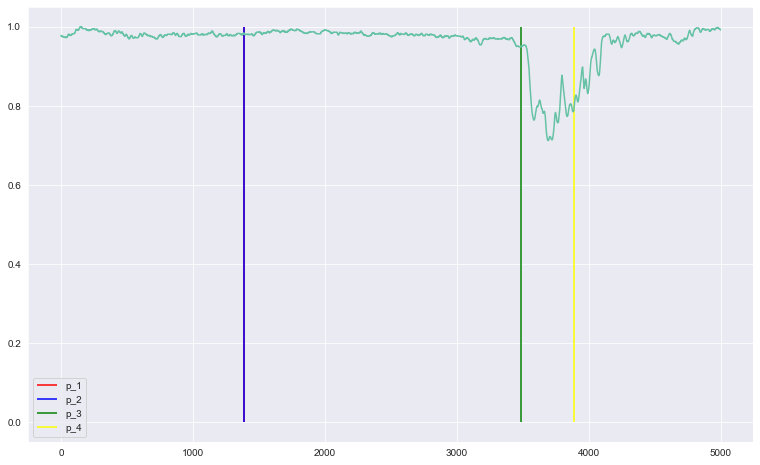

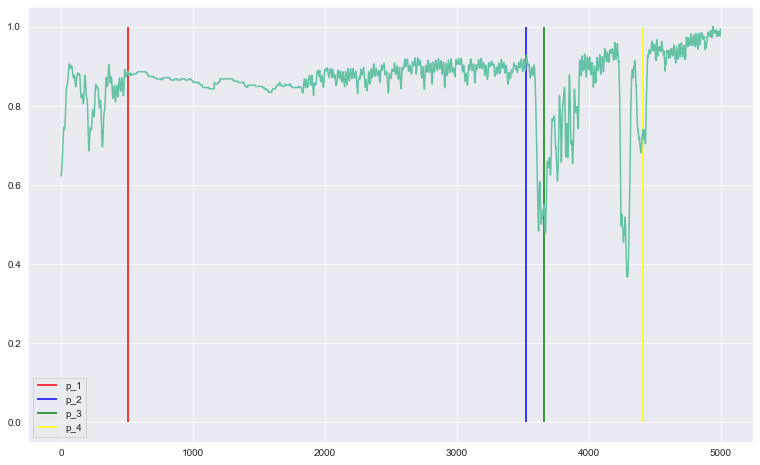

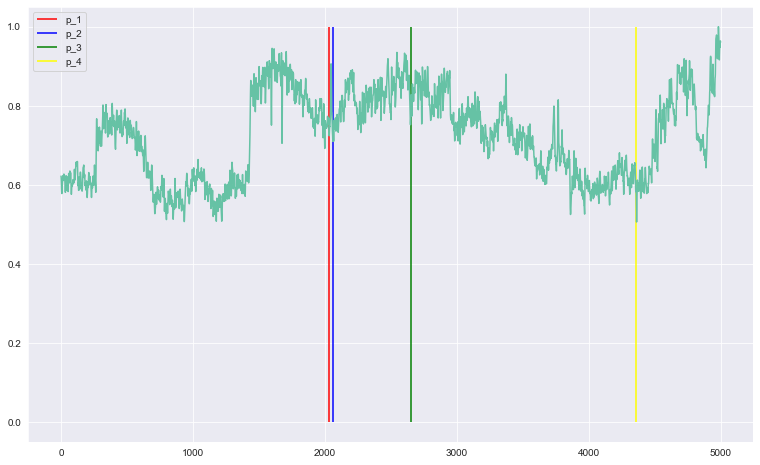

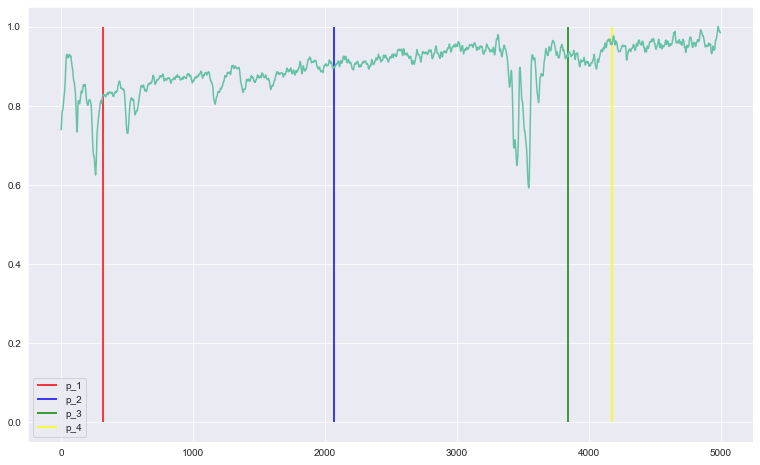

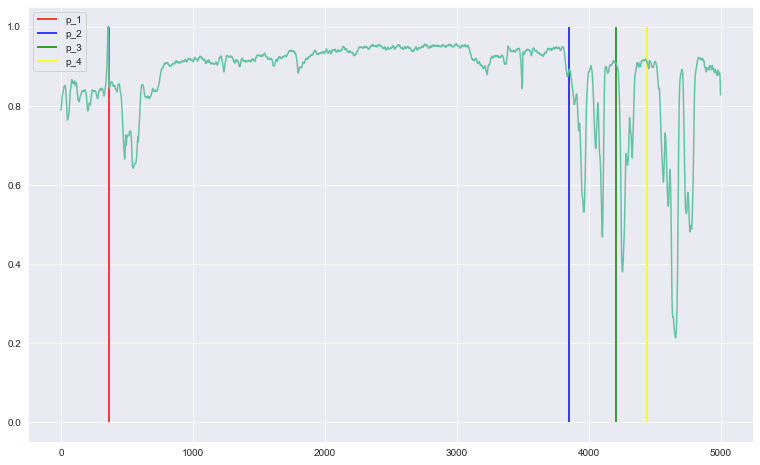

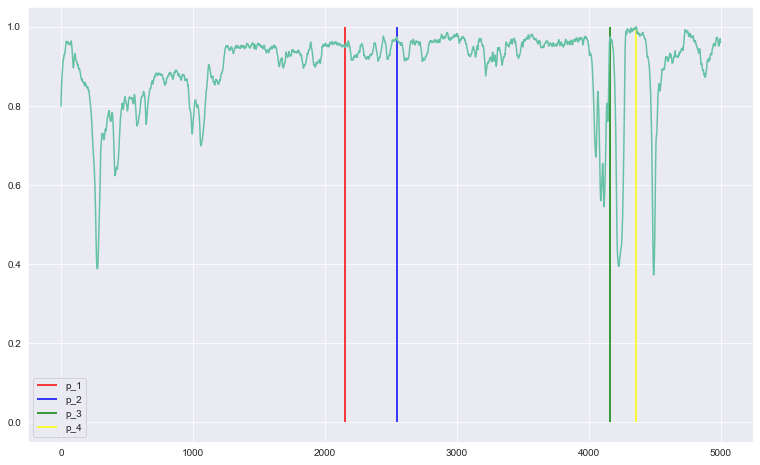

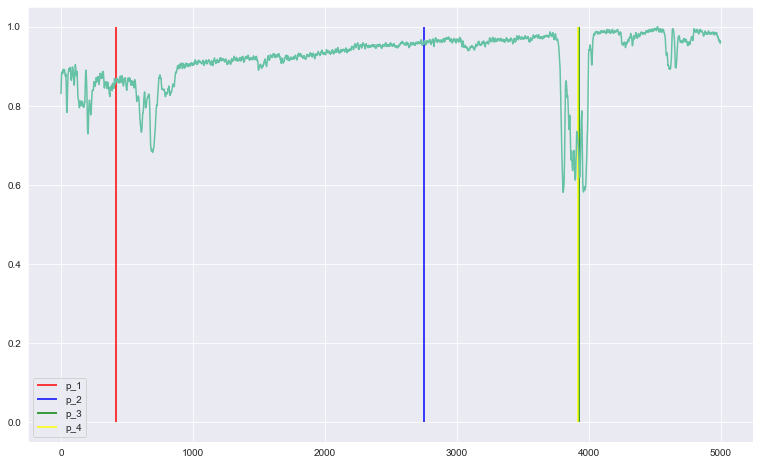

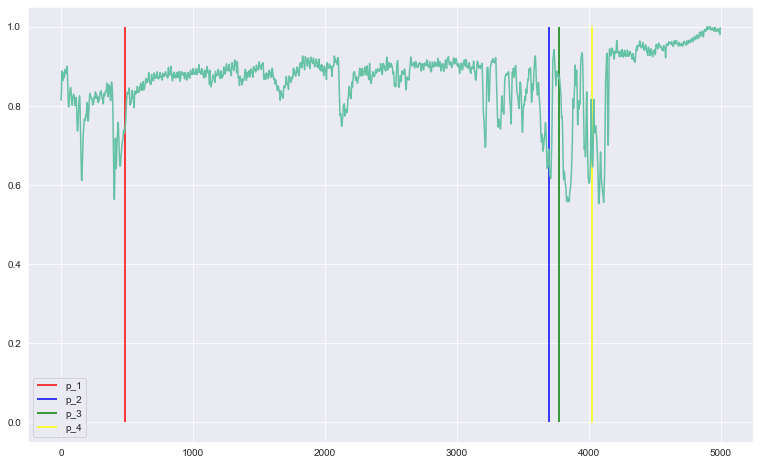

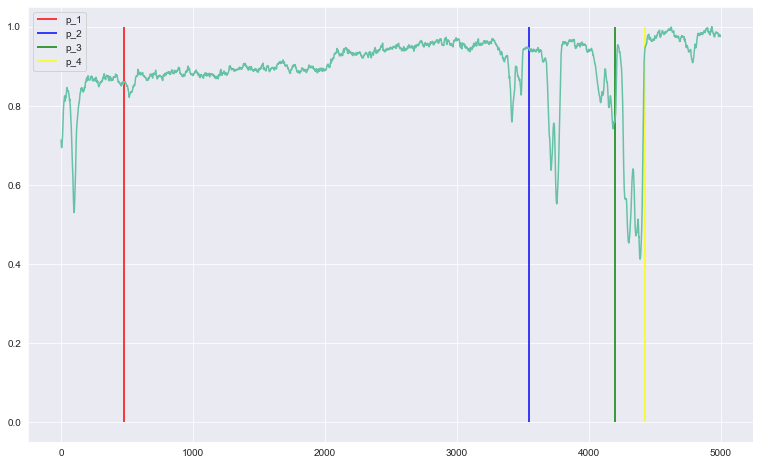

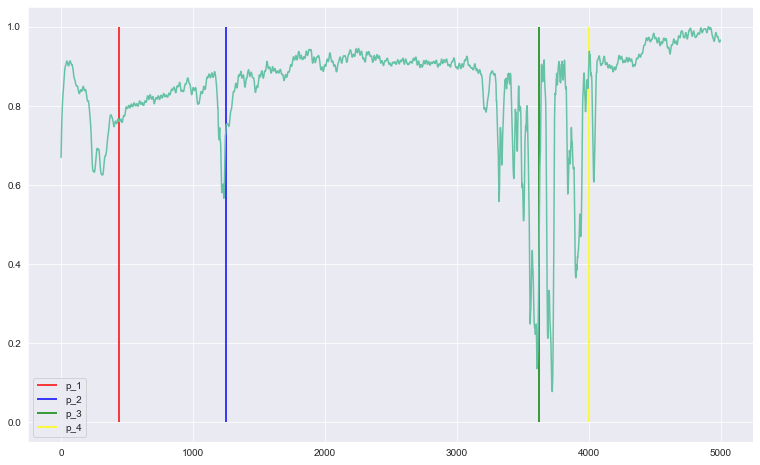

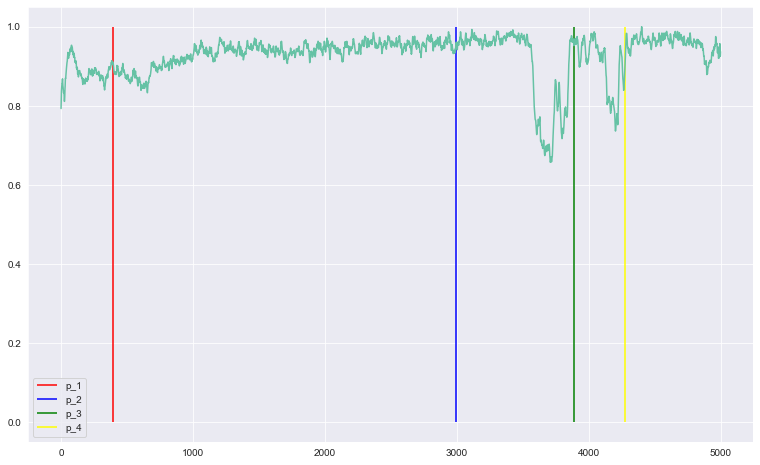

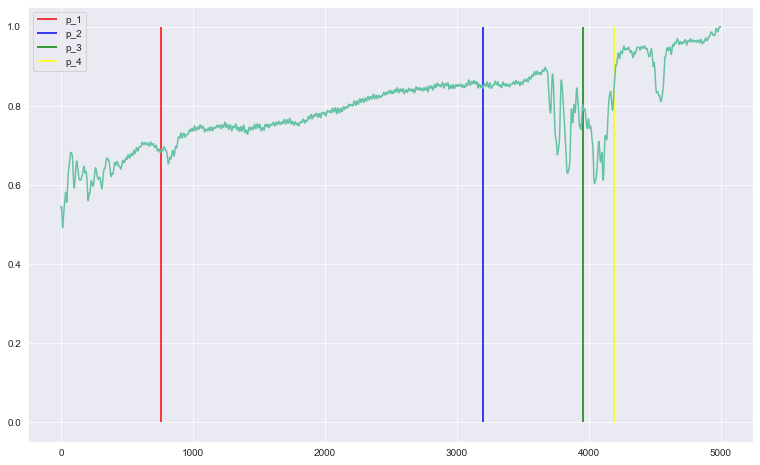

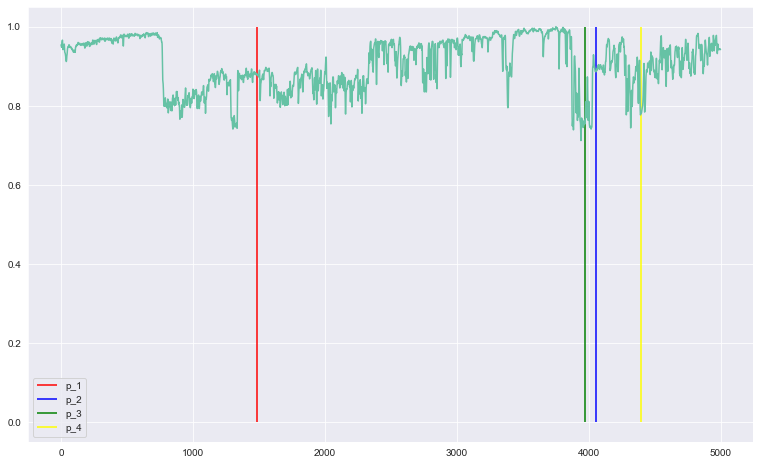

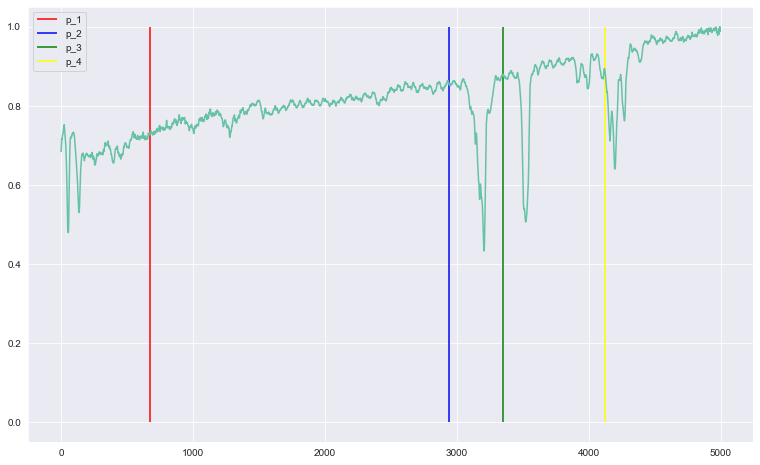

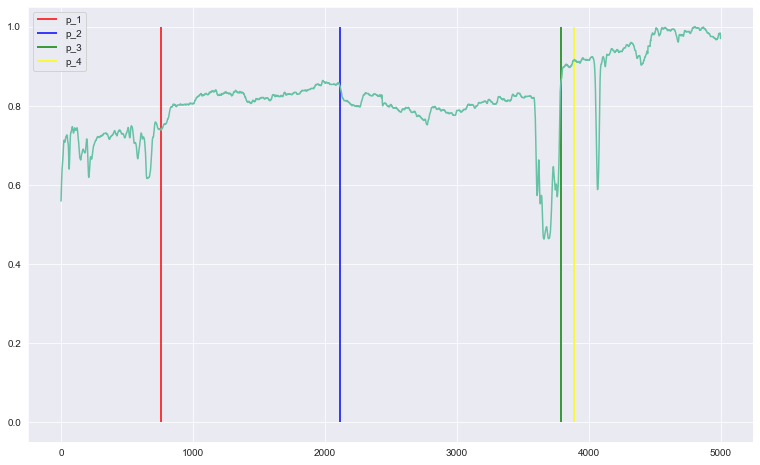

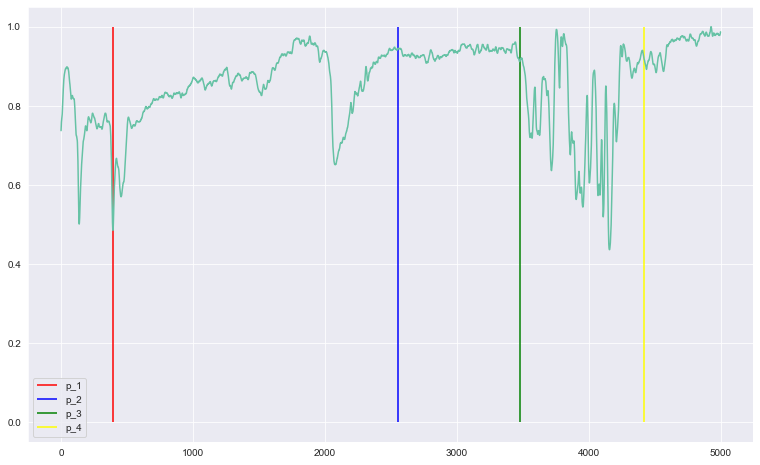

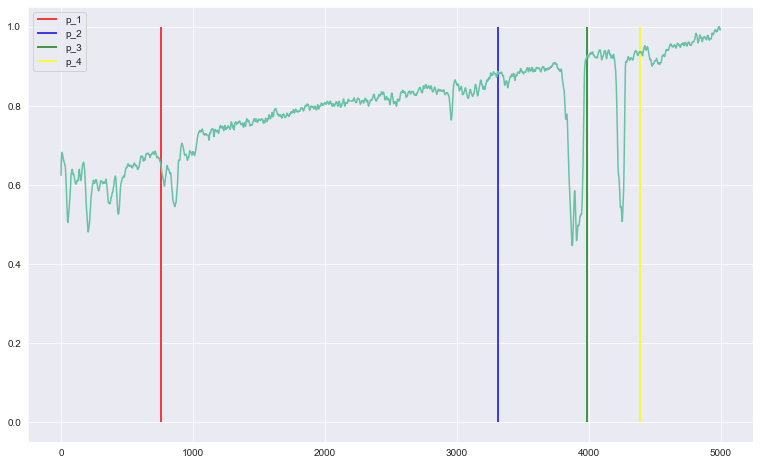

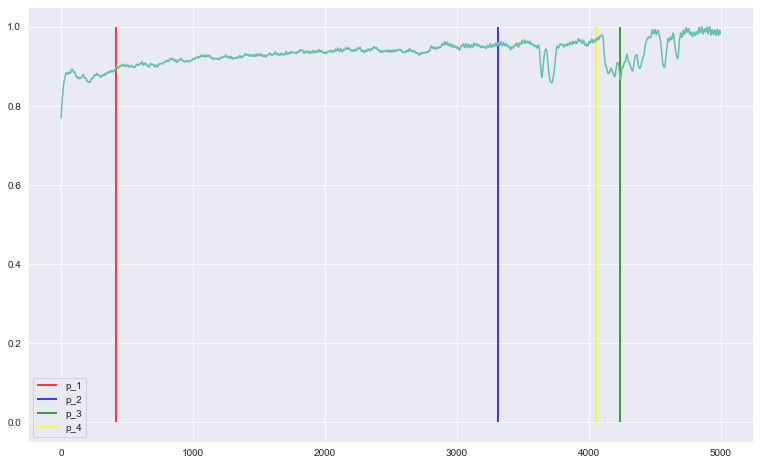

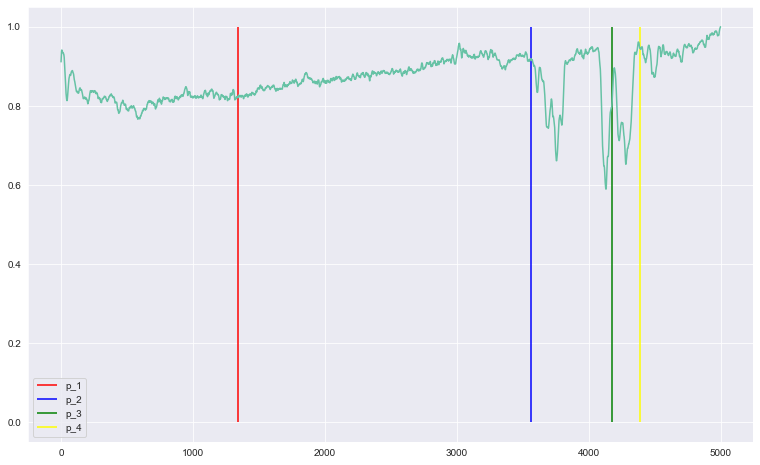

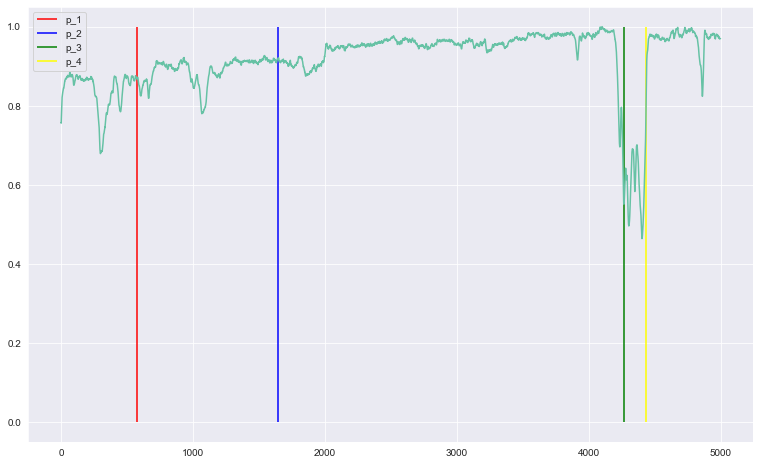

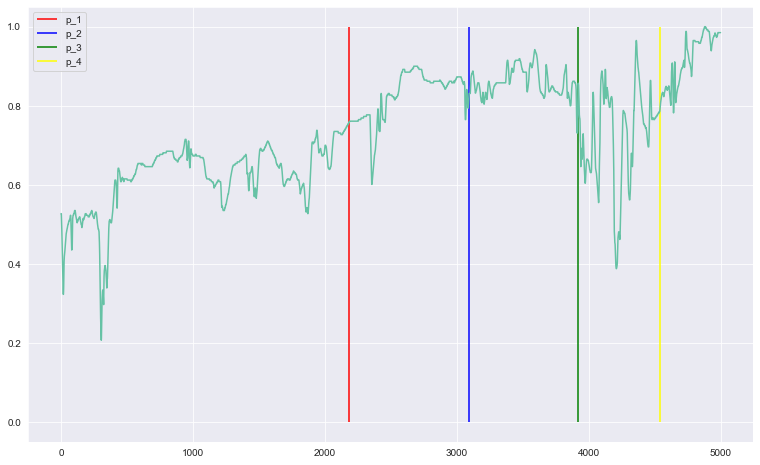

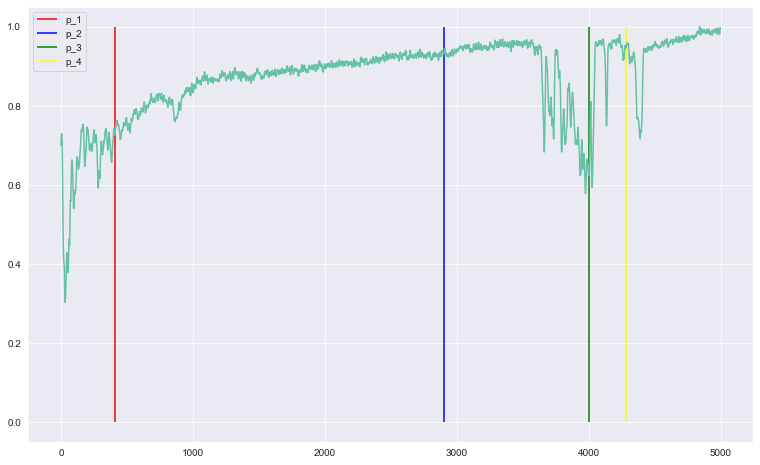

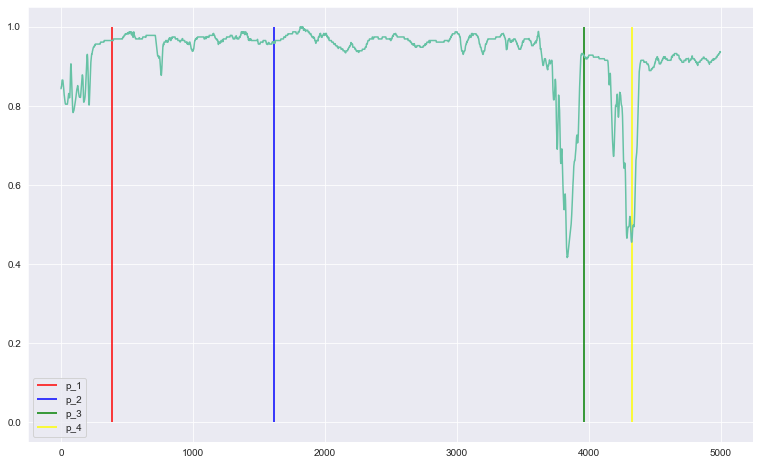

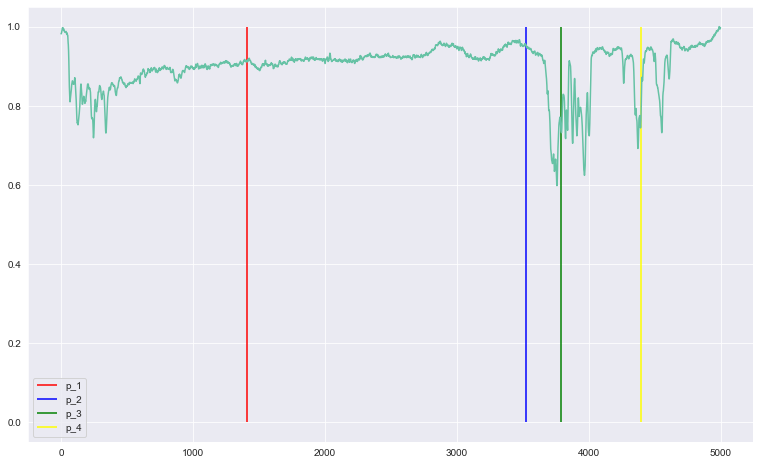

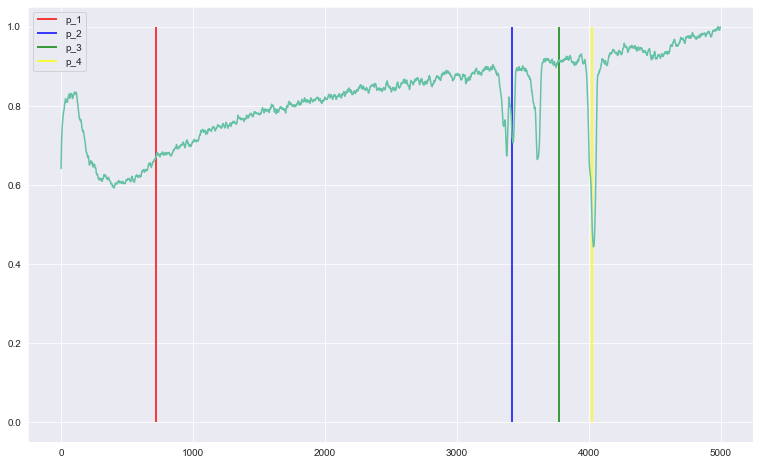

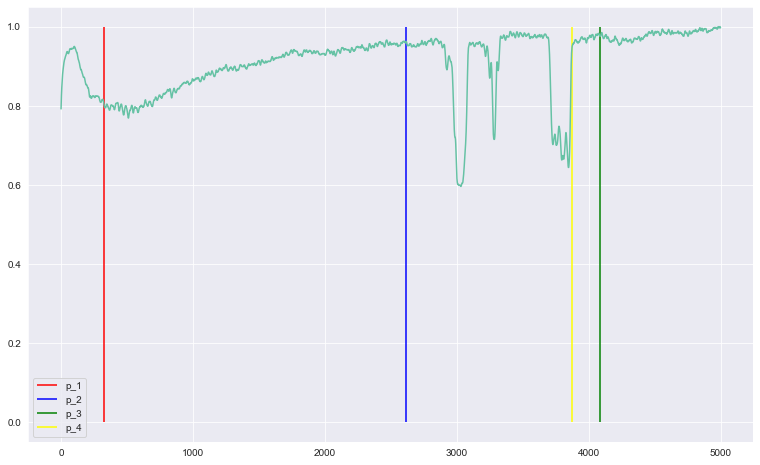

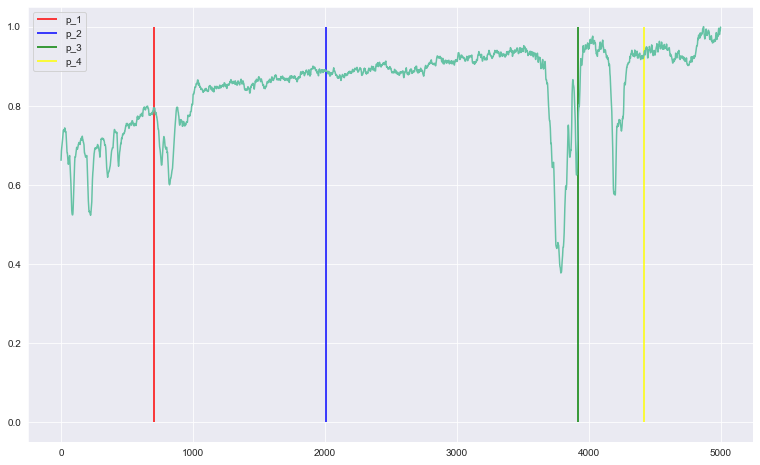

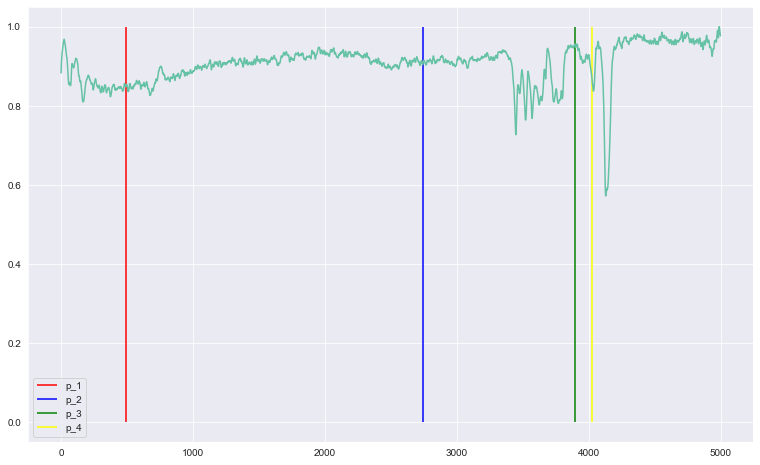

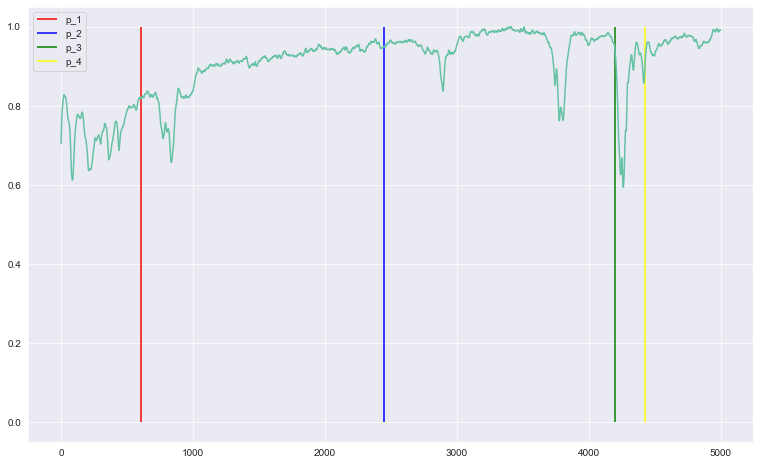

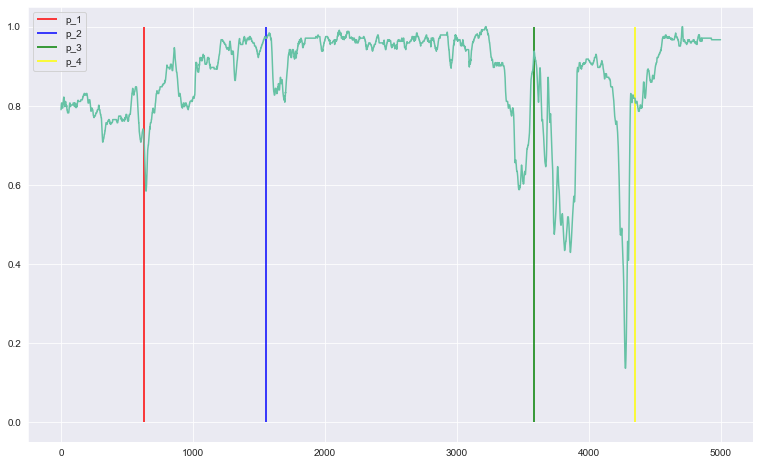

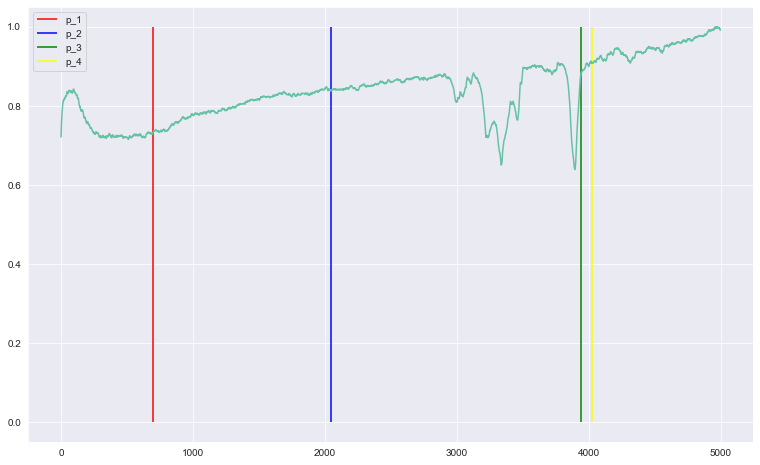

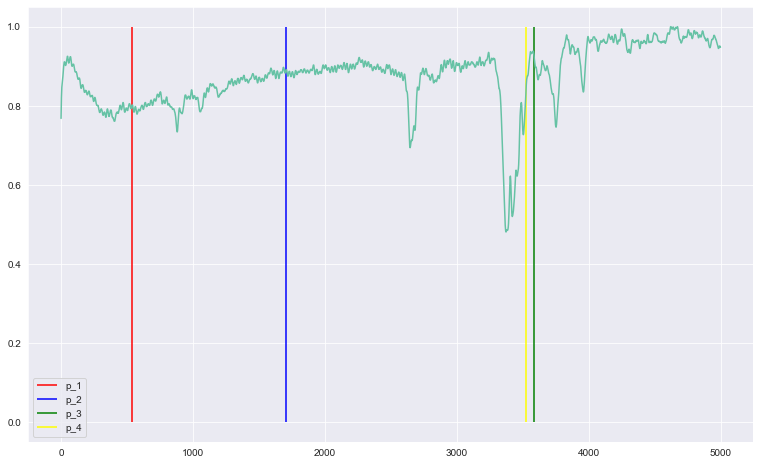

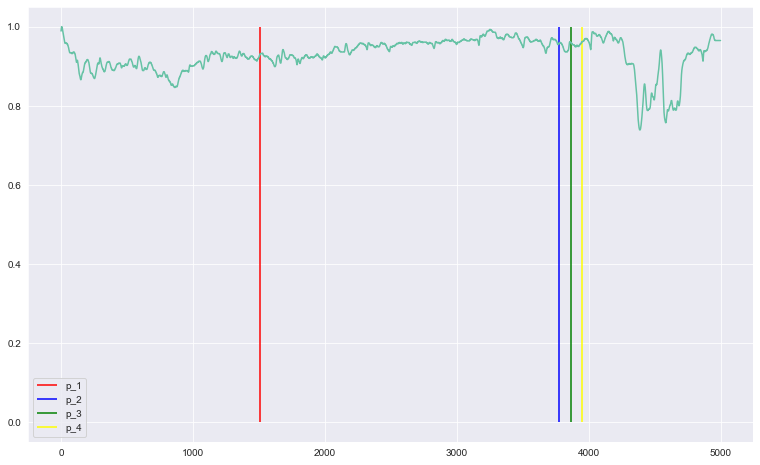

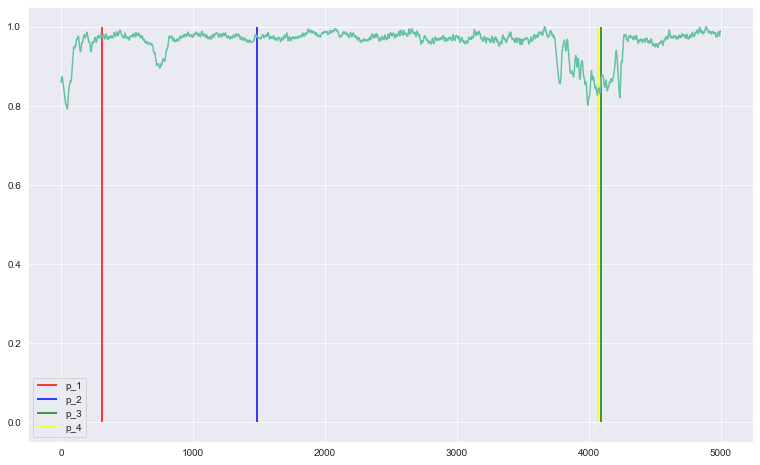

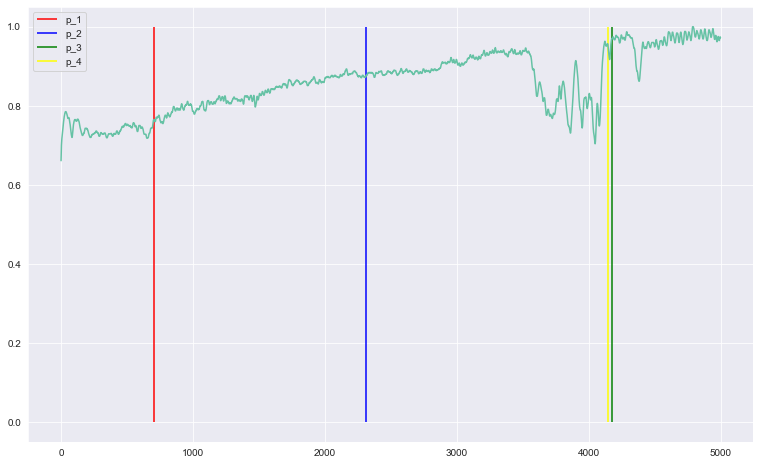

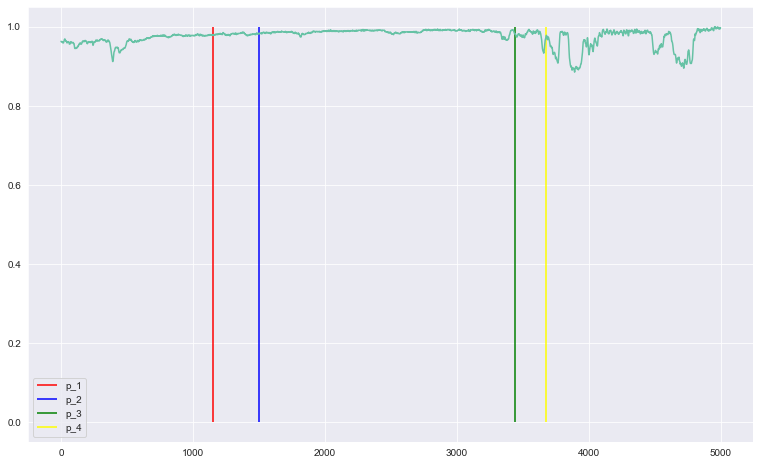

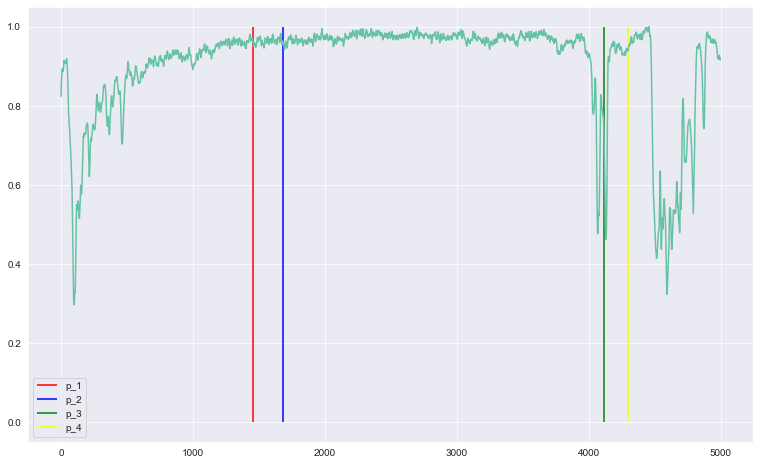

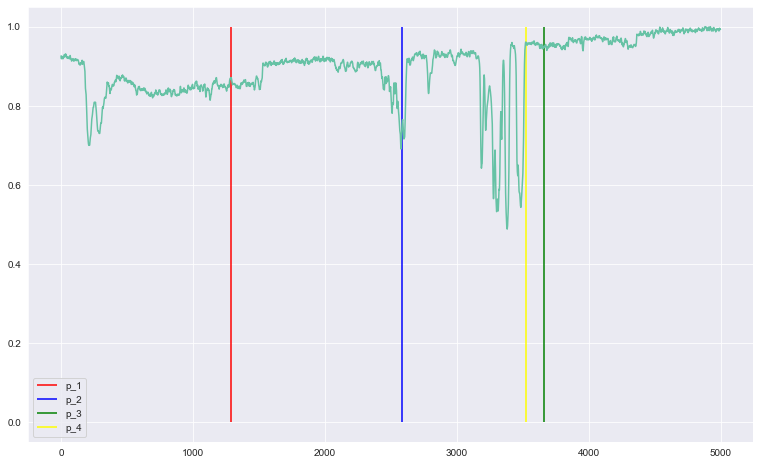

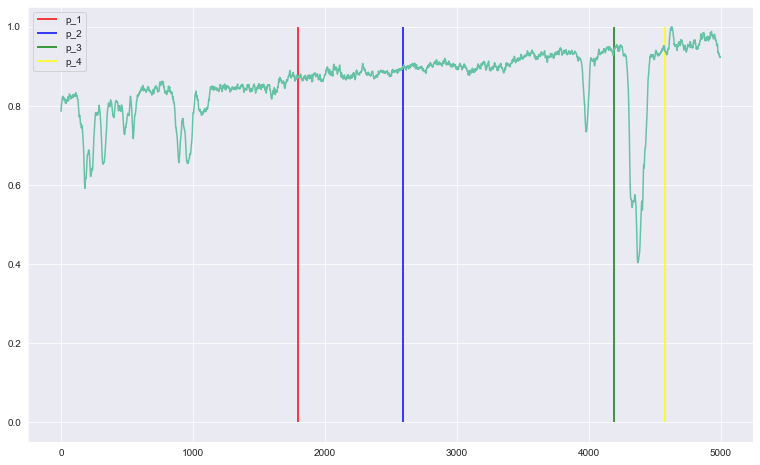

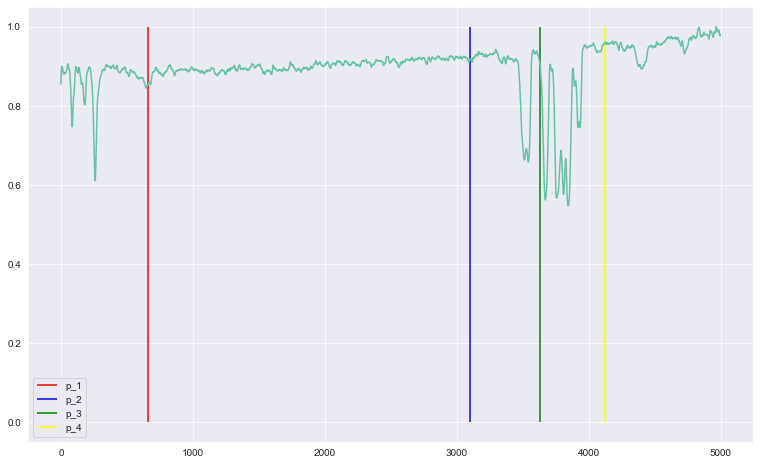

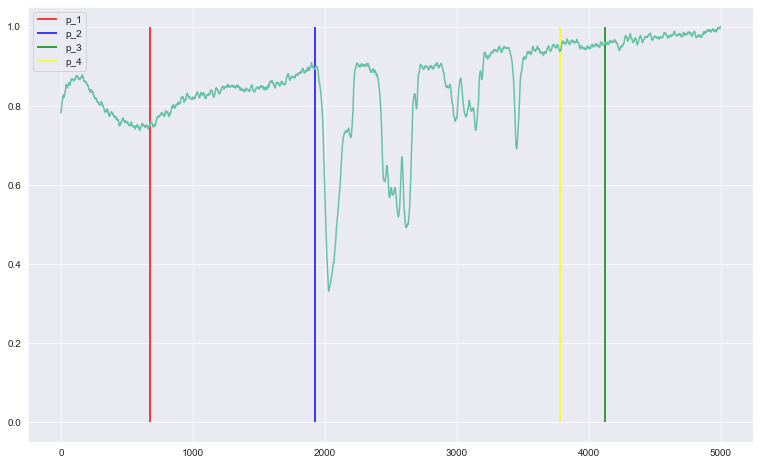

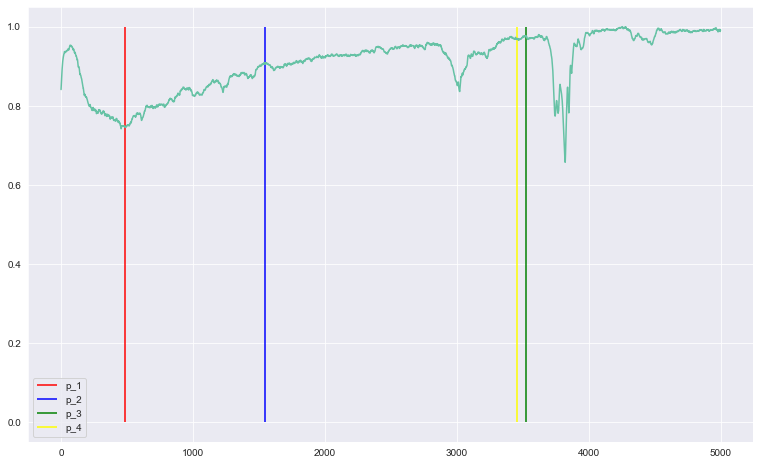

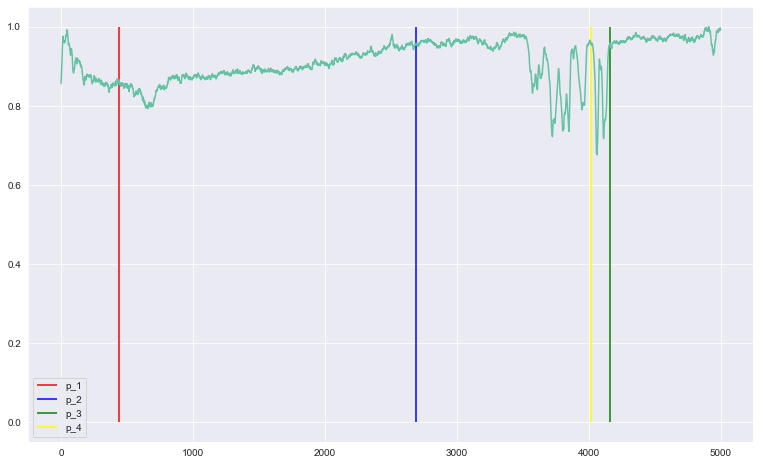

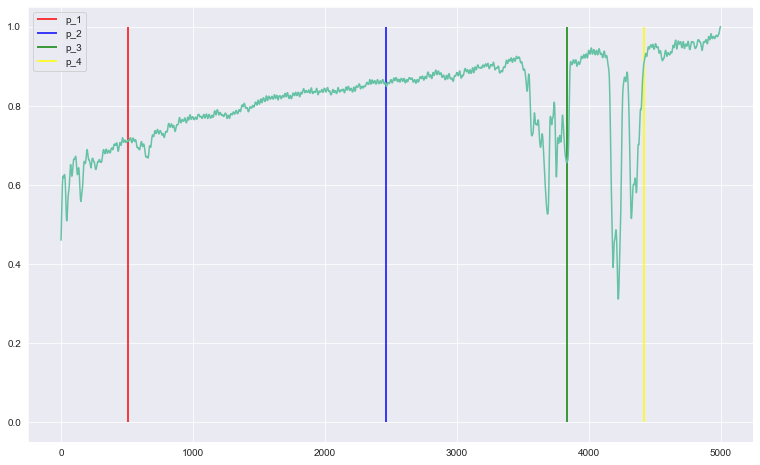

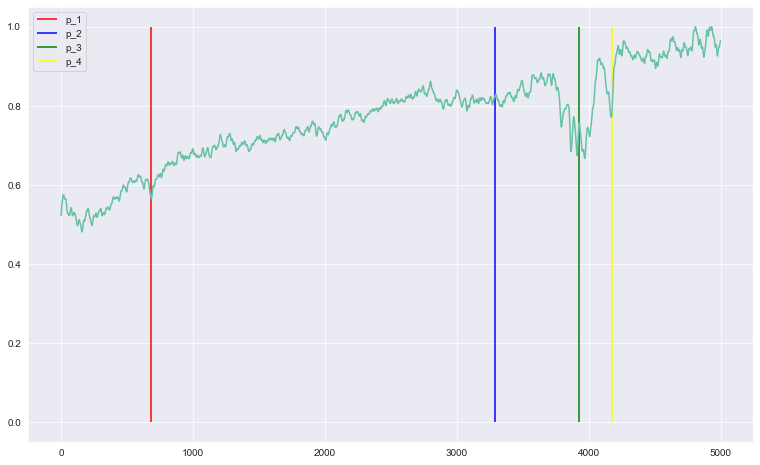

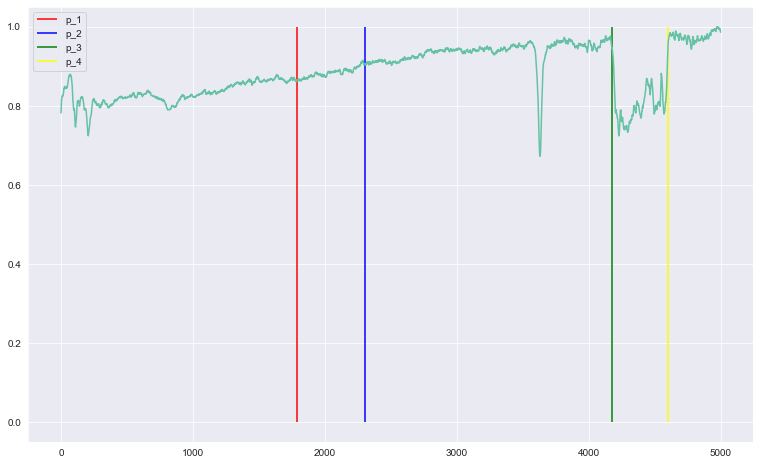

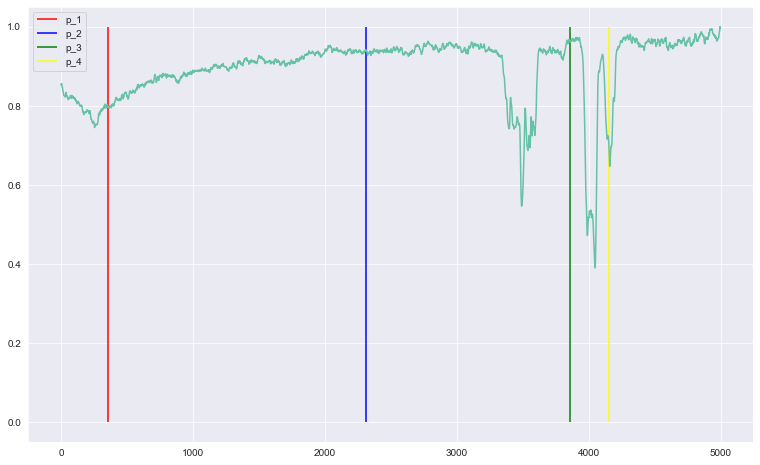

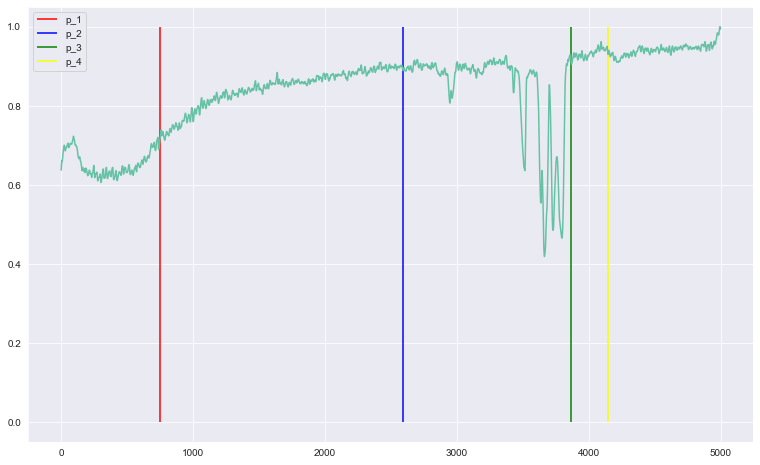

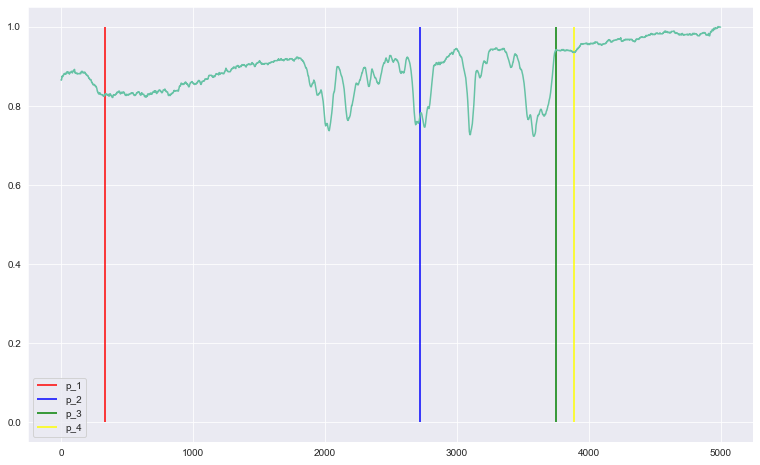

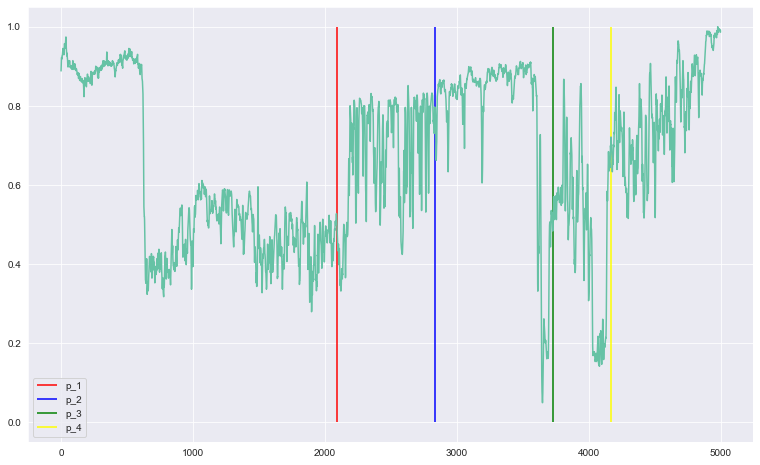

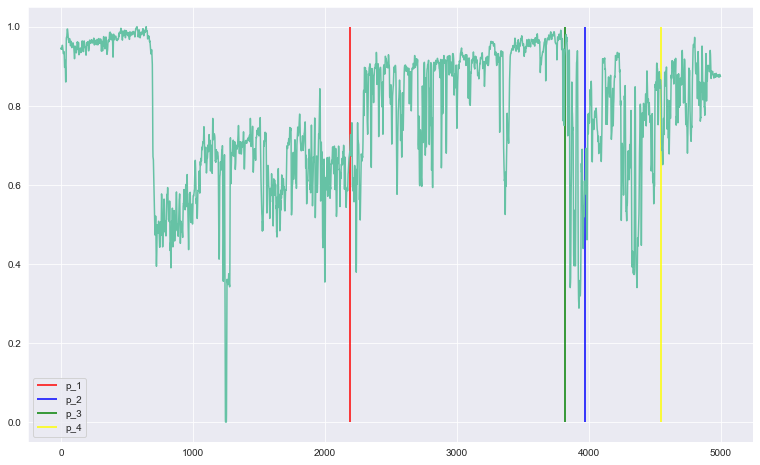

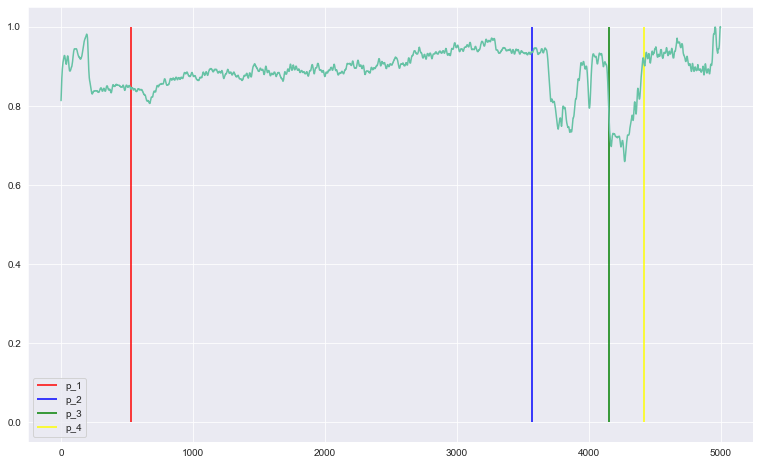

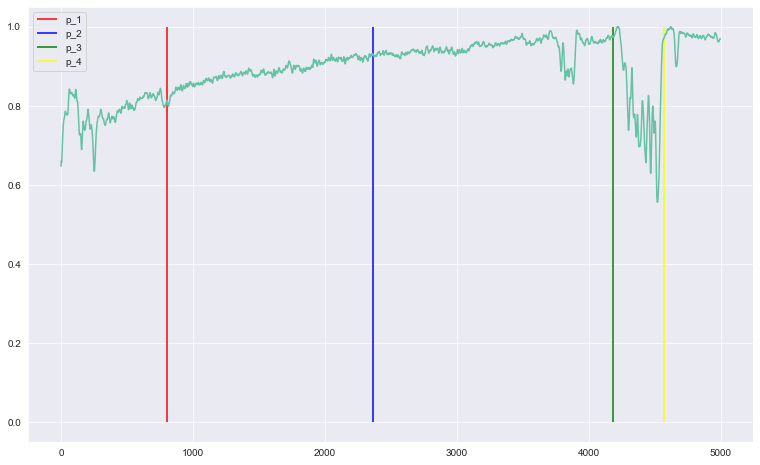

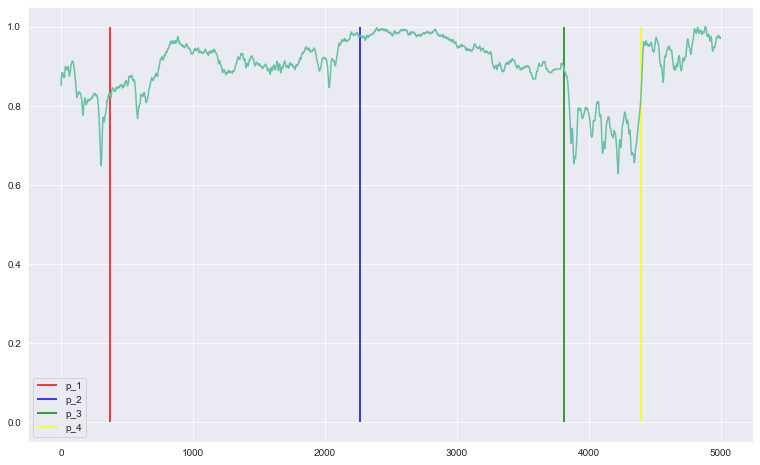

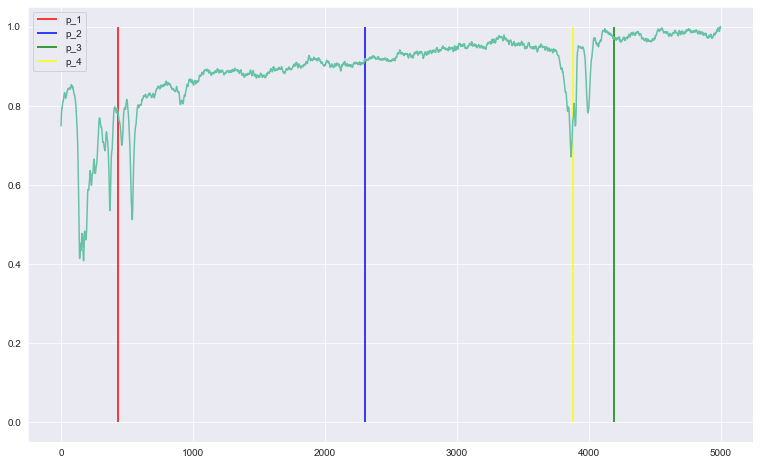

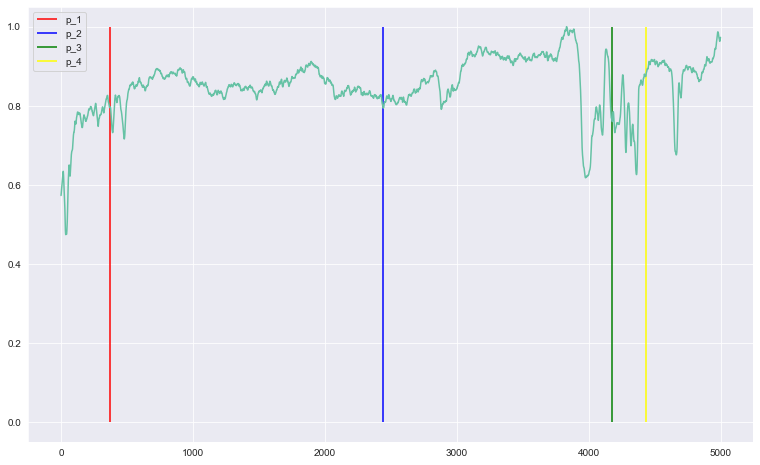

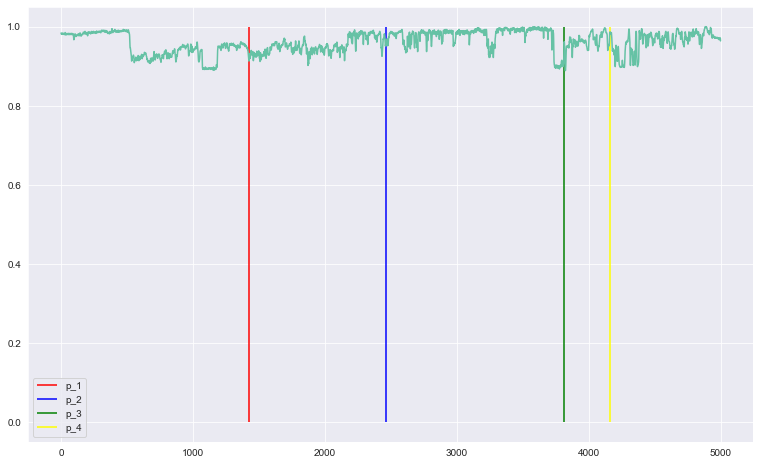

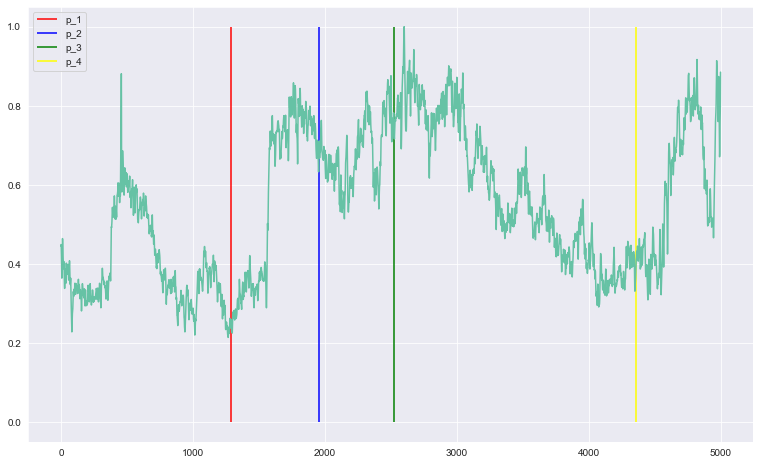

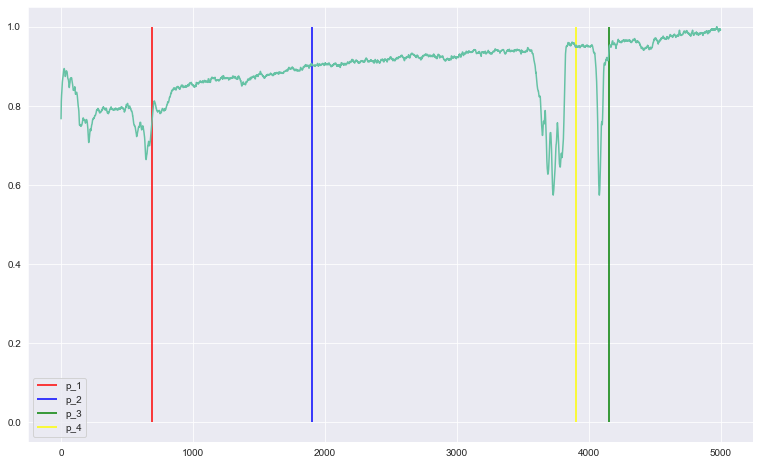

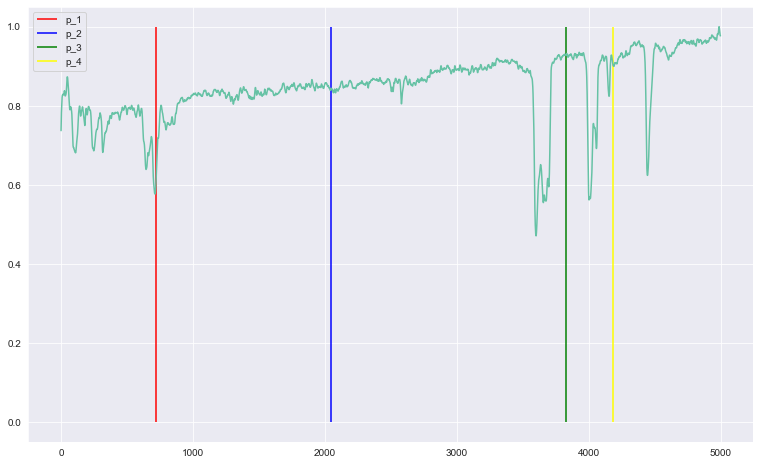

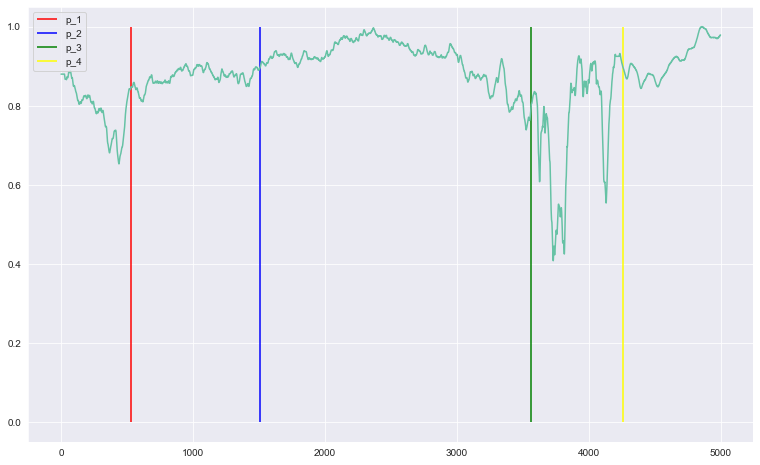

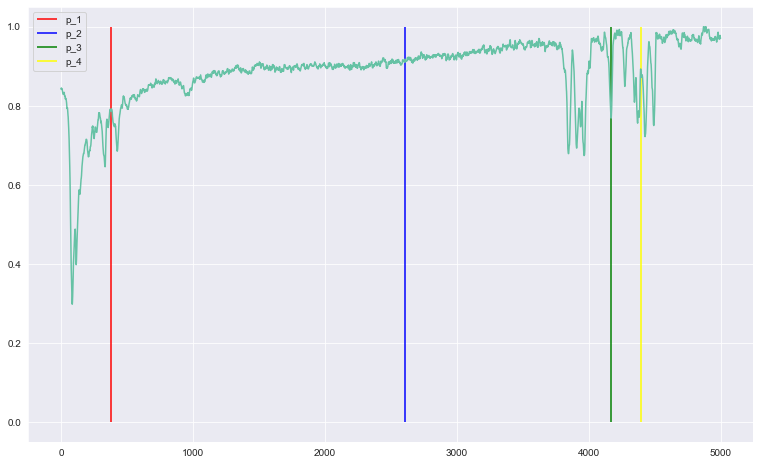

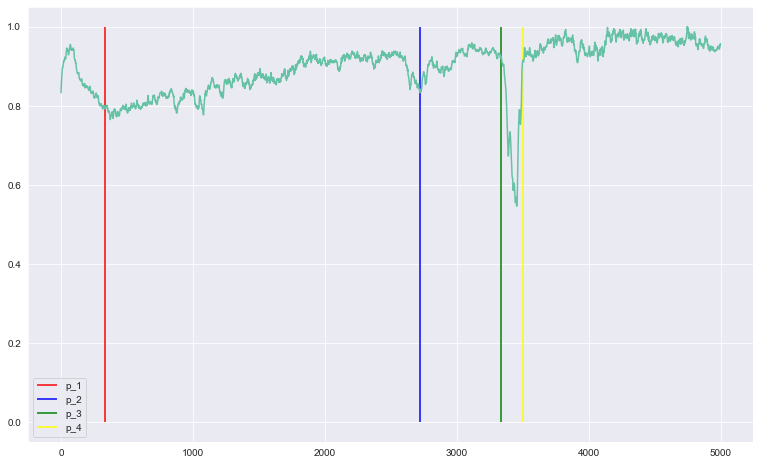

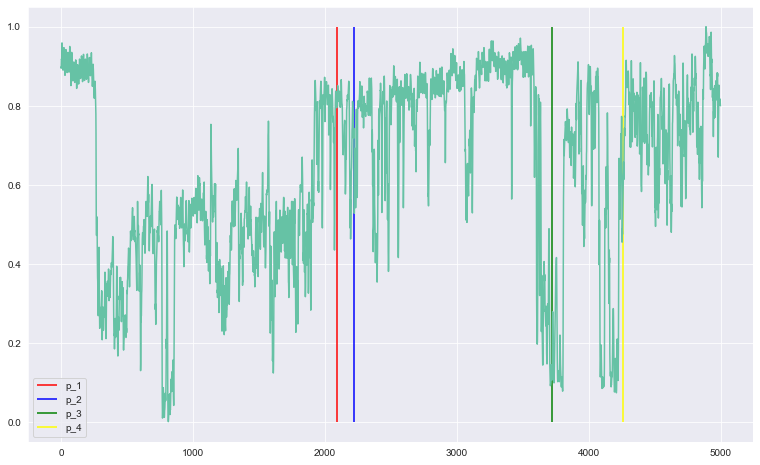

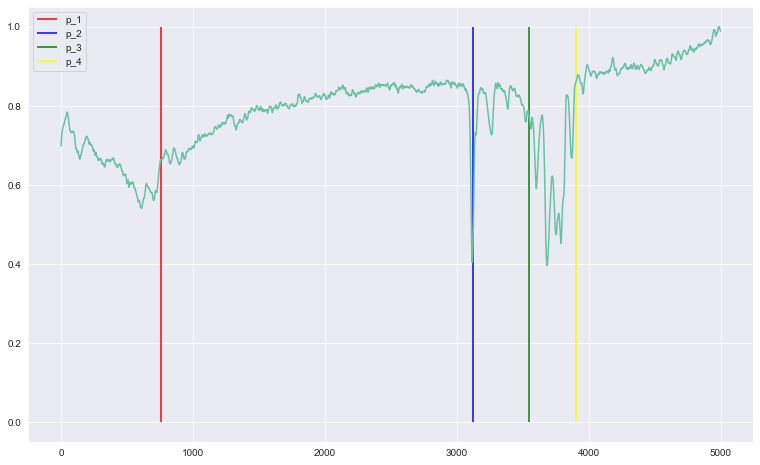

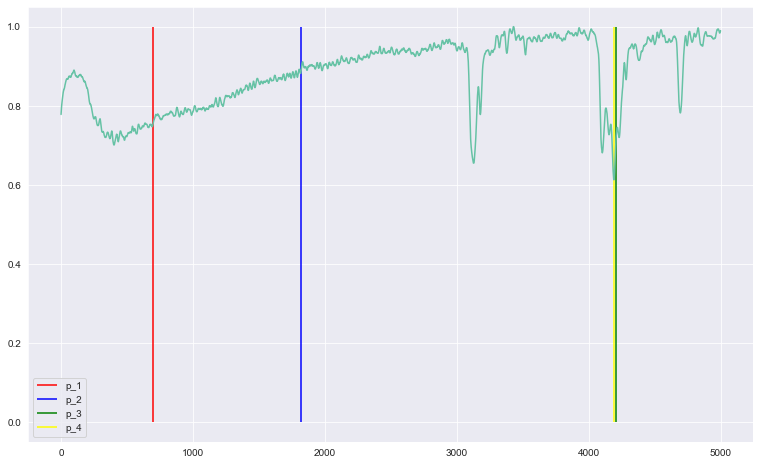

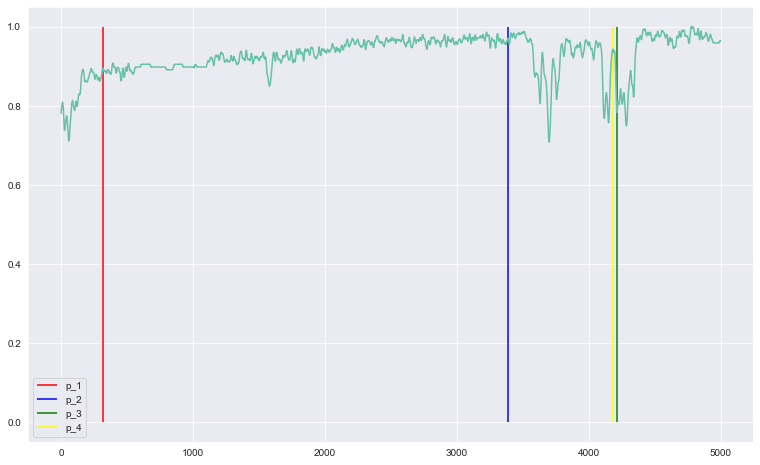

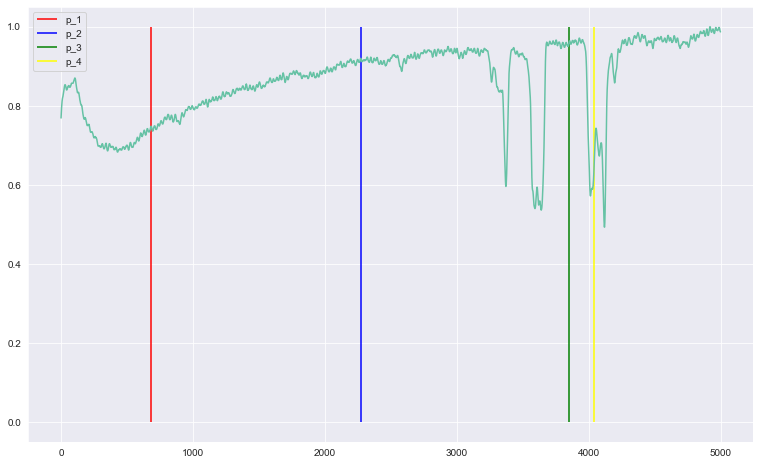

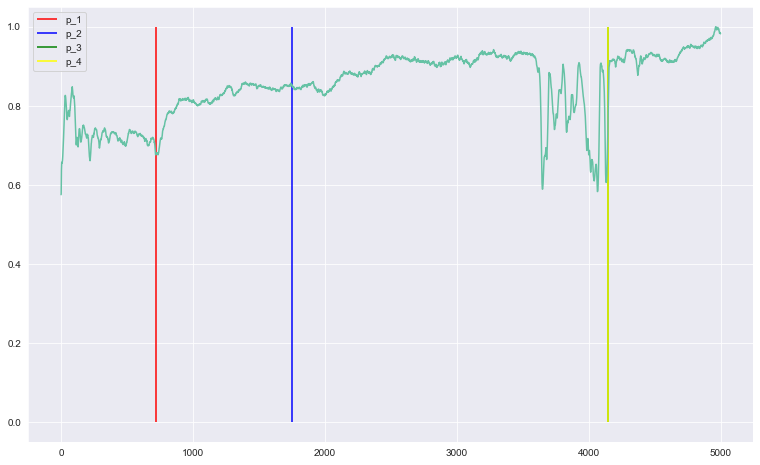

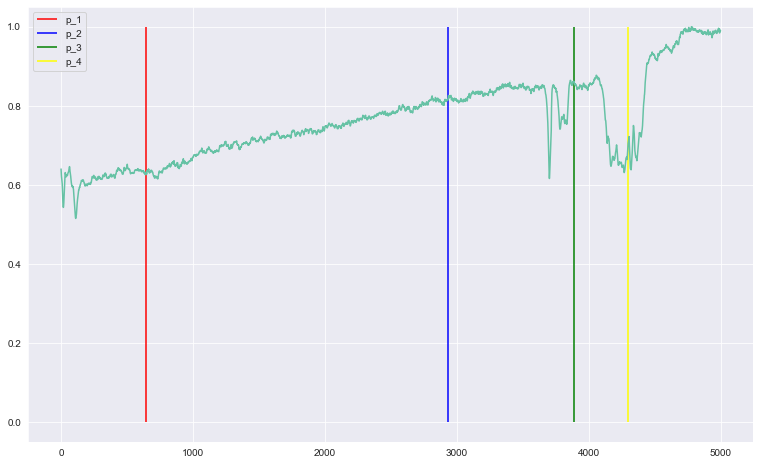

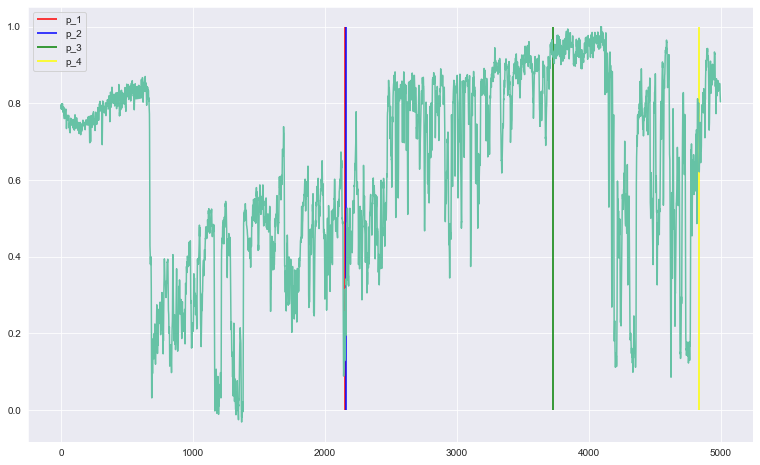

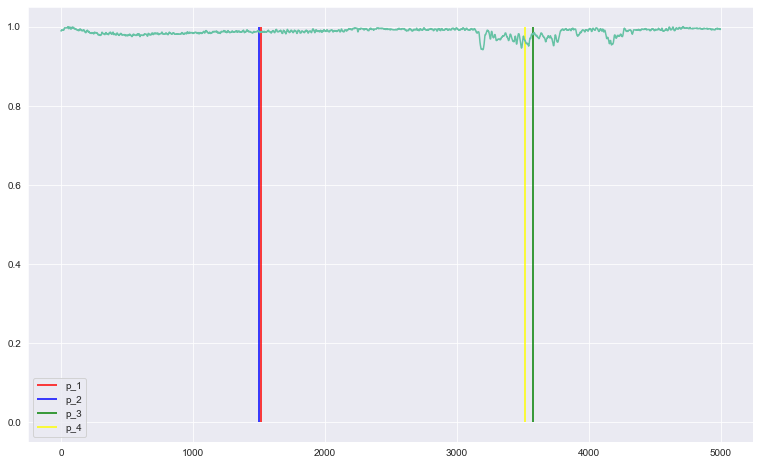

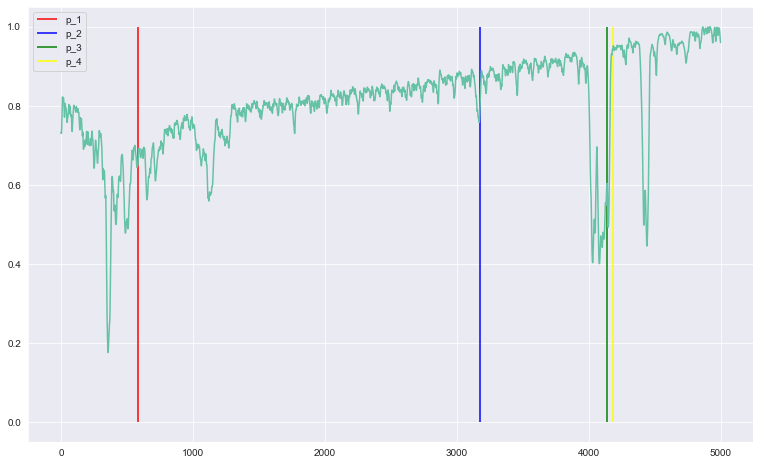

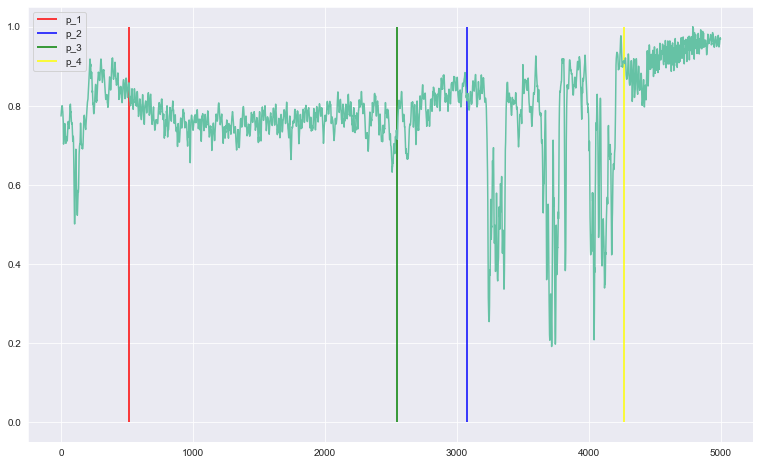

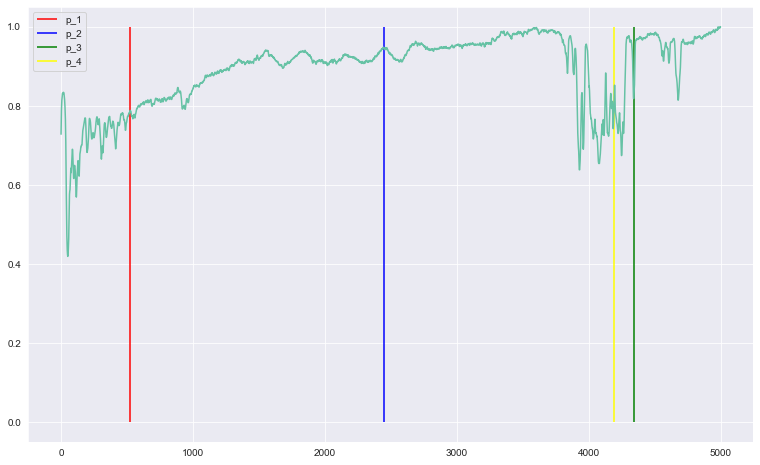

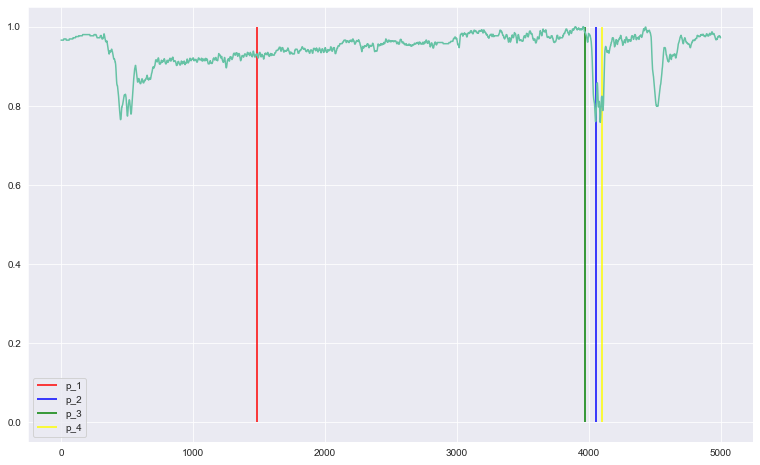

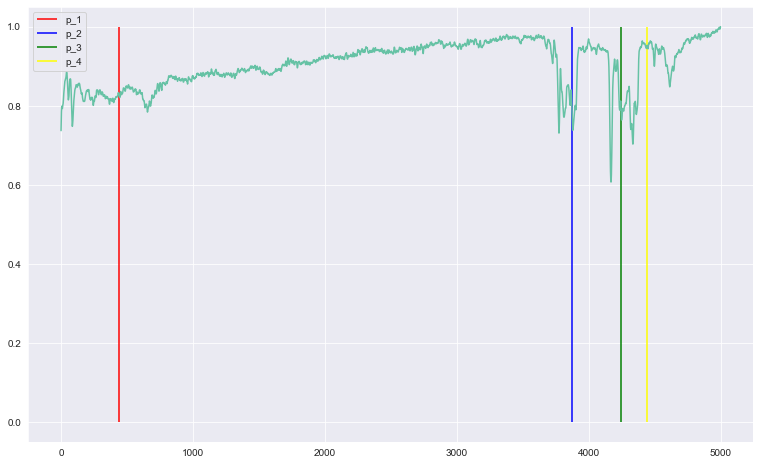

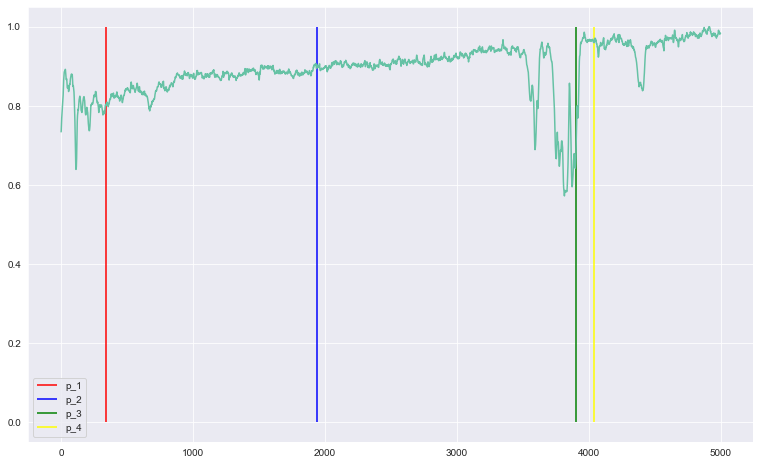

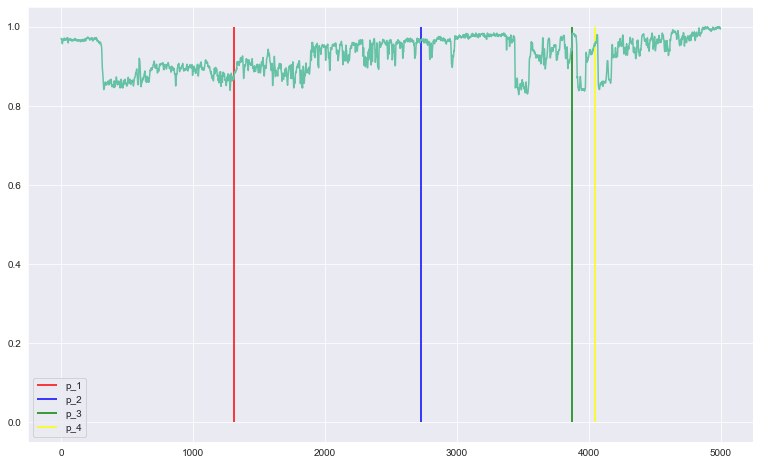

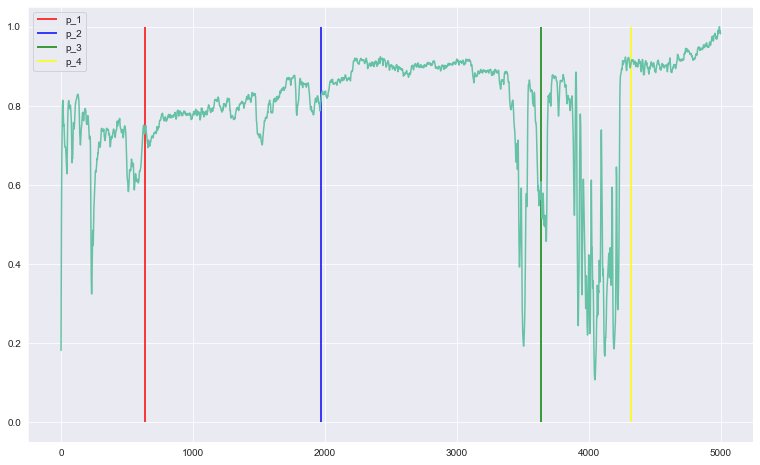

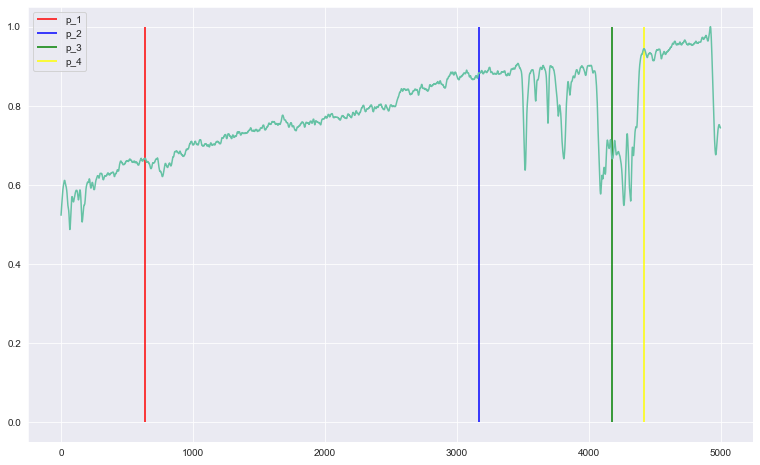

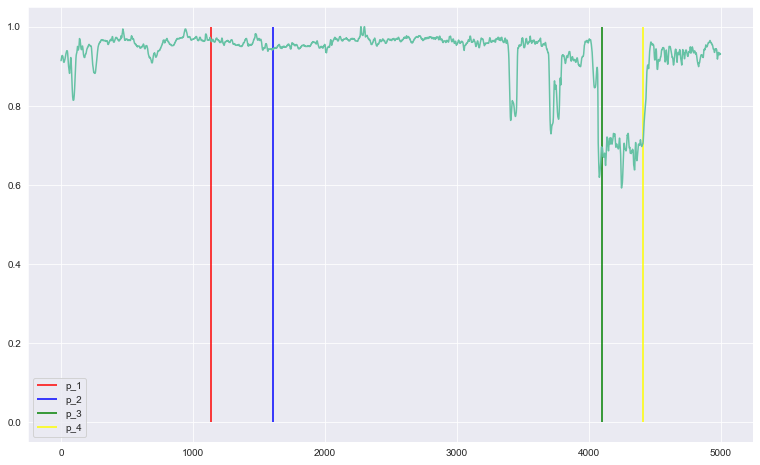

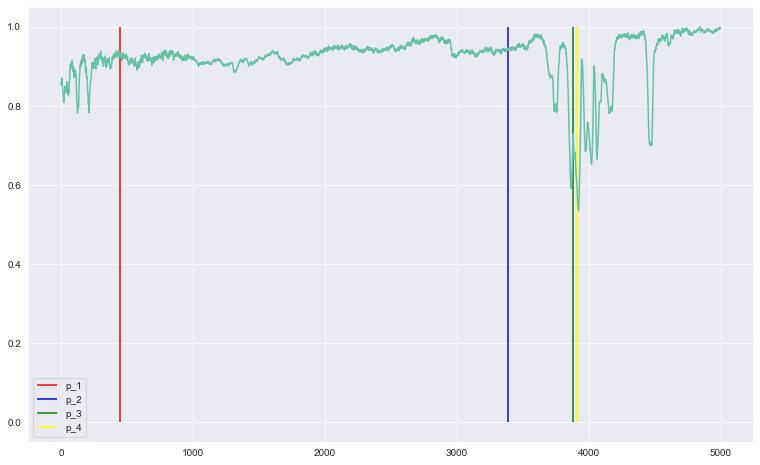

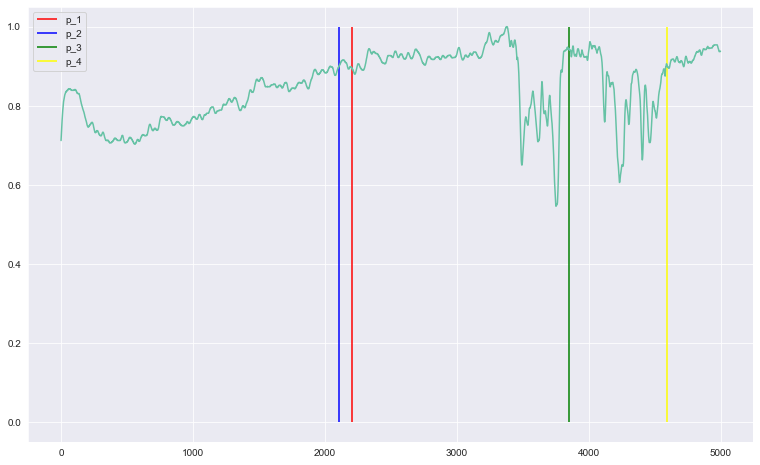

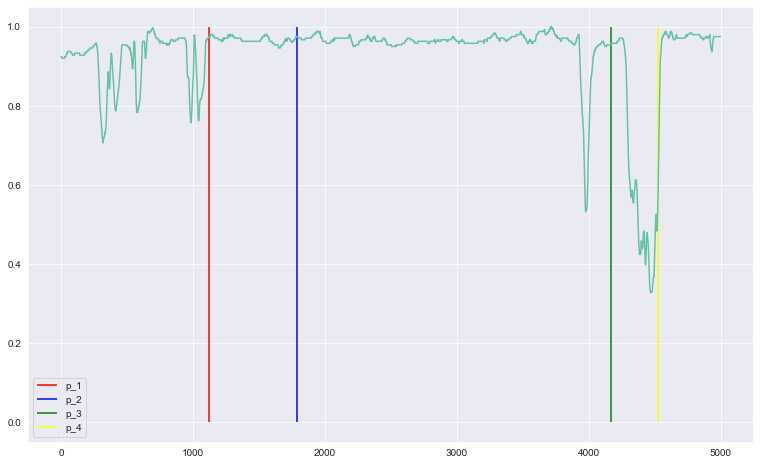

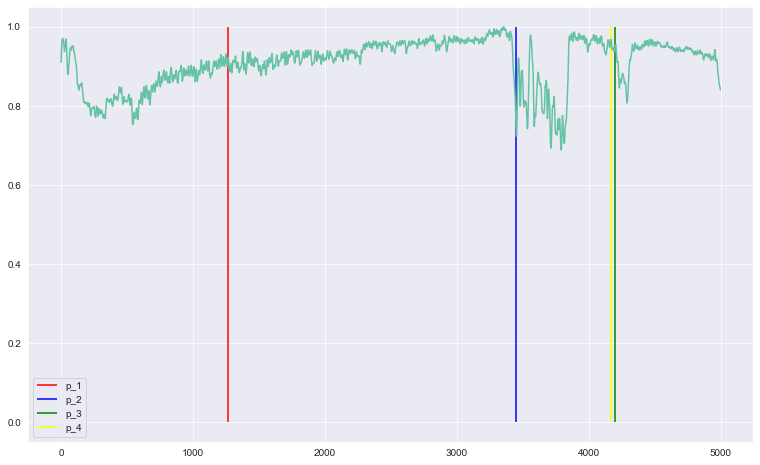

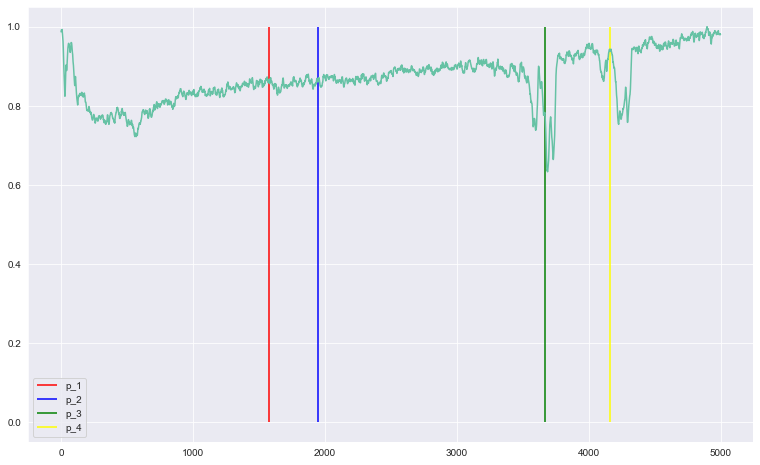

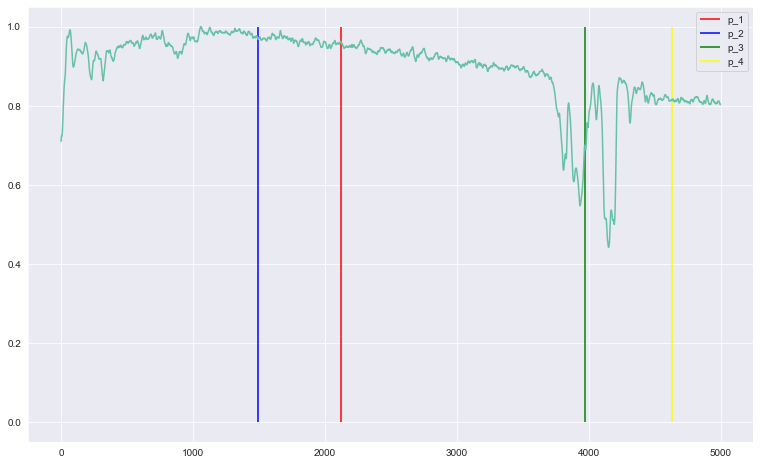

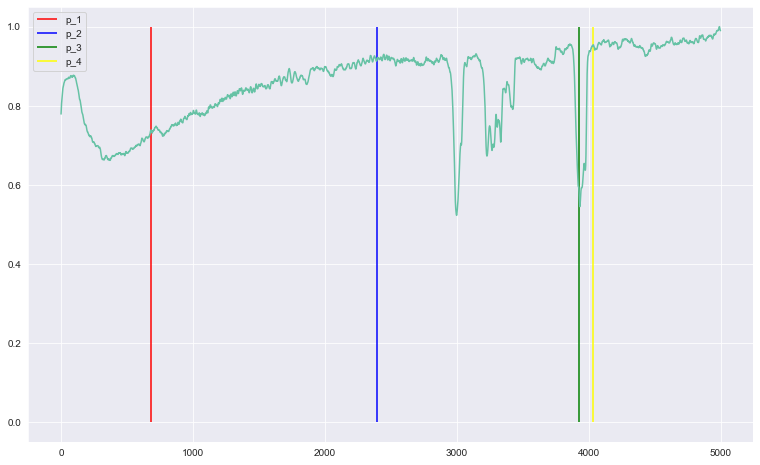

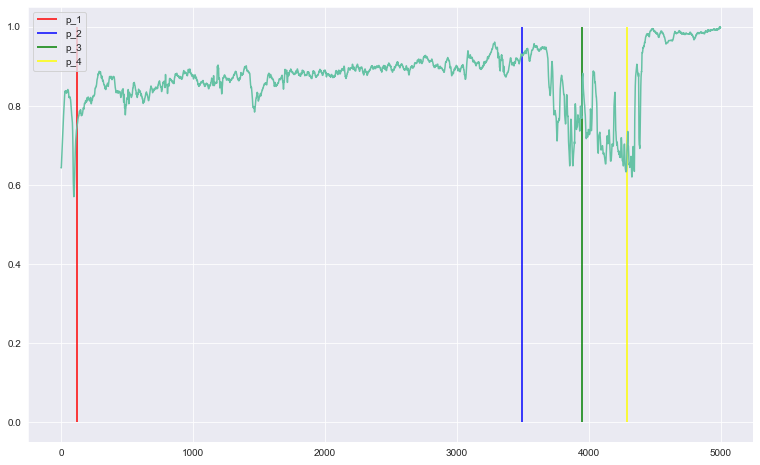

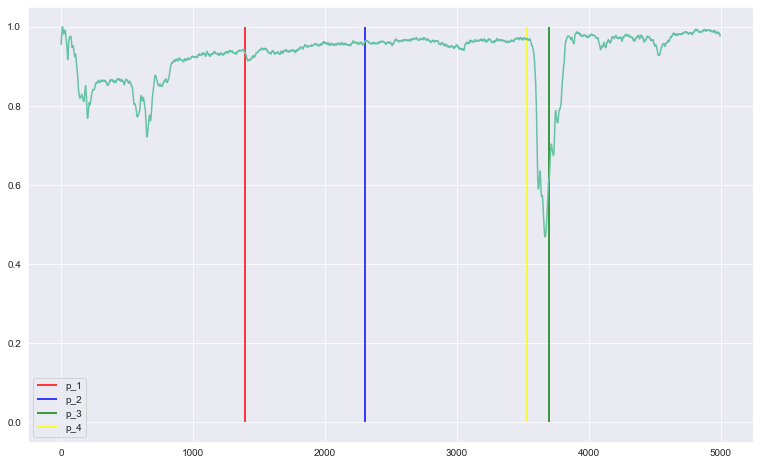

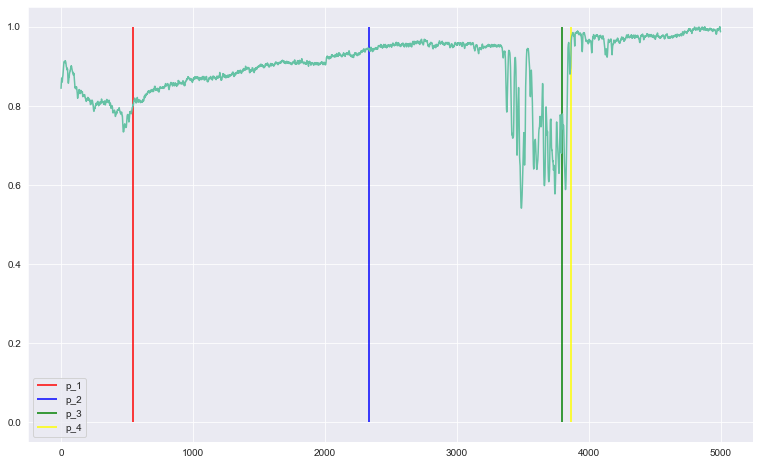

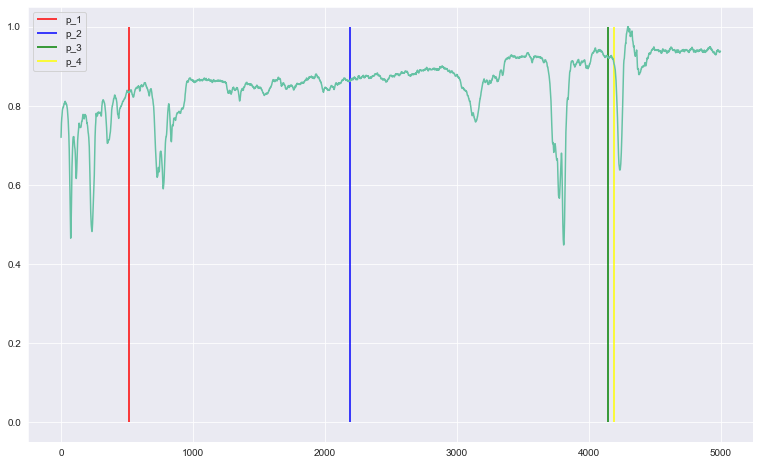

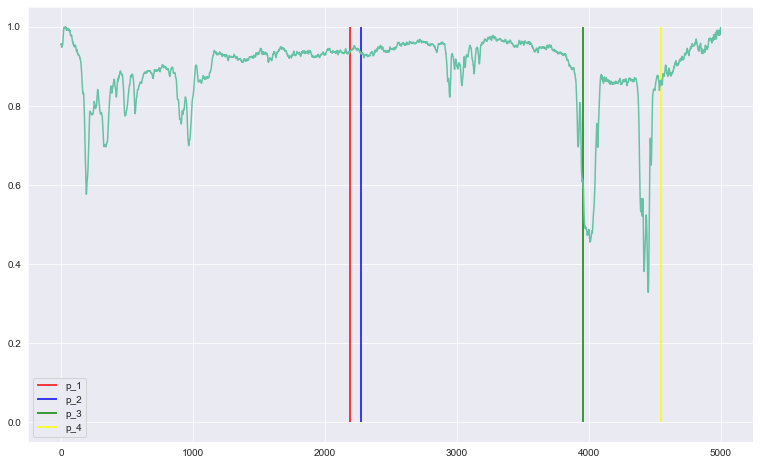

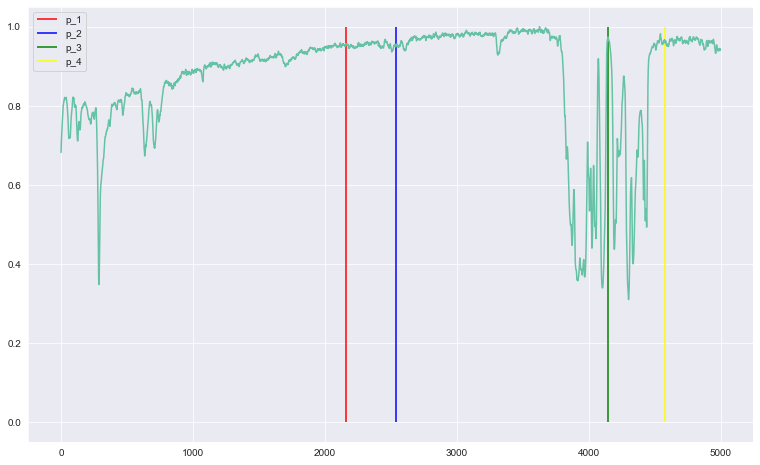

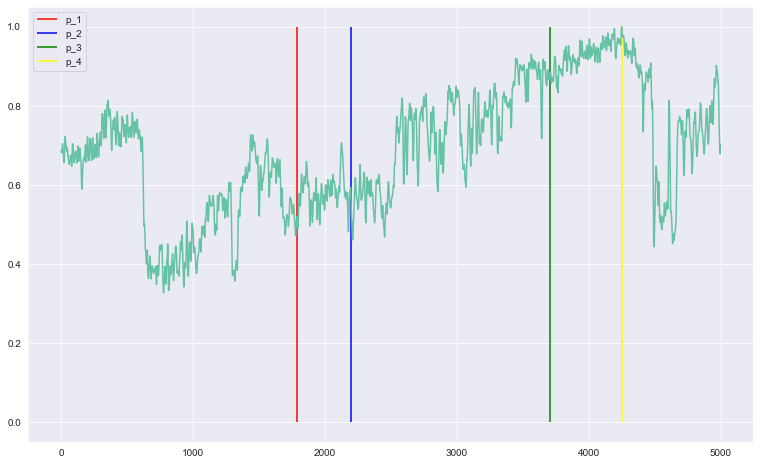

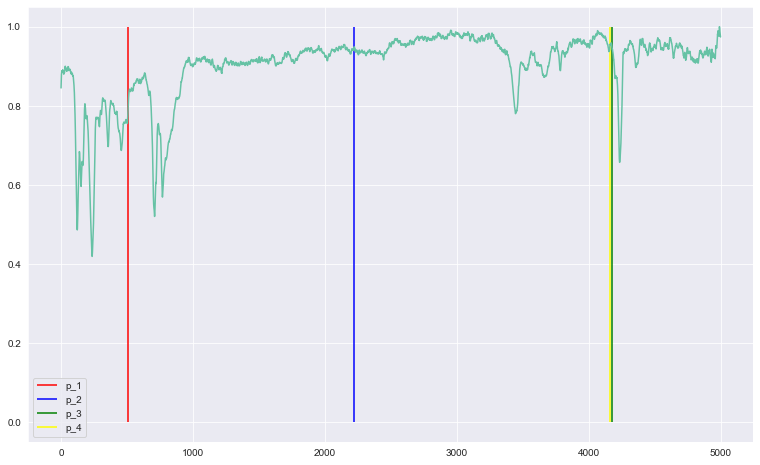

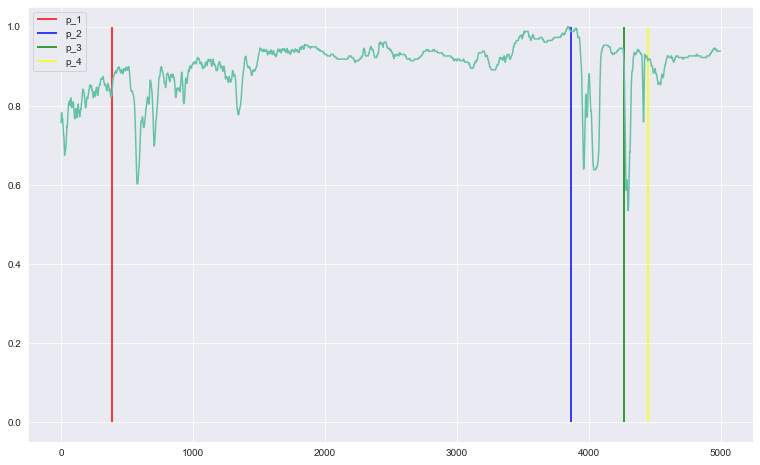

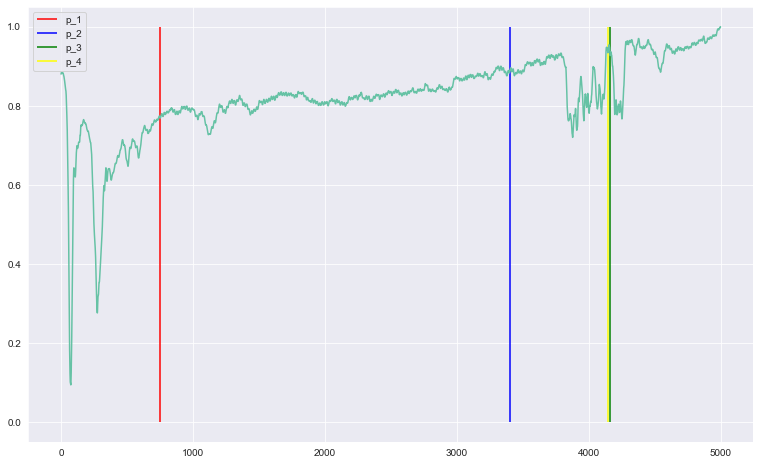

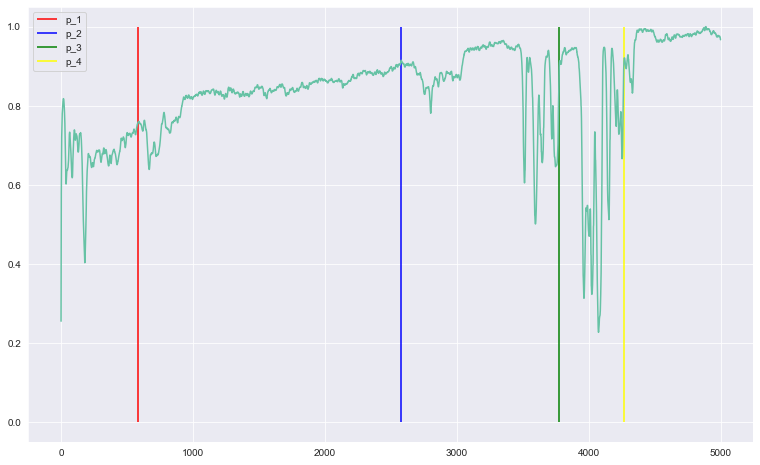

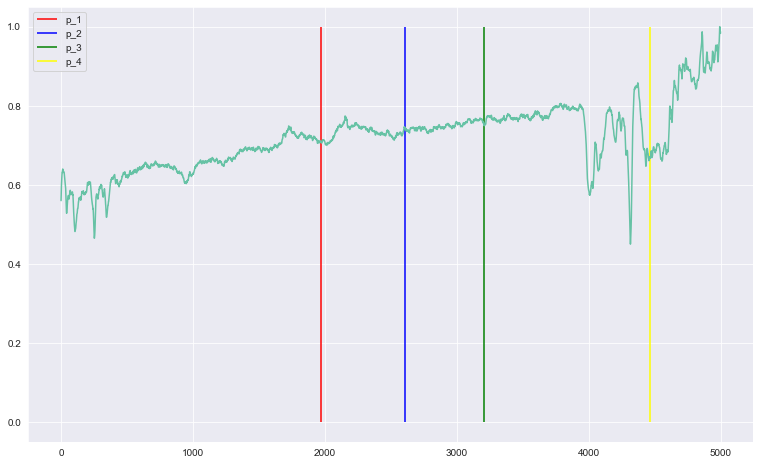

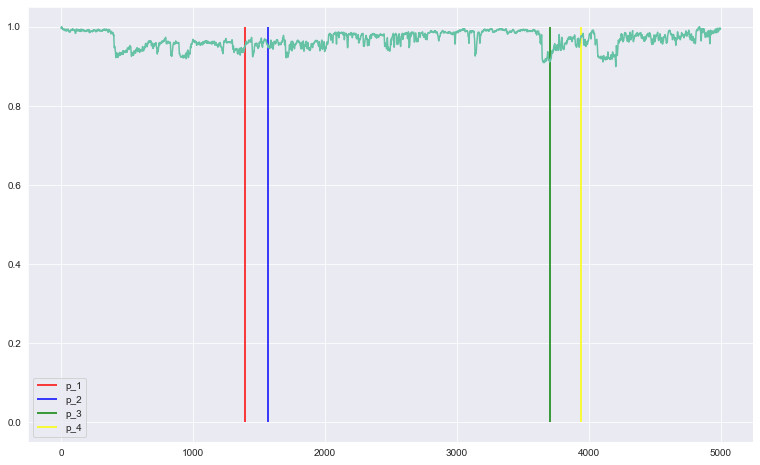

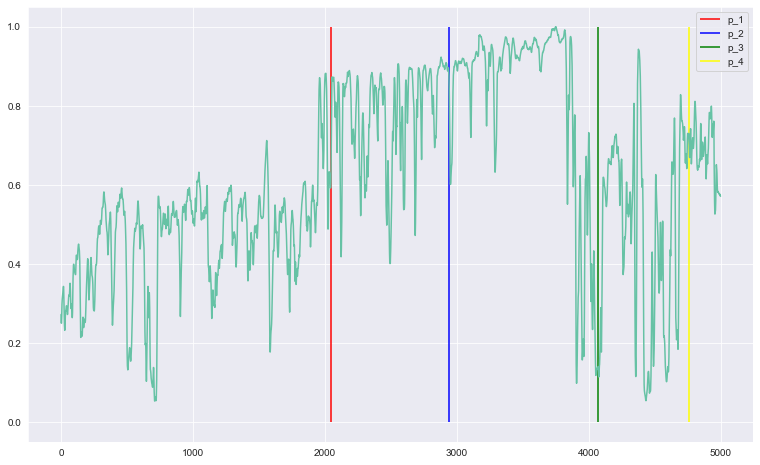

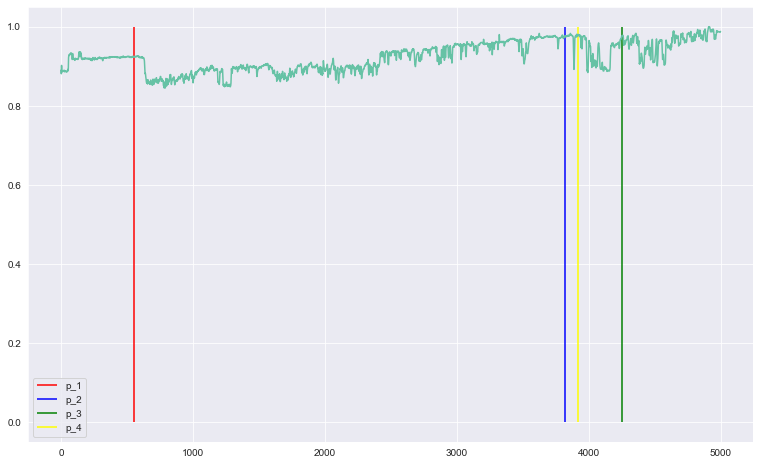

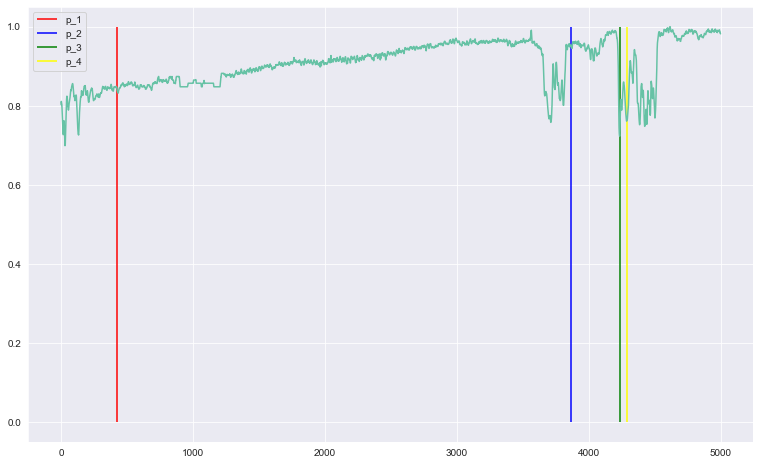

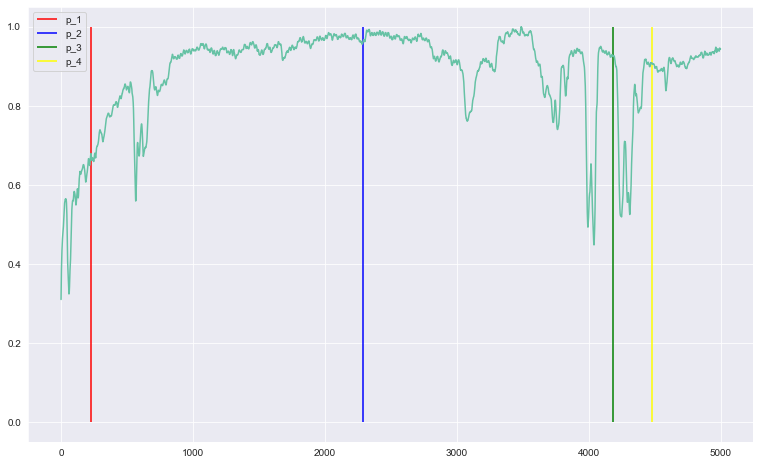

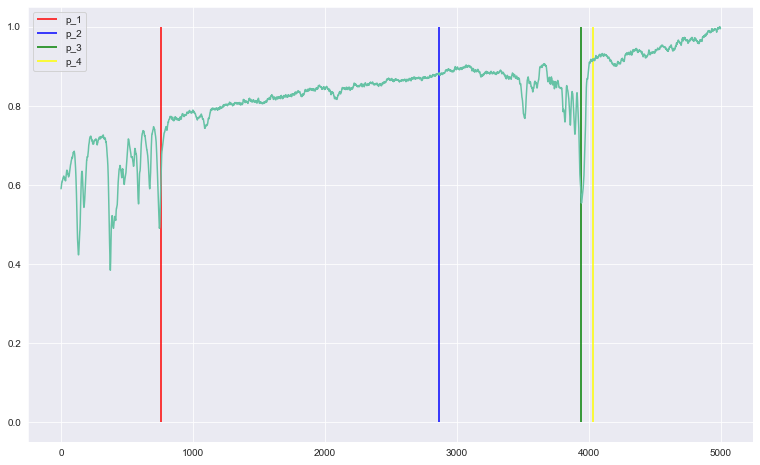

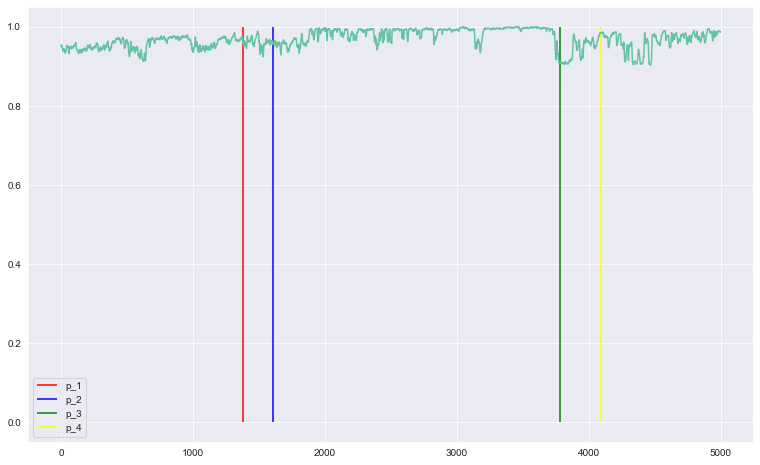

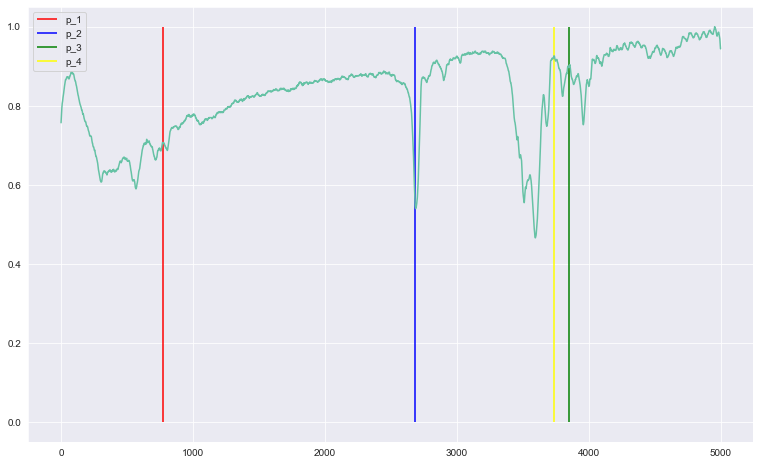

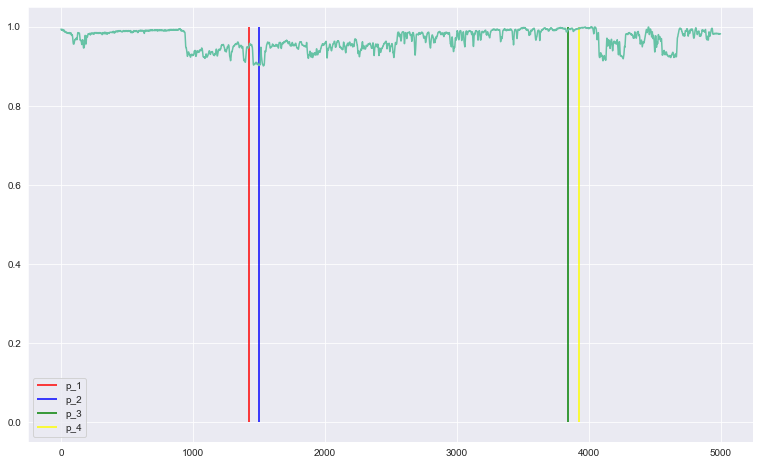

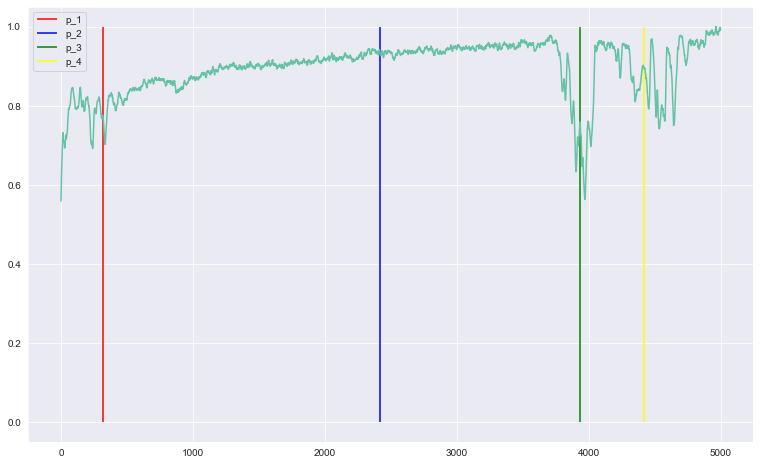

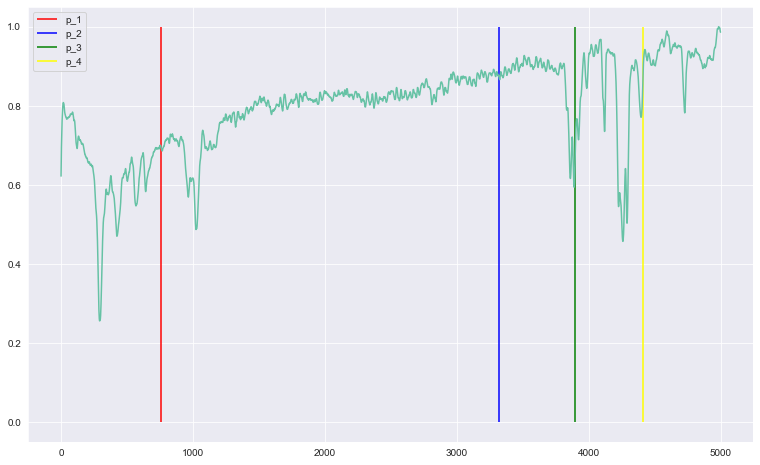

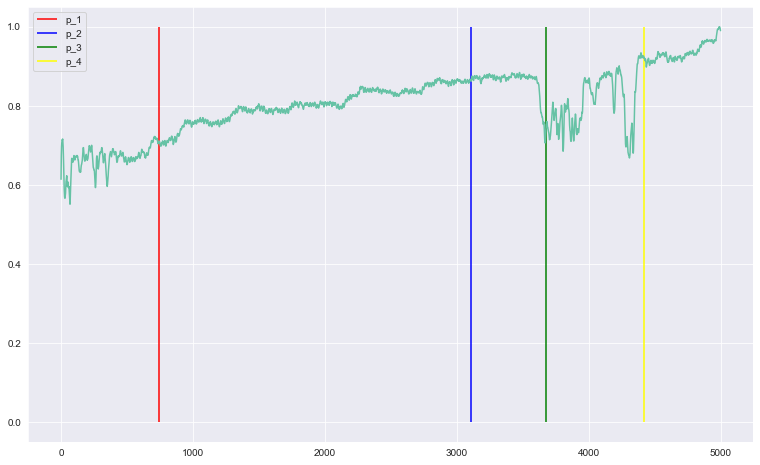

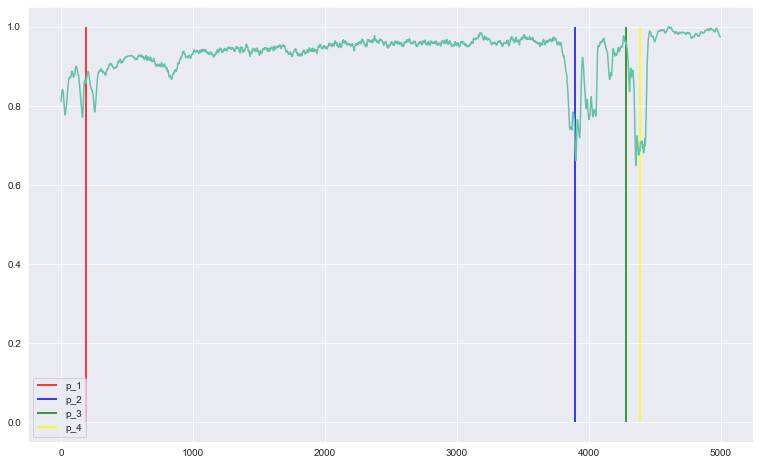

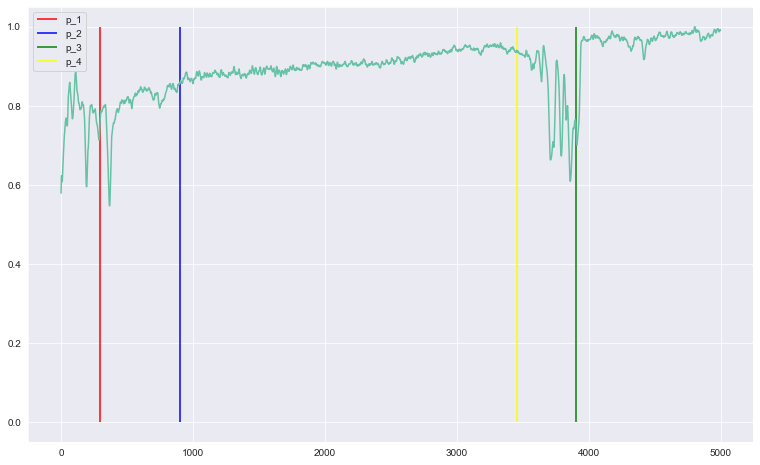

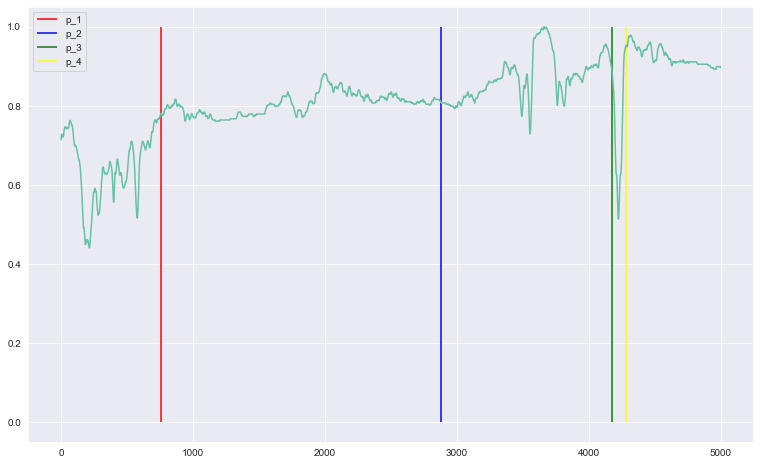

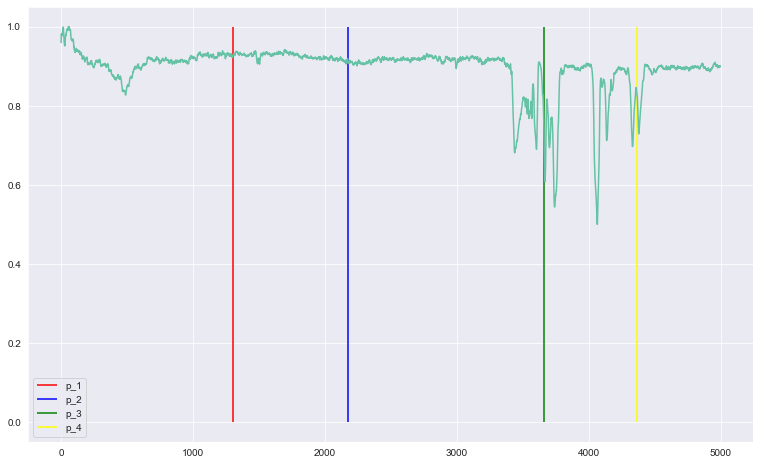

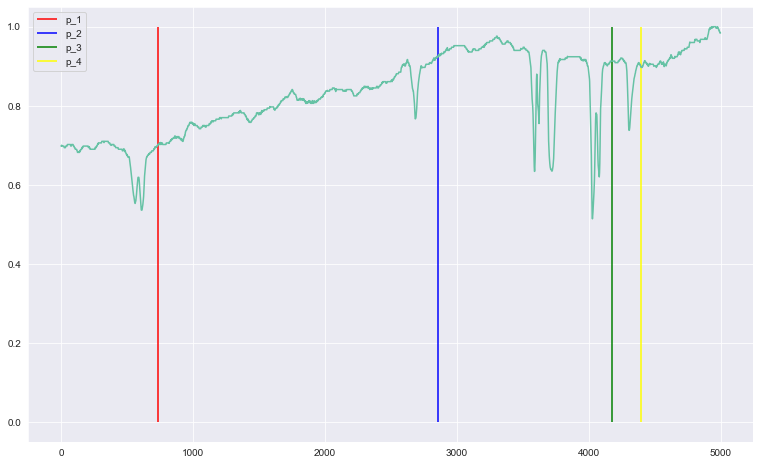

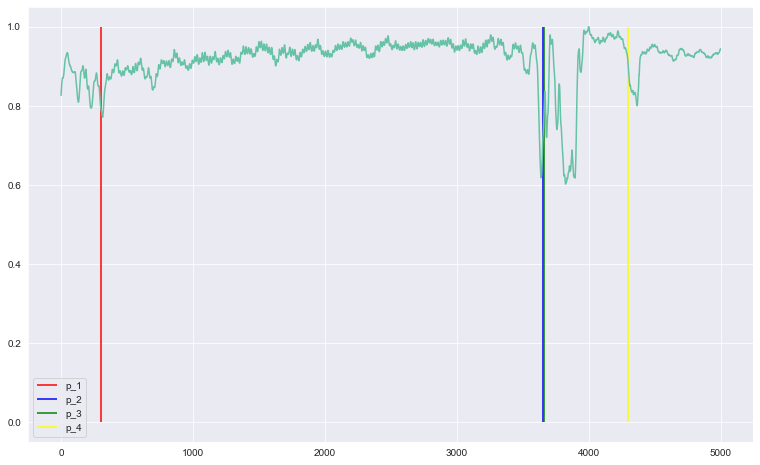

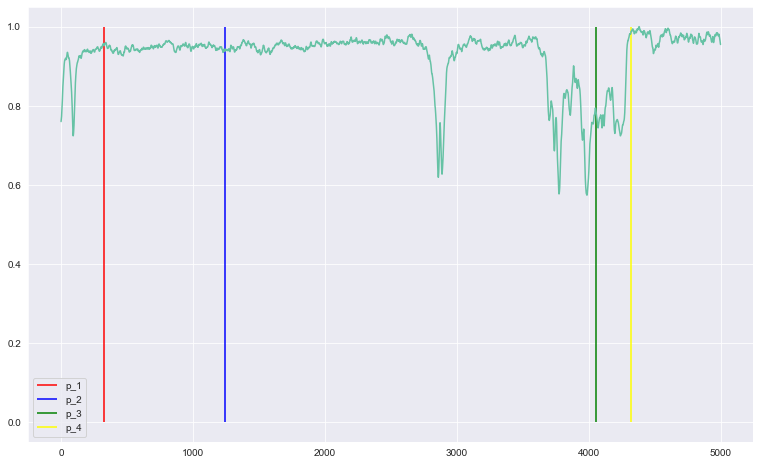

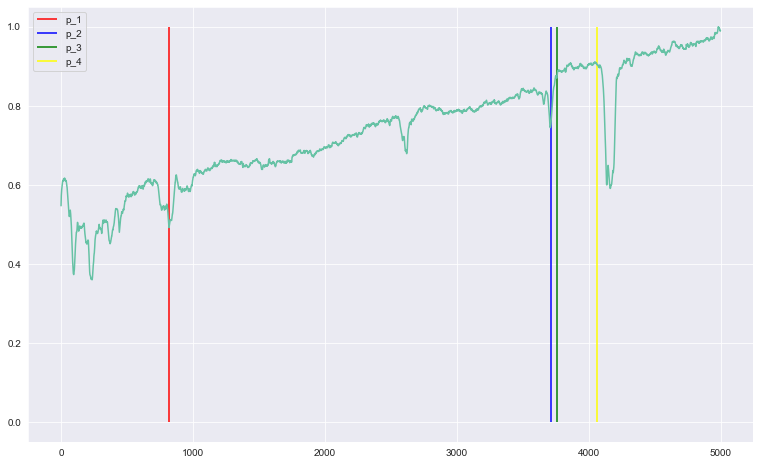

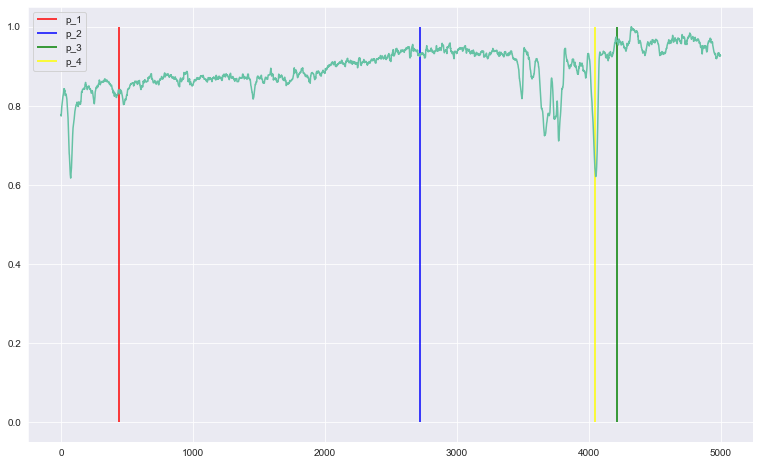

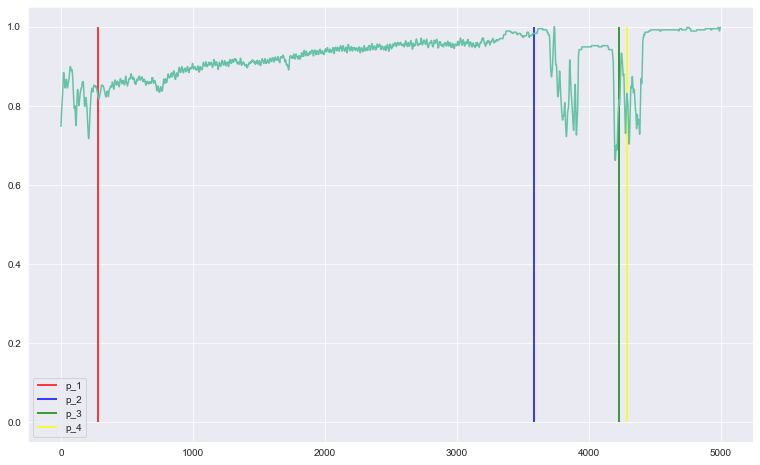

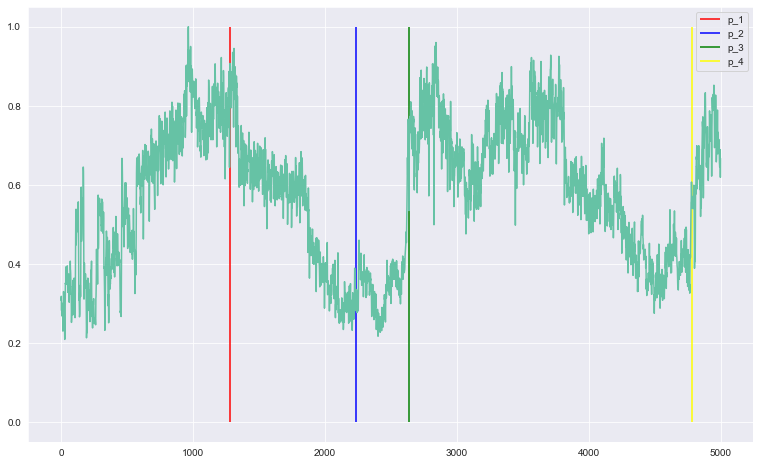

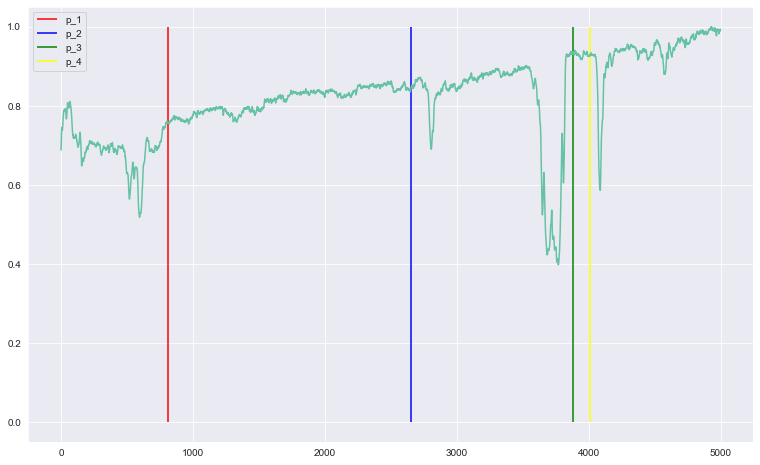

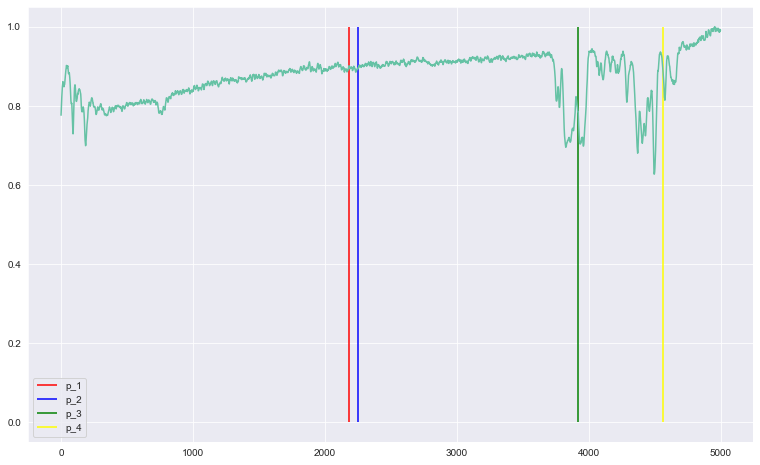

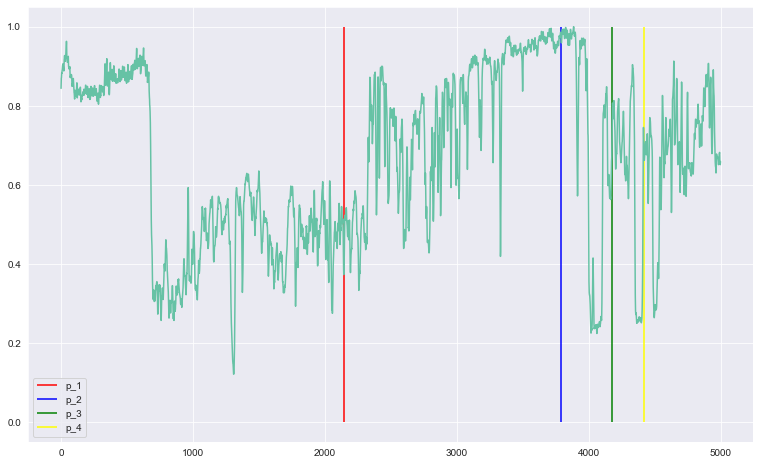

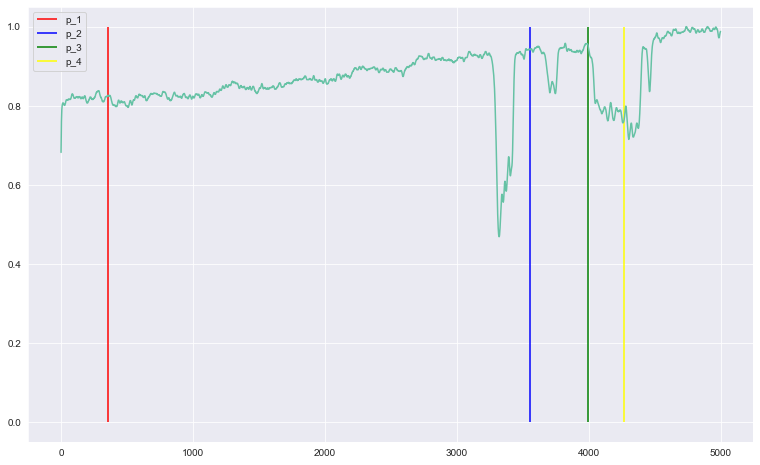

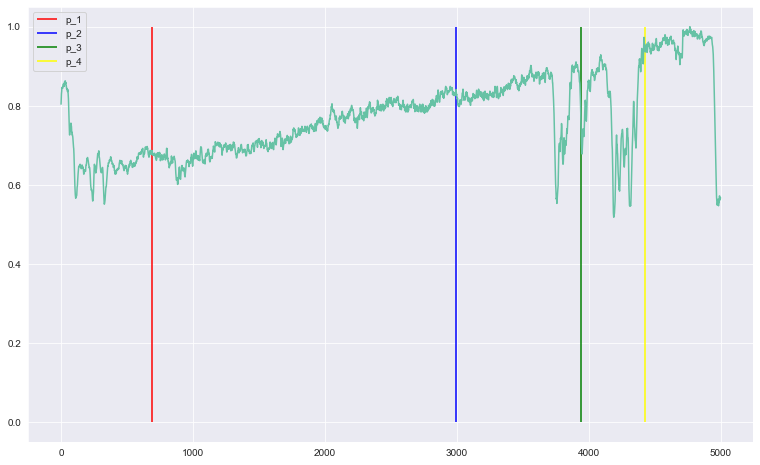

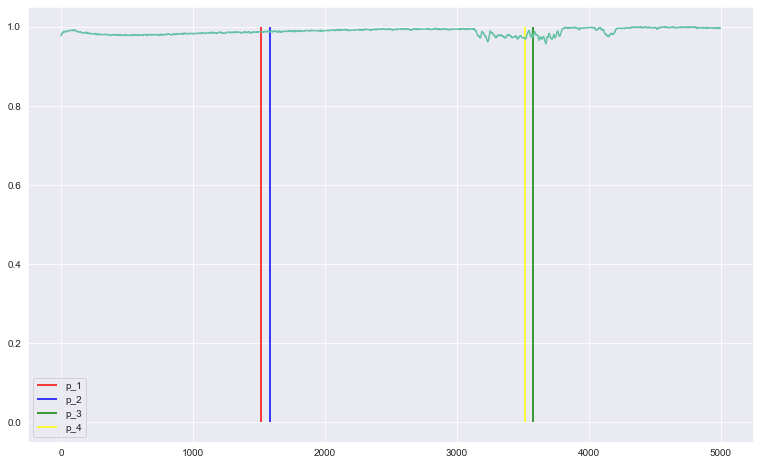

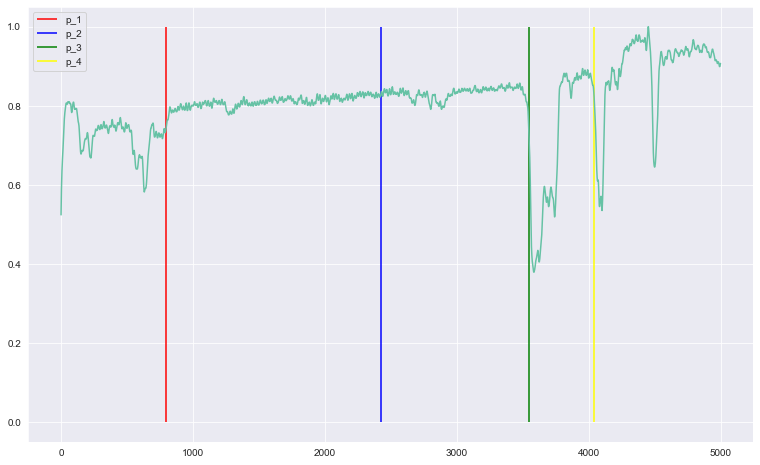

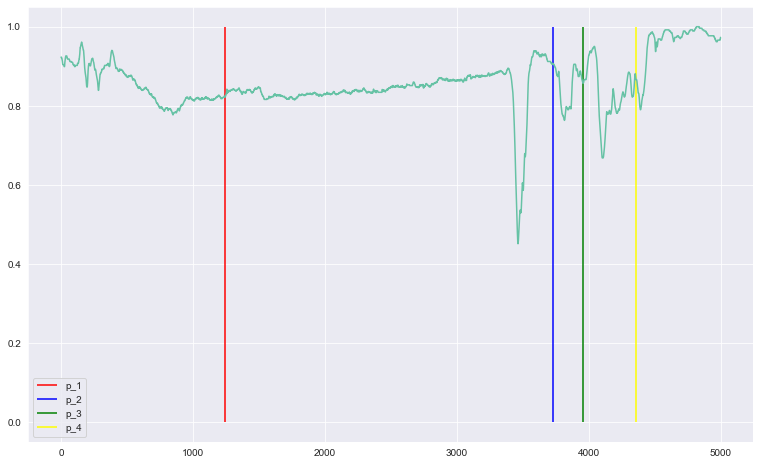

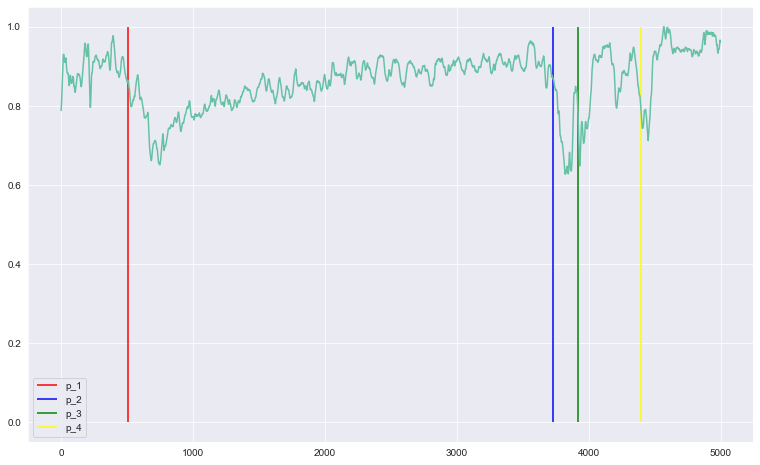

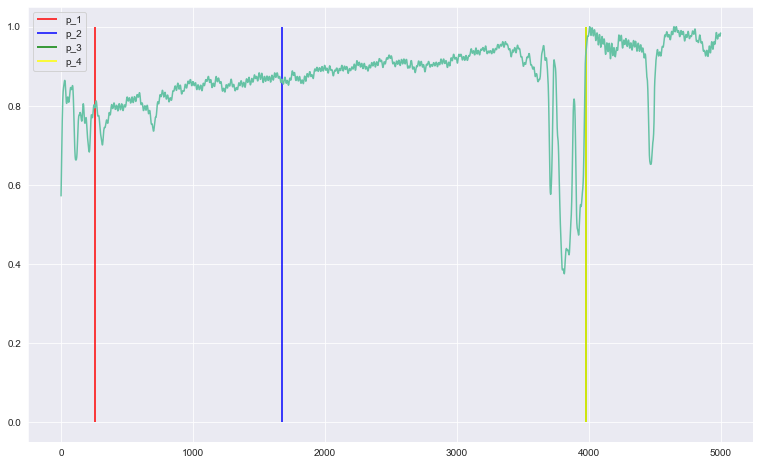

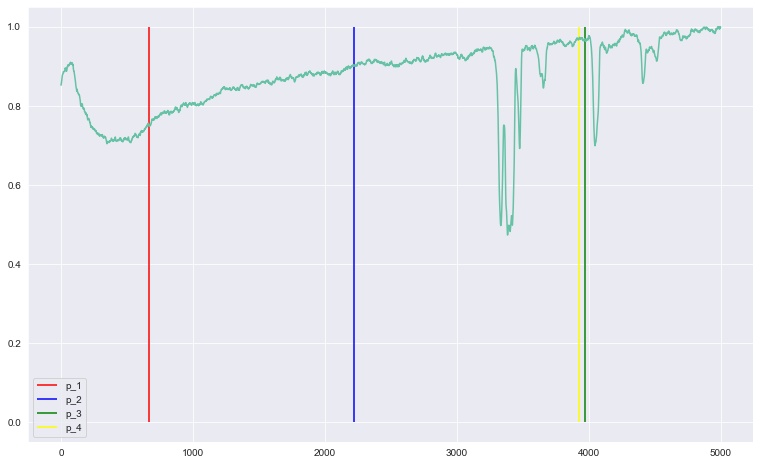

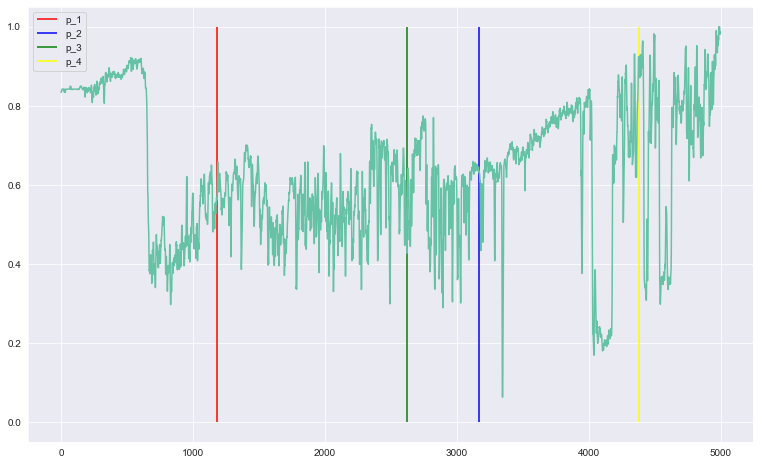

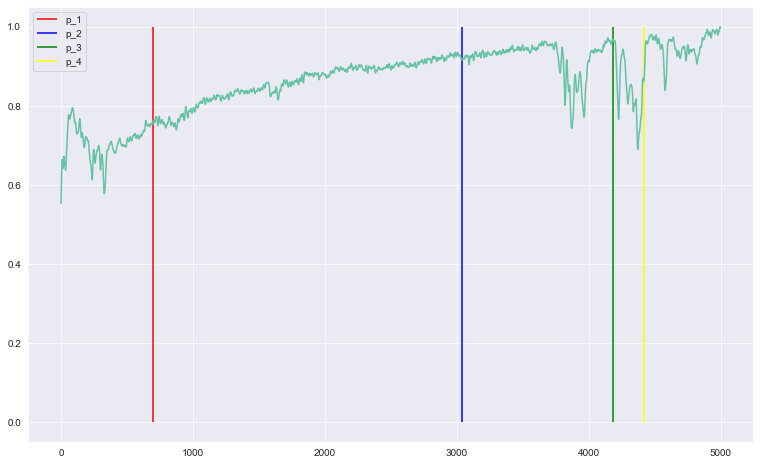

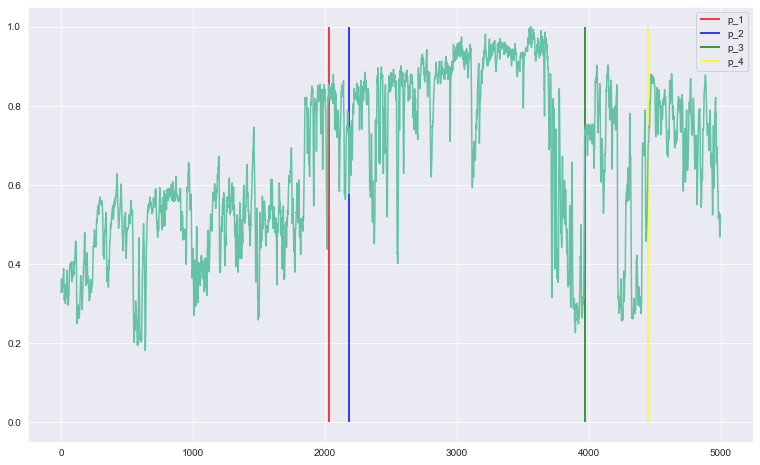

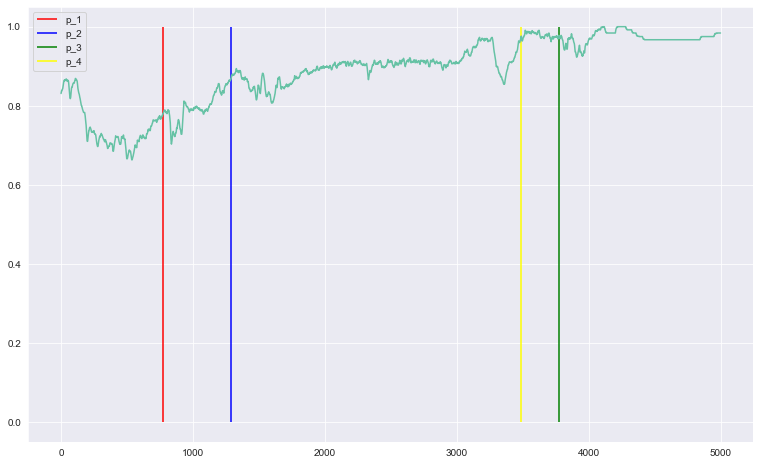

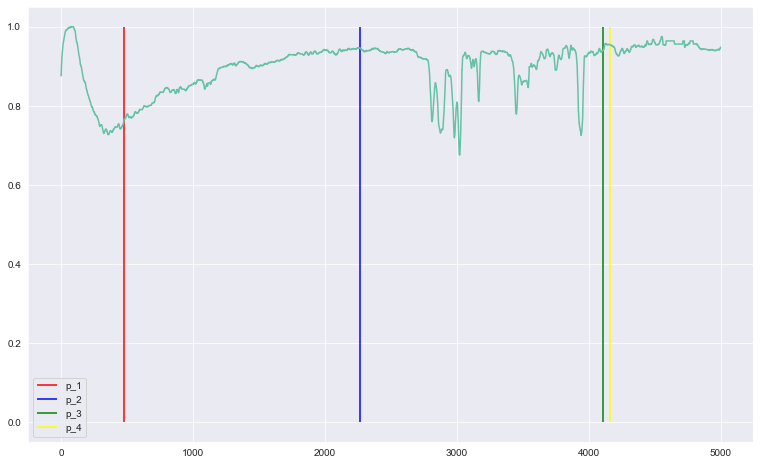

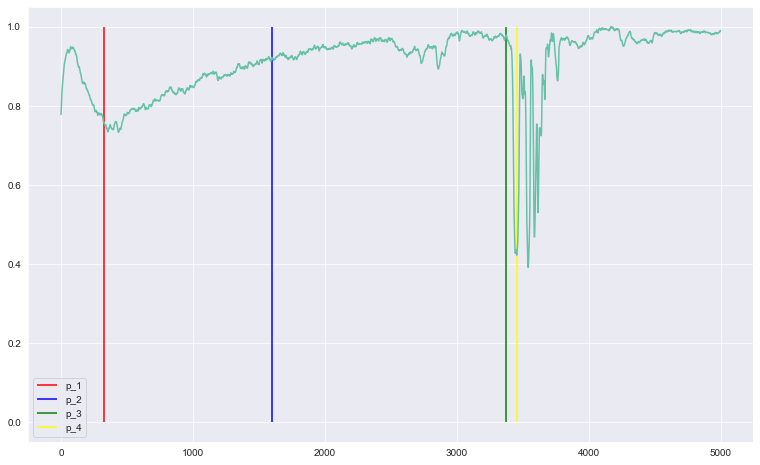

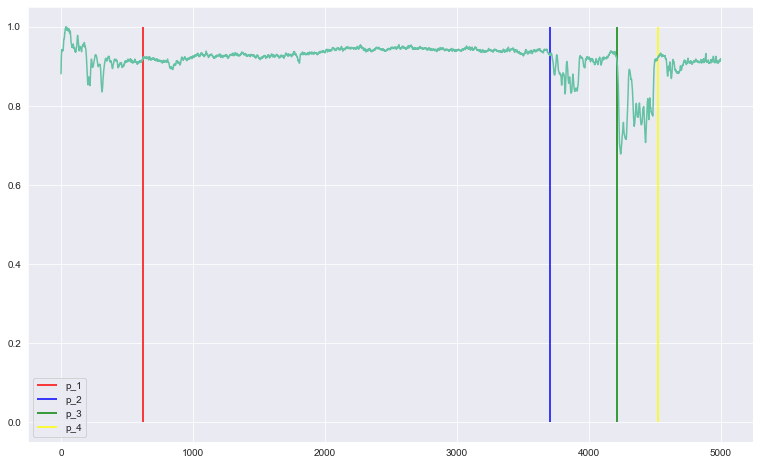

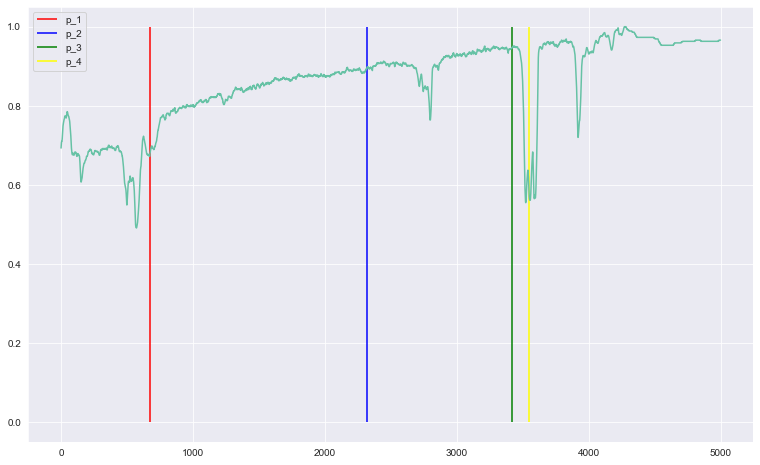

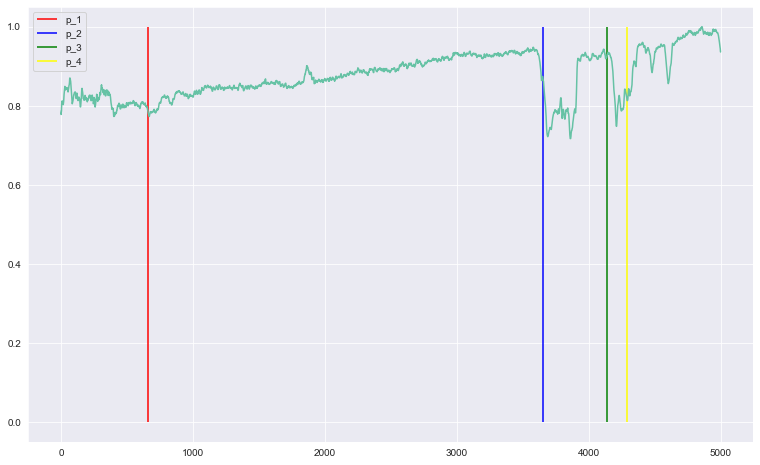

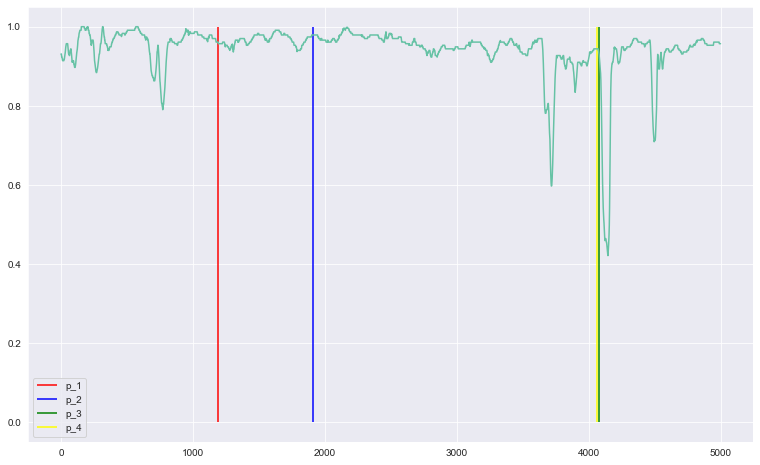

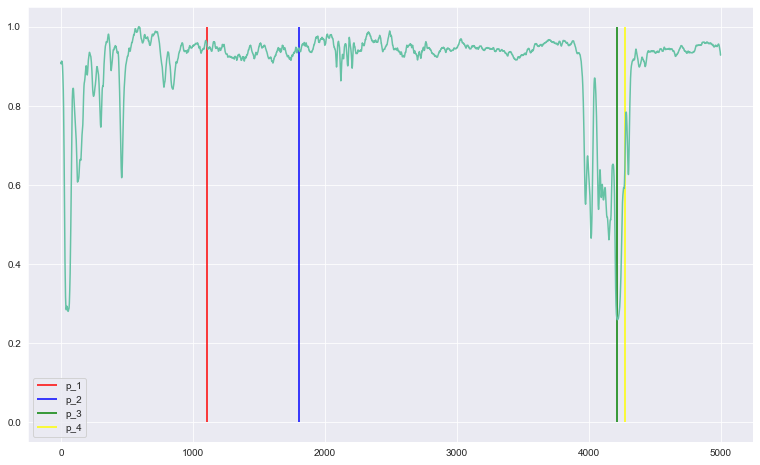

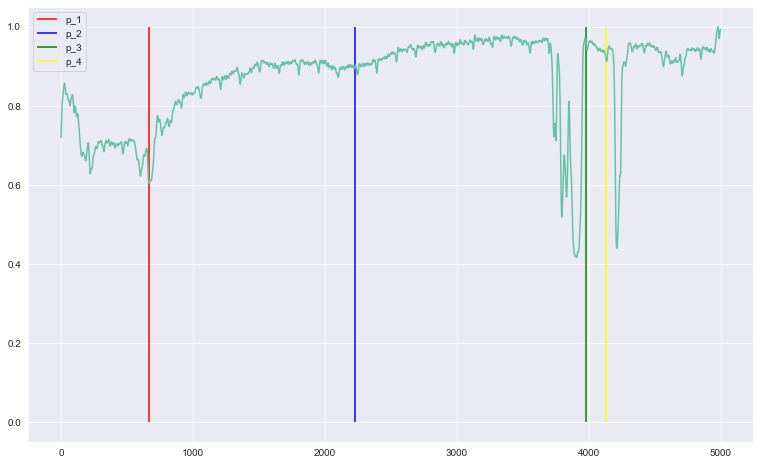

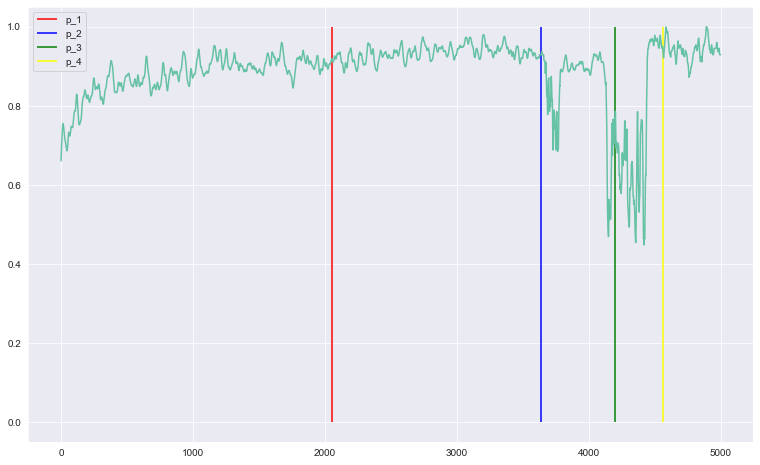

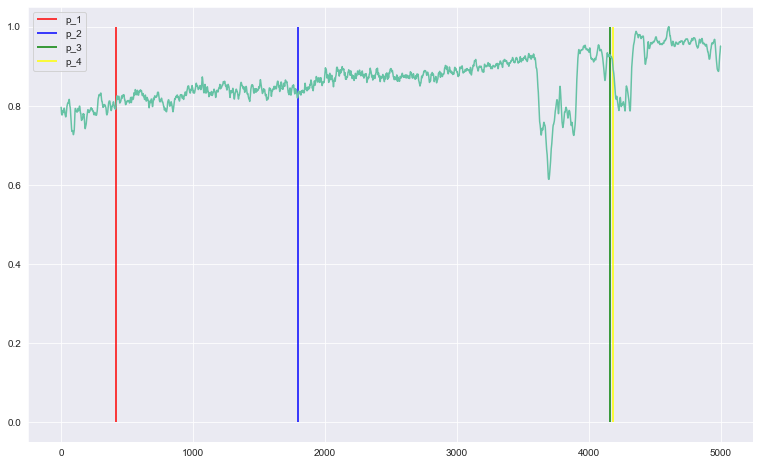

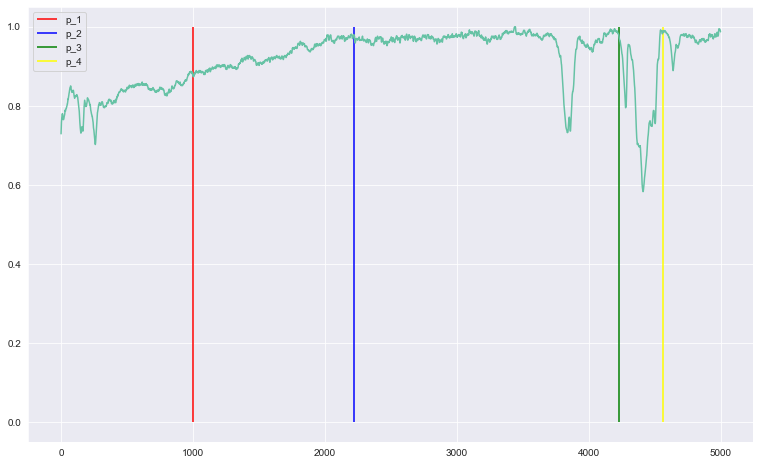

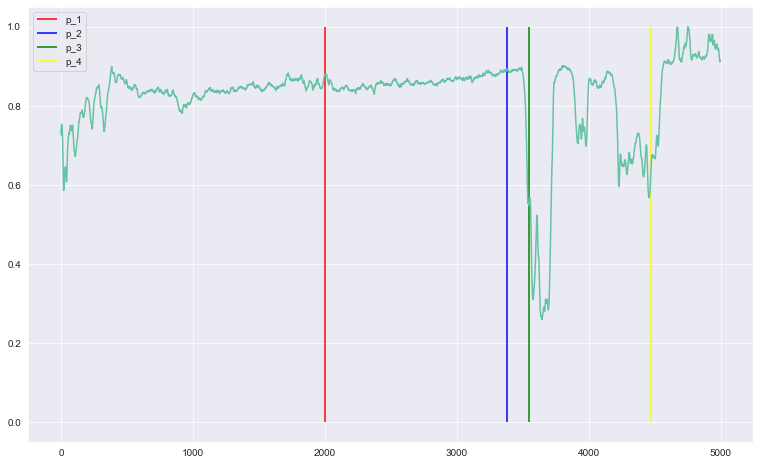

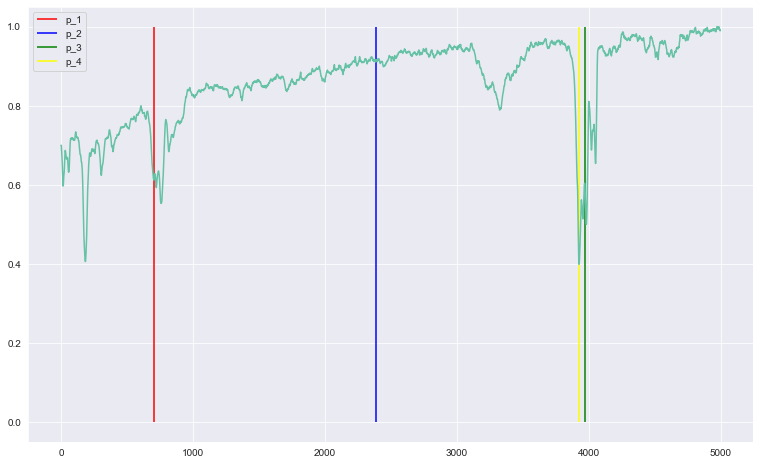

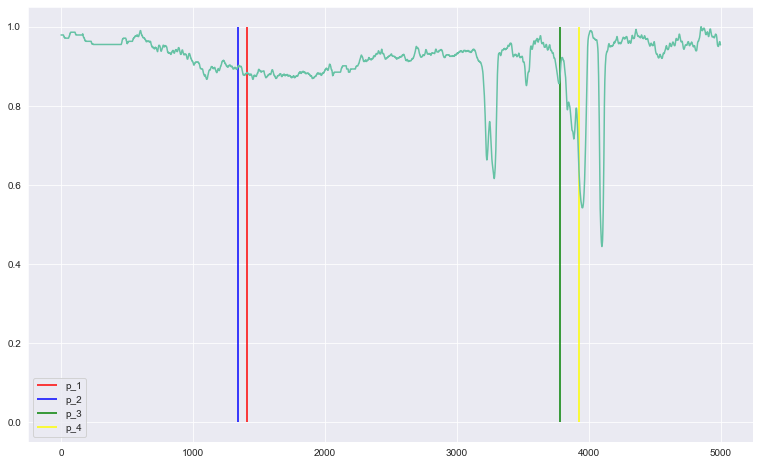

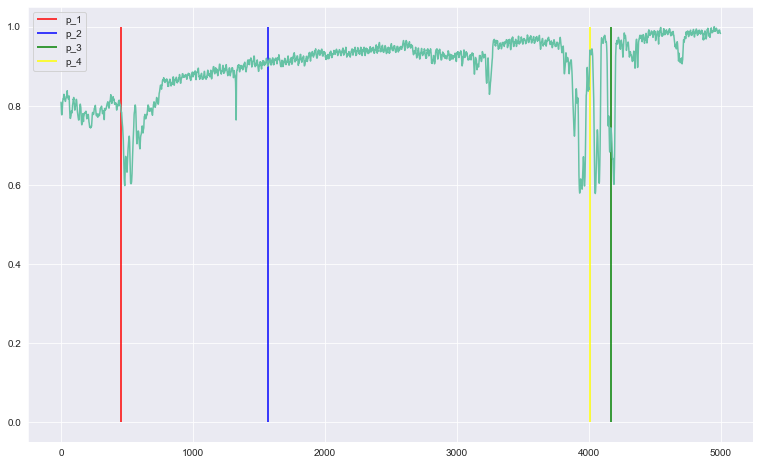

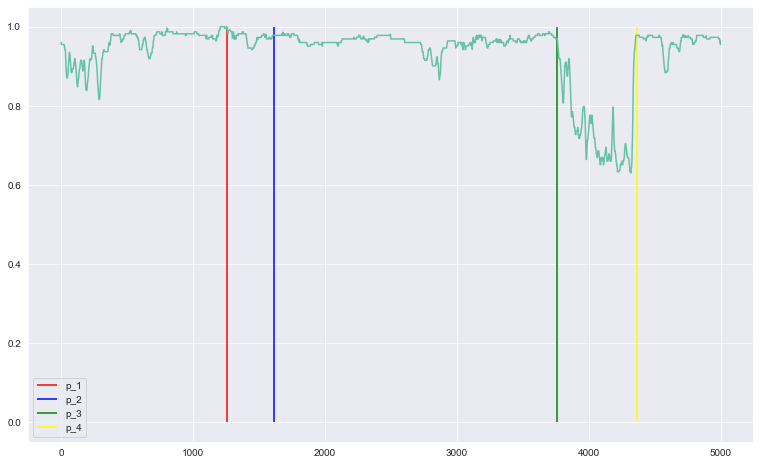

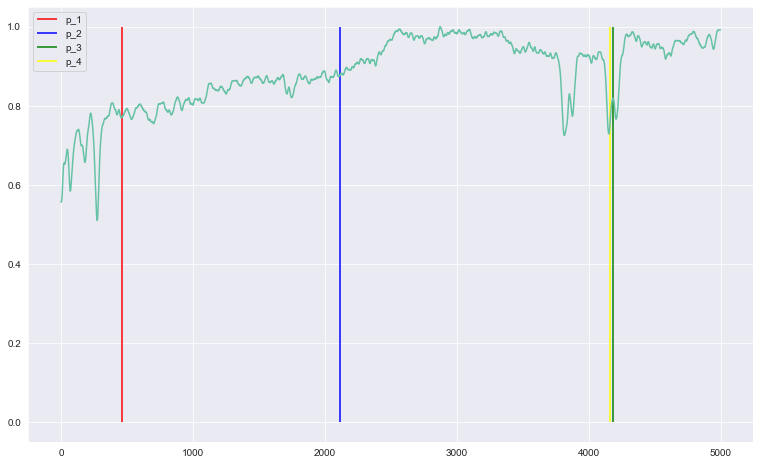

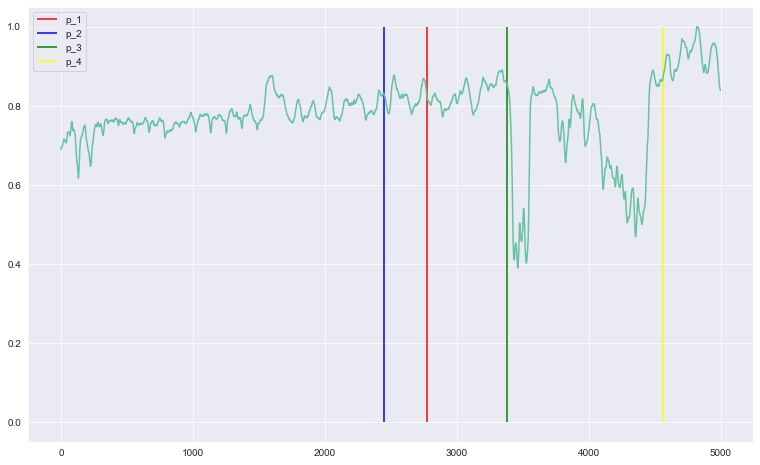

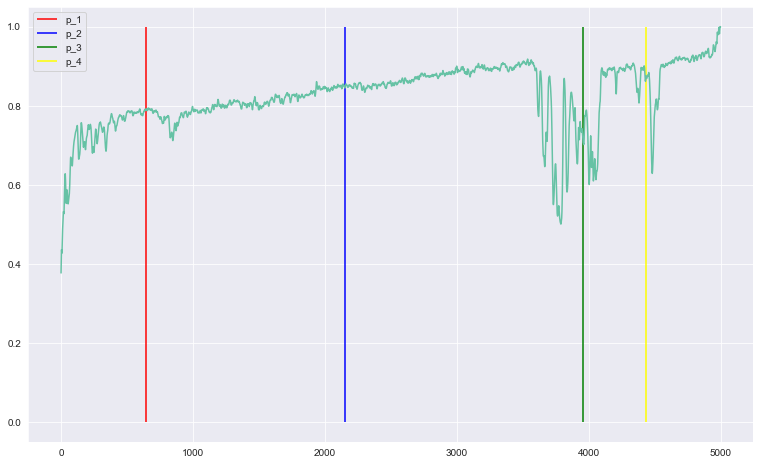

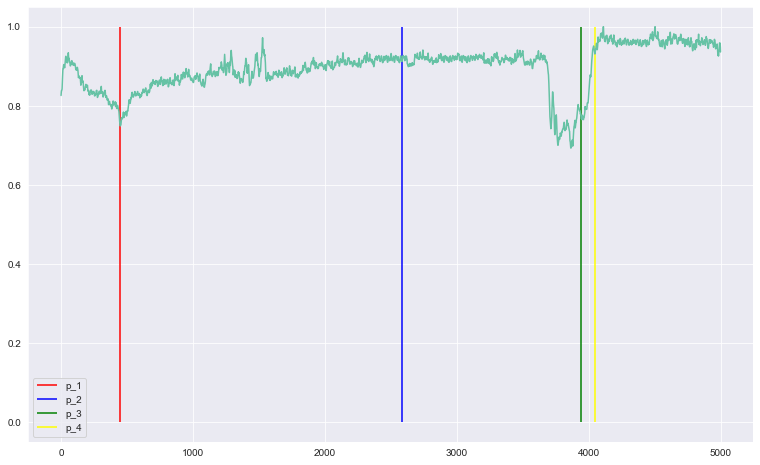

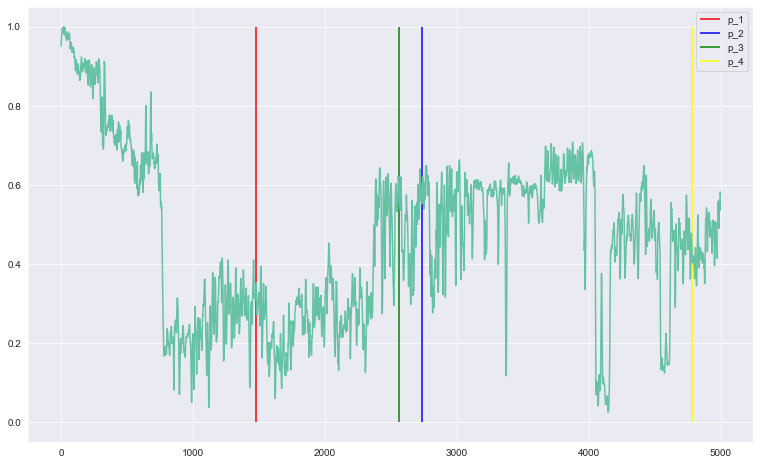

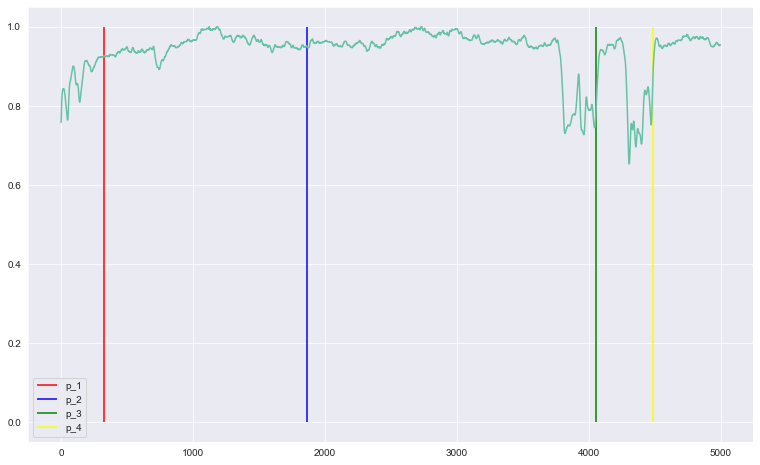

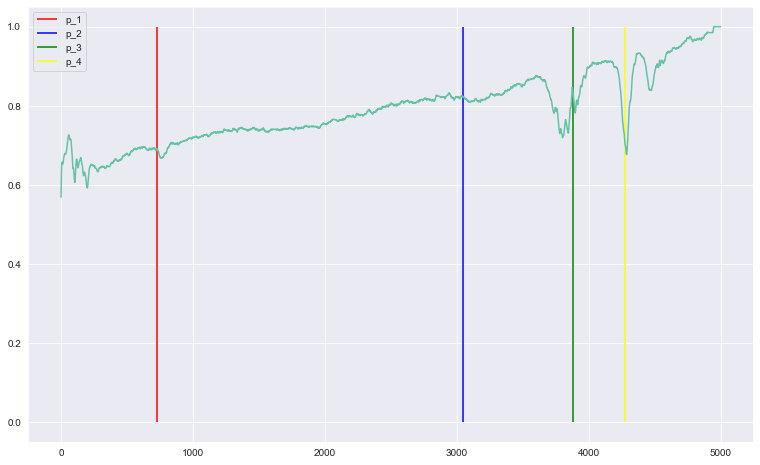

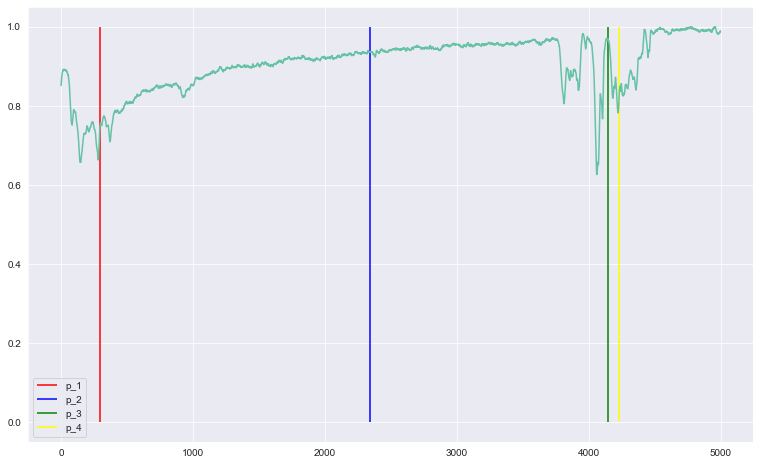

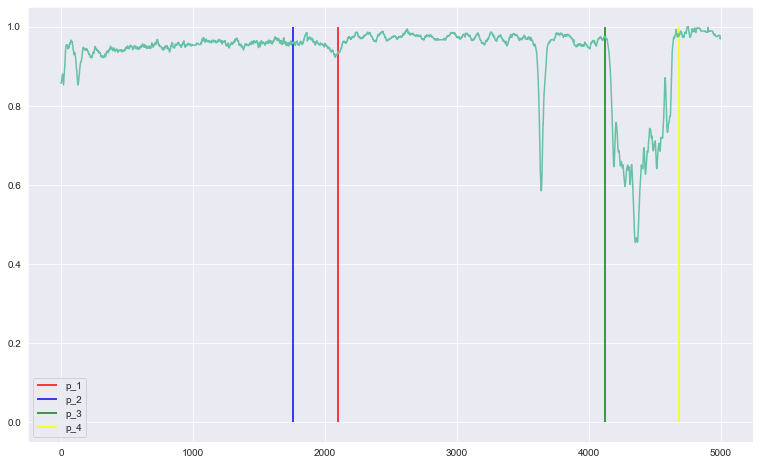

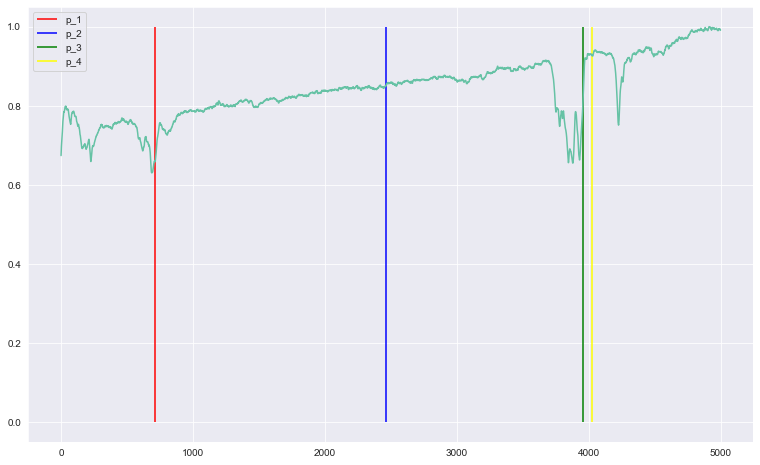

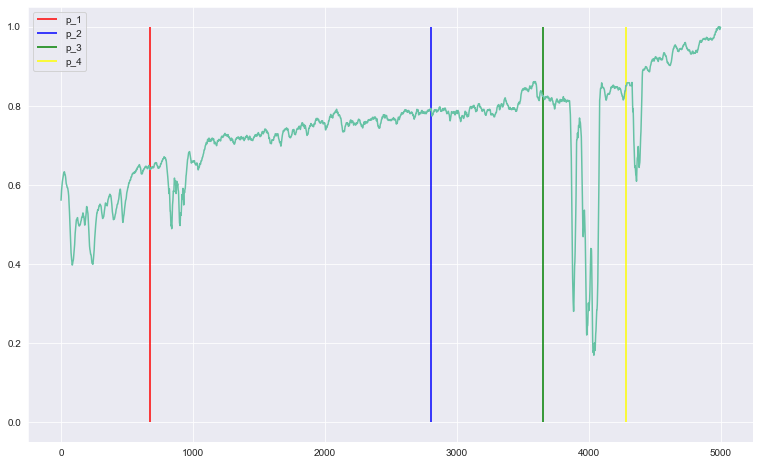

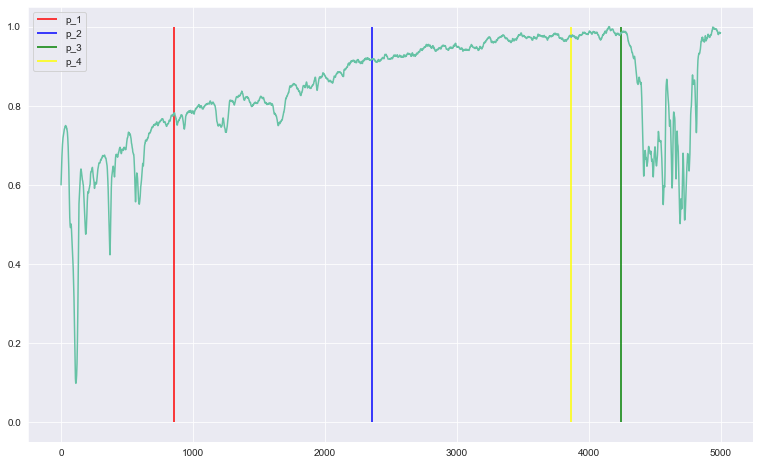

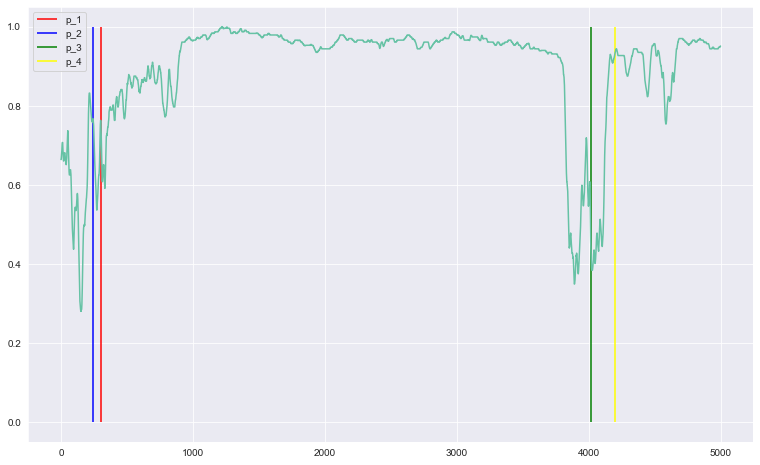

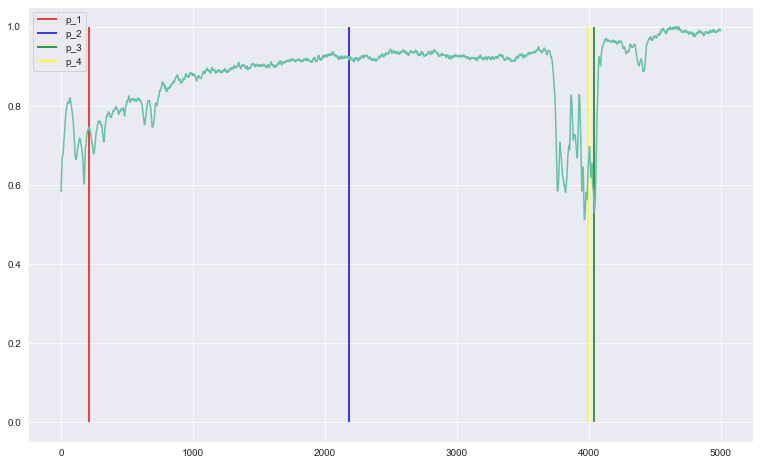

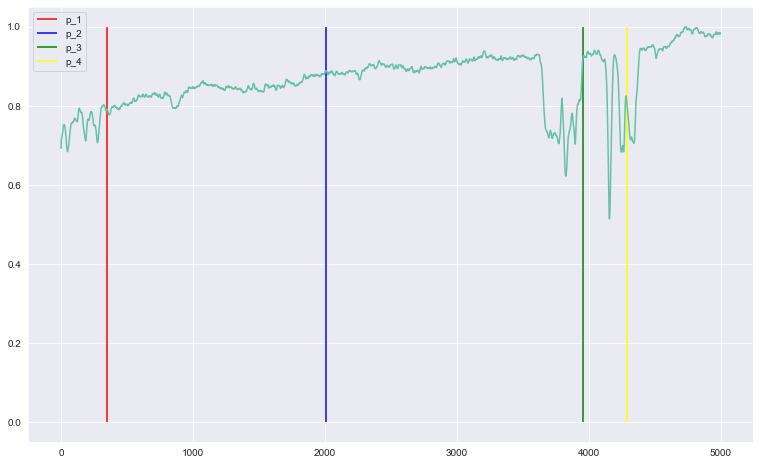

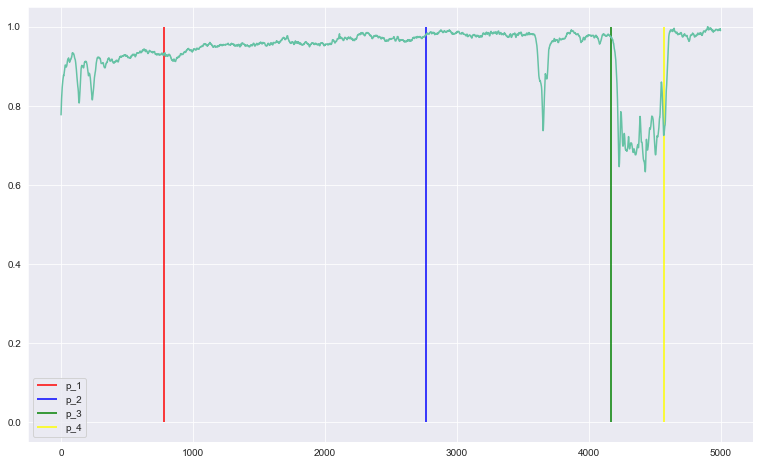

In [55]:
# визуализация полученных характерных точек для 0 кластера
for i in res_dataframe[res_dataframe['K'] == 0].values:        
        
        fig = plt.figure(figsize=(13, 8))
        
        plt.plot(i[3:5003])
        plt.vlines(i[-4], 0, 1, color='red' , label='p_1')
        plt.vlines(i[-3], 0, 1, color='blue', label='p_2')
        plt.vlines(i[-2], 0, 1, color='green', label='p_3')
        plt.vlines(i[-1], 0, 1, color='yellow', label='p_4')

        plt.legend()
        plt.show()

Если нужно посмотреть на значимость признаков в полученной модели

In [56]:
# feature_result = pd.DataFrame(model.feature_importances_, X_test1.columns)
# feature_result.columns = ['result']
# feature_result = feature_result.sort_values(by='result', ascending=False)
# feature_result = feature_result[feature_result['result']>0.005]
# plt.subplots(figsize=(15, 8))
# plt.barh(feature_result.index, feature_result['result'])

# plt.title('Feature Importance', fontsize=16)
# plt.xlabel('Value', fontsize=14)
# plt.ylabel('Feature', fontsize=14)
# plt.show()

## 5. Запись полученного результата

In [57]:
res_dataframe.head()

N         X         Y    v_1    v_2    v_3    v_4    v_5    v_6    v_7  \
0  168  3642.317  -107.175  0.558  0.595  0.519  0.742  0.664  0.467  0.426   
1  307  4034.298  -668.198  0.650  0.457  0.572  0.644  0.581  0.525  0.645   
2  668  4358.001  1703.199  0.638  0.621  0.646  0.495  0.510  0.611  0.574   
3  229  2786.060    75.125  0.917  0.917  0.916  0.912  0.908  0.905  0.904   
4  316   988.637  -492.056  0.359  0.364  0.379  0.396  0.404  0.405  0.392   

   ...  v_4996  v_4997  v_4998  v_4999  v_5000  K   p_1   p_2   p_3   p_4  
0  ...   0.606   0.523   0.607   0.629   0.664  7  1327  2489  2616  4985  
1  ...   0.397   0.579   0.636   0.570   0.530  7  1338  2418  2557  4998  
2  ...   0.569   0.587   0.541   0.412   0.519  7  1184  2458  2579  4868  
3  ...   0.943   0.943   0.943   0.943   0.943  2  1242  1441  3690  4006  
4  ...   0.626   0.606   0.629   0.674   0.727  6  1193  1758  2528  4286  

[5 rows x 5008 columns]

In [58]:
res_dataframe.shape

(760, 5008)

In [59]:
res_dataframe.to_csv('../data/result.csv', index=False, header=False)